In [1]:
import time
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter


In [2]:
import os
import pickle as pkl

import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors

from scipy.stats import pearsonr

In [3]:
import torch
from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.tvae_util import *
from transvae.analysis import get_top_2_most_correlated_PCs, make_model_name, get_latent_spaces, get_boloop_runs

from sklearn.decomposition import PCA

In [4]:
SAVE_FIGURES=False
data_dir="analysis/"
# os.listdir(data_dir)

In [34]:
def make_scatter_plot_w_barplot(df, col1, col2, col3, fig, alpha=0.7, raster=False):
    # fig = plt.figure(figsize=(9, 7))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0.00)
    ax_scatter = fig.add_subplot(gs[0, 0])
    ax_bar     = fig.add_subplot(gs[1, 0], sharex=ax_scatter)
    colour_palette="viridis"
    
    # ax=ax_scatter
    # ax2 = ax_bar
    # Bin col1 and compute average col3 in each bin
    bins = np.linspace(df[col2].min(), df[col2].max(), 20)  # 20 bins
    df["col2_bin"] = pd.cut(df[col2], bins)
    avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()

    ########################
    # Plot scatter of col2 vs col1, colored by col3
    # ax = fig.add_subplot(grid[0])
    ax_scatter = sns.scatterplot(
        data=df,
        x=col2, 
        y=col1, 
        hue=col3, 
        alpha=alpha,
        palette=colour_palette,
        edgecolor="none",
        rasterized=raster,
        ax=ax_scatter
    )
    
    #########################
    # add a colorbar to seaborn scatterplot
    norm = plt.Normalize(df[col3].min(), df[col3].max())
    sm = plt.cm.ScalarMappable(cmap=colour_palette)#, norm=norm)
    coll = ax_scatter.collections[0]
    cmap = coll.get_cmap()
    
    # # Remove the legend and add a colorbar
    ax_scatter.get_legend().remove()
    _xticks = ax_scatter.get_xticks()
    ax_scatter.set_xticks([]*len(_xticks))
    
    #########################
    # Plot histogram-like bars for average col3 in each col1 bin
    bin_centers = [interval.mid for interval in avg_col3_per_bin.index]
    ax_bar.bar(
        bin_centers, 
        avg_col3_per_bin, 
        width=np.diff(bins).mean()*0.8, 
        alpha=0.7, 
        label=f"Avg {col3} per bin", 
        color=cmap(norm(avg_col3_per_bin)) 
    )
    
    # set zero line
    ax_bar.hlines(y=0, xmin=bin_centers[0], xmax=bin_centers[-1]+1,color="gray", alpha=0.6)
    # sns.histplot(data=df, x="col1", ax=ax)
    
    ax_scatter.set_ylabel("")
    _yticks = ax_scatter.get_yticks()
    ax_scatter.set_yticks( []*len(_yticks) )
    
    _max = abs(avg_col3_per_bin).max()
    _max_5perc = _max*(1.05)
    ax_bar.set_ylim([(-1)*_max_5perc, _max_5perc])
    
    ax_scatter.set_xlabel("")
    # ax_bar.set_xlabel(col2)
    ax_bar.set_xlabel("")
    
    fontsize=16
    print(f"{col3=}")
    if col3=="boman":
        ax_bar.set_ylabel(f"B", fontsize=fontsize)
    elif col3=="charge":
        ax_bar.set_ylabel(f"q", fontsize=fontsize)
    elif col3=="hydrophobicity":
        ax_bar.set_ylabel(f"H", fontsize=fontsize)
    elif col3=="oracle":
        ax_bar.set_ylabel("oracle", fontsize=fontsize)
        
    ax_bar.set_yticks([(-1)*int(_max), 0, int(_max)])
    _ytick_labels = ax_bar.get_yticklabels()
    ax_bar.set_yticklabels(_ytick_labels, fontsize=fontsize)
    # print(avg_col3_per_bin.max(), avg_col3_per_bin.min())

    sns.despine(ax=ax_scatter, left=True)
    sns.despine(ax=ax_bar)
    return fig

In [6]:
latent_spaces = get_latent_spaces()

_d='transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-50-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-50-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-75-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-75-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-98-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-hydrophobicity-zScoreNormalized-organized

In [8]:
_prop = "predicted-log10mic"
_perc = 0
_dim_method = "PCA"
_box_bounds = 10

search_space_to_runs = {}
search_space_to_run_sequences = {}
search_space_to_run_data = {}

properties = ["boman", "chargepH7p2", "hydrophobicity", "boman-chargepH7p2", "bch", "predicted-log10mic"]
prop2abbreviation = {
    "boman": "b",
    "chargepH7p2": "c",
    "hydrophobicity":"h",
    "boman-chargepH7p2":"bc",
    "bch":"bch",
    "predicted-log10mic":"oracle"
}

dimensions = ["Id", 5]
for _prop in properties:
    abbreviated_prop = prop2abbreviation[_prop]
    if _prop == "predicted-log10mic":
        percentages = [0,98]
        dimensions = ["Id", 2,5,10,20,32]
    elif _prop == "bch":
        dimensions = ["Id", 2,5,10,20,32]
    else:
        dimensions = ["Id", 5]
        percentages = [0,25,50,75,98]
        
    for _perc_i, _perc in enumerate(percentages):
        for _, _n_pca_dims in enumerate(dimensions):
            model_name = make_model_name( prop2abbreviation[_prop], 100, _perc)
            print(f"{model_name=}")
    
            
            if _n_pca_dims=="Id":
                
                prop_perc = f"{_n_pca_dims}-{_perc}-{abbreviated_prop}"
                runs = get_boloop_runs(model_name, _perc, "identity",_box_bounds)
            else:
                prop_perc = f"pca{_n_pca_dims}-{_perc}-{abbreviated_prop}"
                runs = get_boloop_runs(model_name, _perc, _dim_method,_box_bounds,n_pca_dims=_n_pca_dims)
            
            print(f"{prop_perc=}")
            
            runs_temp = {}
            for i, _run in enumerate(runs):
                _k = f"run_{i}"
                runs_temp[_k]=_run
            runs = runs_temp
            
            
            data=pd.DataFrame()
            sequence_data = pd.DataFrame()
            run_data = pd.DataFrame()
            end_point = 500
            for i in range(5):
                if i==0:
                    if len(runs[f"run_{i}"]['iterations'] ) > end_point:
                        data['iterations']=runs[f"run_{i}"]['iterations'][:end_point]
                    else:
                        data['iterations']=runs[f"run_{i}"]['iterations']
                if len(runs[f"run_{i}"]["best_objective_values"]) > end_point:
                    data[         f"run{i}"] = runs[f"run_{i}"]["best_objective_values"][:end_point]
                    sequence_data[f"run{i}"] = runs[f"run_{i}"]["best_sequences"][:end_point]
                    run_data[     f"run{i}"] = runs[f"run_{i}"]["candidates"][:end_point]
                else:
                    data[         f"run{i}"] = runs[f"run_{i}"]["best_objective_values"]
                    sequence_data[f"run{i}"] = runs[f"run_{i}"]["best_sequences"]
                    run_data[     f"run{i}"] = runs[f"run_{i}"]["candidates"]
    
            search_space_to_runs[         prop_perc] = data
            search_space_to_run_sequences[prop_perc] = sequence_data
            search_space_to_run_data[     prop_perc] = run_data
            # melted_data = pd.melt(data, id_vars=["iterations"], value_vars=[f"run{i}" for i in range(5)])
            

model_name='transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized'
in first if
_fname='boloop_results_identity_neg10to10_transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized_log10_mic.pkl'
prop_perc='Id-0-b'
model_name='transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized'
in first if
_fname='boloop_results_PCA_neg10to10_transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized_log10_mic.pkl'
prop_perc='pca5-0-b'
model_name='transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized'
_fname='boloop_results_identity_neg10to10_transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized_log10_mic.pkl'
prop_perc='Id-25-b'
model_name='transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized'
_fname='boloop_results_PCA_neg10to10_transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized_log10_mic.pkl'
pr

In [9]:
search_space_to_runs.keys()

dict_keys(['Id-0-b', 'pca5-0-b', 'Id-25-b', 'pca5-25-b', 'Id-50-b', 'pca5-50-b', 'Id-75-b', 'pca5-75-b', 'Id-98-b', 'pca5-98-b', 'Id-0-c', 'pca5-0-c', 'Id-25-c', 'pca5-25-c', 'Id-50-c', 'pca5-50-c', 'Id-75-c', 'pca5-75-c', 'Id-98-c', 'pca5-98-c', 'Id-0-h', 'pca5-0-h', 'Id-25-h', 'pca5-25-h', 'Id-50-h', 'pca5-50-h', 'Id-75-h', 'pca5-75-h', 'Id-98-h', 'pca5-98-h', 'Id-0-bc', 'pca5-0-bc', 'Id-25-bc', 'pca5-25-bc', 'Id-50-bc', 'pca5-50-bc', 'Id-75-bc', 'pca5-75-bc', 'Id-98-bc', 'pca5-98-bc', 'Id-0-bch', 'pca2-0-bch', 'pca5-0-bch', 'pca10-0-bch', 'pca20-0-bch', 'pca32-0-bch', 'Id-25-bch', 'pca2-25-bch', 'pca5-25-bch', 'pca10-25-bch', 'pca20-25-bch', 'pca32-25-bch', 'Id-50-bch', 'pca2-50-bch', 'pca5-50-bch', 'pca10-50-bch', 'pca20-50-bch', 'pca32-50-bch', 'Id-75-bch', 'pca2-75-bch', 'pca5-75-bch', 'pca10-75-bch', 'pca20-75-bch', 'pca32-75-bch', 'Id-98-bch', 'pca2-98-bch', 'pca5-98-bch', 'pca10-98-bch', 'pca20-98-bch', 'pca32-98-bch', 'Id-0-oracle', 'pca2-0-oracle', 'pca5-0-oracle', 'pca10-0-

In [10]:
search_space_to_run_data['pca5-0-b'].head(5)

run0  \
0  MGRPQDADKEQENDEQEQKERQDEEDKQRELSEDELDQTGRQRRQM...   
1  WWGWWGIWRNKDPEKEDRQRDKEDRQAREDPQRRRANRPADLEPDG...   
2  MQALQQMELEQAQELQLEAAQLELQALEAEAPDELQALAVQVSLEE...   
3  GGYICGRGRNGNGDKDNRGDERDKDCNKERWDREHRTGDSGHGREN...   
4  WALGLRADEEQEEQEEEQEEEQEEEEQELEEKEQLKELEQEEPEER...   

                                                run1  \
0  MKIEYITIGKYTGILGRIYTGTKVRFDITRPIVKYKDFTITVLRSR...   
1  MNSTNDCKCDNCWKCNCDCISCDRCSCECGDYLCKCQTCRVCRDAR...   
2  MNTNSSSDCDCNCYGCNCSDCPSYTGRCYMCNCPSCEDCGYCRTLQ...   
3  MENQNKMMICMVIVWKFPSGTCIVVICLSFGLTTVTFTKVLYISFT...   
4  MENENKMMCIIVCLGFVGTCSICFVIVTFYGSATVCNGILFITYAS...   

                                                run2  \
0  MNGTNSCKDYYKCTNCGDSDYRCKNCGQCDVRYTCEDCSCPRCREK...   
1  NKKTNINTYTTTYKYKCNYKTYKCNGTRYTRCNRCKDRTCRTRRTD...   
2  MPCSDCCAHPPRCTPEWQCPNPRCGQPIVPHCGDPEPCCLCVSRPE...   
3  GIWCGIGYGCGYGIGYCGGRTYGWITRDCGWRRRTCRWIDGTVPRG...   
4  GWIGWICGGCYGIGYGCGYGIGYGCRDGYVGCRRVGCRDCGYGRIG...   

                                                run3  \
0  MCPKWDCKHCDSDCKPNRYPQTRCKDPSHIGHRPDGNPVSCPRTRQ...   
1  MCWPCAWCWPTVCWPCRAWCPSYCVAWTPRWCLPTCPVVCGFPYRP...   
2  MSVHTGPCRPACPVRWMPTGCPSVRPVYGSVPPLCTLCRCVGWDAQ...   
3  MSVHCPAGDCPVPLFTCPVRSPCGDVPLFTWMPCDLLCCGCVPADA...   
4  MMPCTGSWHWVGVCWSWACVCVCPVGCFPRWPVPVCDACCWCCILM...   

                                                run4  
0  PSCPHPCMHCSSHPPPNPRSCQHSPGMPRCNPQCACPRQHKWSGNPVMA  
1  MKENINKDKEKDNIEKNDRKNEISDEDKRINDARNADKRHIESIDK...  
2  MEQNENQEKNEQEEQQEENKNEQKELEENAQIQEDKESERQNVEEM...  
3  MIGWLGIGVVGFLGVIGVWALTGWILTLGGVLYLSGLGTVVGYAML...  
4  MIWAGIWILGWIVAGVVFGLGYVAGGLTVLWLIGLTVTWLGGLGTL...

pca20-98-oracle run2 1.1682578568262683

In [11]:
search_space_to_runs["pca20-98-oracle"].head()

iterations      run0      run1      run2      run3      run4
0           1 -0.713370 -0.714423 -0.259853 -0.331591 -0.708098
1           2 -0.509553 -0.714423 -0.259853 -0.331591 -0.363118
2           3 -0.509553 -0.442479 -0.259853 -0.331591 -0.363118
3           4 -0.509553 -0.442479 -0.259853 -0.331591 -0.363118
4           5 -0.509553 -0.442479 -0.259853 -0.331591 -0.156245

In [12]:
df = search_space_to_runs["pca20-98-oracle"]

x = np.array(df.iterations)
y = np.array(df.run2)



In [13]:
last_iterations = df.groupby("run2")["iterations"].last()
print( list(last_iterations.values), "\n", list(last_iterations.index), list(range(len(last_iterations))) )


[13, 15, 16, 21, 23, 25, 31, 55, 81, 139, 157, 178, 225, 227, 335, 409, 500] 
 [-0.25985255229686555, -0.13653393594479235, 0.017160979547208743, 0.20836765153164638, 0.31004341891409437, 0.325188617804991, 0.5161903374186338, 0.5551600068447082, 0.5590152450218815, 0.6742091651648359, 0.6888601890168125, 0.7239971534258673, 0.8015042731391424, 0.963450303061947, 1.0338267878222909, 1.0603337177023842, 1.1682578568262683] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [14]:
labels = list(
    zip(
        list(last_iterations.values), 
        [round(_v, 3) for _v in last_iterations.index], 
        list(range(1,len(last_iterations)+1,1))
    )
)

In [15]:
labels

[(13, -0.26, 1),
 (15, -0.137, 2),
 (16, 0.017, 3),
 (21, 0.208, 4),
 (23, 0.31, 5),
 (25, 0.325, 6),
 (31, 0.516, 7),
 (55, 0.555, 8),
 (81, 0.559, 9),
 (139, 0.674, 10),
 (157, 0.689, 11),
 (178, 0.724, 12),
 (225, 0.802, 13),
 (227, 0.963, 14),
 (335, 1.034, 15),
 (409, 1.06, 16),
 (500, 1.168, 17)]

In [16]:
sns.color_palette("rocket_d",n_colors=17).as_hex()

['#902558',
 '#9c2d55',
 '#a83453',
 '#b43b50',
 '#c0434e',
 '#cc4a4b',
 '#d85148',
 '#e45846',
 '#f06043',
 '#db5b41',
 '#c65640',
 '#b1513e',
 '#9c4c3c',
 '#86473a',
 '#714238',
 '#5d3d37',
 '#483835']

# grab PCA data

In [17]:
print(latent_spaces.keys(),"\n\n",
      search_space_to_run_sequences.keys()
     )

dict_keys(['boman-0', 'boman-25', 'boman-50', 'boman-75', 'boman-98', 'hydrophobicity-0', 'hydrophobicity-25', 'hydrophobicity-50', 'hydrophobicity-75', 'hydrophobicity-98', 'chargepH7p2-0', 'chargepH7p2-25', 'chargepH7p2-50', 'chargepH7p2-75', 'chargepH7p2-98', 'boman-chargepH7p2-0', 'boman-chargepH7p2-25', 'boman-chargepH7p2-50', 'boman-chargepH7p2-75', 'boman-chargepH7p2-98', 'bch-0', 'bch-25', 'bch-50', 'bch-75', 'bch-98', 'predicted-log10mic-0', 'predicted-log10mic-98']) 

 dict_keys(['Id-0-b', 'pca5-0-b', 'Id-25-b', 'pca5-25-b', 'Id-50-b', 'pca5-50-b', 'Id-75-b', 'pca5-75-b', 'Id-98-b', 'pca5-98-b', 'Id-0-c', 'pca5-0-c', 'Id-25-c', 'pca5-25-c', 'Id-50-c', 'pca5-50-c', 'Id-75-c', 'pca5-75-c', 'Id-98-c', 'pca5-98-c', 'Id-0-h', 'pca5-0-h', 'Id-25-h', 'pca5-25-h', 'Id-50-h', 'pca5-50-h', 'Id-75-h', 'pca5-75-h', 'Id-98-h', 'pca5-98-h', 'Id-0-bc', 'pca5-0-bc', 'Id-25-bc', 'pca5-25-bc', 'Id-50-bc', 'pca5-50-bc', 'Id-75-bc', 'pca5-75-bc', 'Id-98-bc', 'pca5-98-bc', 'Id-0-bch', 'pca2-0-bch

In [18]:
def get_best_run(search_space_to_runs, max_key):
    _run_cols = [f"run{i}" for i in range(5)]
    _runs = search_space_to_runs[max_key][_run_cols]
    return _runs.iloc[-1].idxmax()

In [19]:
get_best_run(search_space_to_runs,max_key)

NameError: name 'max_key' is not defined

In [20]:
import matplotlib

In [35]:
def plot_full_sampling_path(search_space_to_run_sequences:dict,
                            search_space_to_run_data:dict,
                            model:TransVAE,
                            organizing_perc:int, 
                            organizing_property:str,
                            run_space:str,
                            colour_by:str, 
                            fig:matplotlib.figure.Figure,
                            runN:str=None,
                            plot_best_points:bool=True,
                           return_animation_objects:bool=False):
    """
    inputs:
        organizing_perc, percentage of labels accessible during joint training of property predictor
            choices: [100,75,50,25,2]
        organizing_property, the property the latent space was organized by
            choices: ["boman", "charge", "hydrophobicity", "boman-charge", "bch", "predicted-log10mic"]
        run_space, the space the BayesOpt run was done in.
            choices: ["Id", "pca5"] and for some properties ["pca2","pca10","pca20","pca32"]
        colour_by, what to colour the latent space by, and how to select PCs to plot with
            choices: ["boman", "charge", "hydrophobicity", "oracle"]
            
    """
    organizing_perc = 100-organizing_perc
    if run_space not in ["Id", "pca2","pca5","pca10","pca20","pca32"]:
        raise InputError(f"{run_space=} not available choice")
    if colour_by not in ["boman", "charge", "hydrophobicity", "oracle"]:
        raise InputError(f"{colour_by=} not available choice")

    if organizing_property in ["boman", "charge", "chargepH7p2","hydrophobicity"]:
        _key_suffix = organizing_property[0]
    elif organizing_property in ["boman-charge","boman-chargepH7p2"]:
        _key_suffix = "bc"
    elif organizing_property == "predicted-log10mic":
        _key_suffix = "oracle"
    else:
        _key_suffix = organizing_property
    
    max_key = f"{run_space}-{organizing_perc}-{_key_suffix}"

    
    ############################
    # get best run out of the five for the given options
    if runN is None:
        max_run = get_best_run(search_space_to_runs, max_key)
    else:
        max_run = runN
        
    ############################
    # get best sequences found throughout a run
    best_sequences = search_space_to_run_sequences[max_key][max_run]
    best_sequences_unique = list(pd.unique(best_sequences))
    for _seq in best_sequences_unique:
        print(len(_seq), _seq)
    
    # grab the sequences of the run
    run_sequences = search_space_to_run_data[max_key][max_run]
    print()
    print(run_sequences[0])


    ############################
    # Embed sequences in latent space
    model.params["BATCH_SIZE"] = int(len(best_sequences_unique))#_run_length
    
    _sequences = best_sequences_unique
    _processed_sequences = []
    for _seq in _sequences:
        _processed_sequences.append( _seq.split("<end>")[0] )
    sequences = np.array(_processed_sequences).reshape(-1,1)
    
    with torch.no_grad():
        _, mu, _ = model.calc_mems(sequences, log=False, save=False)
        
    # Now do all of the candidates in the run
    model.params["BATCH_SIZE"] = int(len(run_sequences))#_run_length
    
    _sequences = run_sequences
    _processed_sequences = []
    for _seq in _sequences:
        _processed_sequences.append( _seq.split("<end>")[0] )
    sequences = np.array(_processed_sequences).reshape(-1,1)
    
    with torch.no_grad():
        _, mu_run_sequences, _ = model.calc_mems(sequences, log=False, save=False)

    ##############################
    # Perform dimensionality reduction
    # load property data
    # get top two principal components (based on pearson correlation coefficient)
    pca = PCA(n_components=5)
    pca.fit(latent_spaces[f"{organizing_property}-{organizing_perc}"])
    
    pca_latent_space = pca.transform(latent_spaces[f"{organizing_property}-{organizing_perc}"])
    pca_mu = pca.transform(mu)
    pca_mu_run_sequences = pca.transform(mu_run_sequences)
    
    oracle_values_train = pd.read_csv("data/peptides_predicted_log10_mic_train.txt")
    bch_properties = pd.read_csv("data/properties/peptides_2024_cdhit90_unbalanced_train_properties_zScoreNormalized.txt")
    
    df = pd.DataFrame()
    for i in range(pca.n_components):
        df[f'pc{i+1}'] = pca_latent_space[:,i]
    
    df['boman']          = bch_properties[         "boman"]
    df['charge']         = bch_properties['charge(pH=7.2)']
    df['hydrophobicity'] = bch_properties["hydrophobicity"]
    df["oracle"]         = oracle_values_train["predicted_mic"]
    
    _pc1, _pc2 = get_top_2_most_correlated_PCs(df, colour_by)

    _pc1_idx = int(_pc1[-1])-1
    _pc2_idx = int(_pc2[-1])-1

    ############################## 
    # start plotting
    fig = make_scatter_plot_w_barplot(df, _pc2, _pc1, colour_by, fig, alpha=0.2)

    _ax_scatter = fig.get_axes()[0]
    _ax_scatter.plot(
        pca_mu_run_sequences[:,_pc1_idx],
        pca_mu_run_sequences[:,_pc2_idx],
        color="k",
        alpha=0.3,
        marker="."
    
    )

    if plot_best_points:
        _ax_scatter.scatter(
            pca_mu[:,_pc1_idx], 
            pca_mu[:,_pc2_idx], 
            color=sns.color_palette("rocket_d",n_colors=len(pca_mu)),
            s=(10)**2,
            # marker="*"
        )
        
        for i in range(len(pca_mu)):
            _ax_scatter.text(
                x = pca_mu[i,_pc1_idx], 
                y = pca_mu[i,_pc2_idx], 
                s = str(i+1), 
                horizontalalignment="center", 
                verticalalignment="center",
                # color=sns.color_palette("Greys", n_colors=17)[i],
                color="white",
                fontsize=10,
            )

    return fig

In [22]:
max_key, max_run, max_activity = "pca20-98-oracle", "run2", 1.1682578568262683
organizing_perc     = 98
# max_key, max_run, max_activity = f"Id-{organizing_perc}-bch", "run3", 1.1682578568262683
# organizing_property = "bch"
# colour_by = "boman" # choices in ["boman", "charge", "hydrophobicity", "oracle"]
# max_key, max_run, max_activity = f"pca5-{organizing_perc}-oracle", "run1", 1.1682578568262683
organizing_property = "predicted-log10mic"
colour_by = "oracle" # choices in ["boman", "charge", "hydrophobicity", "oracle"]

max_run = get_best_run(search_space_to_runs, max_key)
print(max_run)

run2


In [23]:
### get model
_model_number = 100
_model_name = make_model_name(organizing_property,str(_model_number), organizing_perc)

model_src = "checkpointz/" + _model_name + f"/{_model_number}_{_model_name}.ckpt"
device=torch.device("cpu")
device_str="cpu"

model_obj=torch.load(model_src, map_location=device)
model = TransVAE(load_fn=model_src, workaround=device_str, params=model_obj['params'])
model.params['HARDWARE']= device_str

model.model.eval()

/tmp/ipykernel_133313/3444429488.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_obj=torch.load(model_src, map_location=device)
/home/jyler/projects/compare-latent

EncoderDecoder(
  (encoder): VAEEncoder(
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=256, bias=True)
          (w_2): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (conv_bottleneck): ConvBottleneck(
      (conv_layers): ListModule(
        (0): Sequential(
          (0): Conv1d(512, 288, kernel_size=(9,), stride=(1,))
          (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [24]:
tstfig = plt.figure(figsize=(6,6))

<Figure size 600x600 with 0 Axes>

78 MDSRAFSRPKCVGCGRTWNAMPDERKAFREGSGRKTPDGKVACRSSGRVFTPDLDGARALPEKGARLPSHTNAKRYQS
98 MADSKTRSGMTRTFRERKKTCAARGSPERAGILKDRRTGSRTFDRSKARKSGLKVPDTGLGVHTRALRDLSKAEAGPDVTGKFLHPEENSKAGKGRHQ
98 MQMTTKSARTEKSRRPAYAEASRASGSSLTRTERTGKARTDSLKVRTGSRARLTPKSALKVFTGSLPTRPIAVSGLTKLDALGFRRVAEATKKGGRHQ
95 MQTMQAKSASSTRREFRKASRTADRISTKDESVKTCASSARTRTARGASLRLSVRAMKTLPGTRILSFTLPAVKAGVRNALFSFRGTIAALPHSQ
81 MQTMQSKAAKVTRSFRSRKVKAIRTSRTEVRTVSPARATKKISVGACSTRLARKLTAGFVSVLKDLGGKSLSKILARSGDS
95 MQTMQSKSAKAERSYVRRTFATSCAASDSAASIKTRTCASVRTLKVRARSFSGLRVKTCNGIRALLNCGTRAALTRINSAGFTYLSALQAVRCSQ
78 MQTTMQAKKASSKFSRRSRVSIPEKSVFTASGKTVRAKTRAMKSIRTHSLTCLAGVLSMKVPASLIRFQKTGVTRWQA
98 MTQMQTAKSAASFSKRPSFVADSKVSVSRNAARVARAAFTSAKMLTRSLTCKAIGSSLTRTRVKGMIPLKGATLKERALTPVLYRDGNATASLRFHFQ
96 MNMQQASSATDESKRFTFAKSARTVLASATKAAPTVRSLTKGALSMKTFGVRSRLTGLNKIRARQLAGHTSEVLKNISAGTRRFFLQAAGDLRGNQ
98 MQMTTNAMAAAAKRSRFRLSKCEVSSMATKAVRTAFASHTVRALVRAKIFGTRLKVGLTLPKSRNLIGRVLAAGAPTGLTLKNWRKAIAASVGLPYFQ
96 MQMQAAFASTDSTKFKSKNKAASERTTASVSKTAKALTSFTA

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


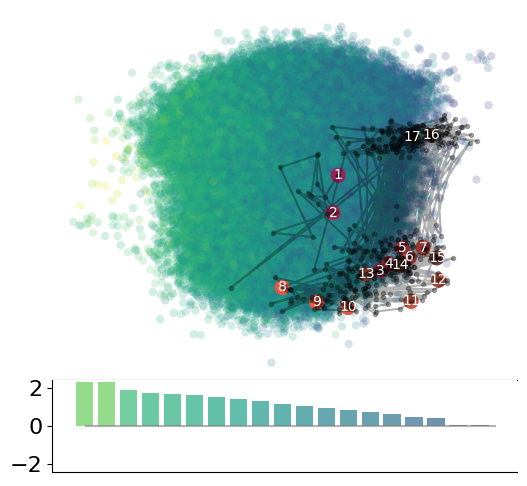

In [25]:
plot_full_sampling_path(search_space_to_run_sequences, 
                        search_space_to_run_data,
                        model, 
                        2, 
                        organizing_property,
                        run_space="pca20", 
                        colour_by=colour_by,
                        runN="run2",
                        fig=tstfig
)                        

68 MDRKNLSEEQIEQFVKLVEELGDKTFVADDLFNARNLRCILSYEFLLALGEQQKEFQGPKTLKILDNI
93 MSRPSELPKPLSKVIKGTFRHLRNLVNDYYNLHHDRRVRLAQLALRQPARRETSTIPIPDRTFSQRALAERITKERLTEQKLRPTKQSQYSLE
96 MSKPVSPLNPSKVSKWKLTRHRFMLEYNNDLHLDRCLRVAALQRRLAEATTTSSSNDFIPDPTIATILAGRLLAQRDRMRPQRHRPHRQGHQHRQR
93 MSRPKVPNLSPASAKFGTRHLRLLNVYPNNYLLRRRDVRALQRAQDARRQSITSPTPIDSPSFAHATLAERIRDRQLRQQATQHARTLKTPAQ
92 MSSARVPPKPSESKGKMRQYRRLLYELPNYLHRQRDVRAAEHQRRATDQRARHTSIPDFCFSFTETREATAVEARVTQWQRHQRYRQRYRMV
96 MVRRRSPPPNISARKGTPWNLLHLRLERLYYPEYRRRAVAERQRQRADRAIRTSTLTDFPFTVTVALQRALATLRLRLWRAWRDRQRWRRQRWQRR
96 MSRVSPPPKPVSKKRVTYRMYRRQVQLLHYNDLRRERVRRERQAPAARQVRATVTFITFTVTDTTAITLTLALLTTTLWRRRYRRQRRRWQRQPTD
96 MRVSVSPNPIPSKGKVKYYPRRQRMLLLNLDLRDRFLREVRARQERALATATARVTFFDFTITPAEATAATVTTTQRWRQWTRRYRDRQYRDQRRW
96 MRVSCRPNPIPSKARGKPYPVRQQRLLYLLNDLRRVFVERLERERAQARATTITVFTFTVFVTTTAMAAAMTTTTTTTTTWDRRRQRRQQRQRWQR
77 MRVNSVPPRPRIKMKVRRYYRVRQRQYLNLRPLRFERVARARLANAERAIARTTVFTVTDFTDTVTRARAATQQQQQ
77 MKVRCRPVNPSLKMKVRTYRPWMQRNLRLHLDRDLRFRVRAKRERAEKTATVTV

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


68 MDRKNLSEEQIEQFVKLVEELGDKTFVADDLFNARNLRCILSYEFLLALGEQQKEFQGPKTLKILDNI
93 MSRPSELPKPLSKVIKGTFRHLRNLVNDYYNLHHDRRVRLAQLALRQPARRETSTIPIPDRTFSQRALAERITKERLTEQKLRPTKQSQYSLE
96 MSKPVSPLNPSKVSKWKLTRHRFMLEYNNDLHLDRCLRVAALQRRLAEATTTSSSNDFIPDPTIATILAGRLLAQRDRMRPQRHRPHRQGHQHRQR
93 MSRPKVPNLSPASAKFGTRHLRLLNVYPNNYLLRRRDVRALQRAQDARRQSITSPTPIDSPSFAHATLAERIRDRQLRQQATQHARTLKTPAQ
92 MSSARVPPKPSESKGKMRQYRRLLYELPNYLHRQRDVRAAEHQRRATDQRARHTSIPDFCFSFTETREATAVEARVTQWQRHQRYRQRYRMV
96 MVRRRSPPPNISARKGTPWNLLHLRLERLYYPEYRRRAVAERQRQRADRAIRTSTLTDFPFTVTVALQRALATLRLRLWRAWRDRQRWRRQRWQRR
96 MSRVSPPPKPVSKKRVTYRMYRRQVQLLHYNDLRRERVRRERQAPAARQVRATVTFITFTVTDTTAITLTLALLTTTLWRRRYRRQRRRWQRQPTD
96 MRVSVSPNPIPSKGKVKYYPRRQRMLLLNLDLRDRFLREVRARQERALATATARVTFFDFTITPAEATAATVTTTQRWRQWTRRYRDRQYRDQRRW
96 MRVSCRPNPIPSKARGKPYPVRQQRLLYLLNDLRRVFVERLERERAQARATTITVFTFTVFVTTTAMAAAMTTTTTTTTTWDRRRQRRQQRQRWQR
77 MRVNSVPPRPRIKMKVRRYYRVRQRQYLNLRPLRFERVARARLANAERAIARTTVFTVTDFTDTVTRARAATQQQQQ
77 MKVRCRPVNPSLKMKVRTYRPWMQRNLRLHLDRDLRFRVRAKRERAEKTATVTV

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


68 MDRKNLSEEQIEQFVKLVEELGDKTFVADDLFNARNLRCILSYEFLLALGEQQKEFQGPKTLKILDNI
93 MSRPSELPKPLSKVIKGTFRHLRNLVNDYYNLHHDRRVRLAQLALRQPARRETSTIPIPDRTFSQRALAERITKERLTEQKLRPTKQSQYSLE
96 MSKPVSPLNPSKVSKWKLTRHRFMLEYNNDLHLDRCLRVAALQRRLAEATTTSSSNDFIPDPTIATILAGRLLAQRDRMRPQRHRPHRQGHQHRQR
93 MSRPKVPNLSPASAKFGTRHLRLLNVYPNNYLLRRRDVRALQRAQDARRQSITSPTPIDSPSFAHATLAERIRDRQLRQQATQHARTLKTPAQ
92 MSSARVPPKPSESKGKMRQYRRLLYELPNYLHRQRDVRAAEHQRRATDQRARHTSIPDFCFSFTETREATAVEARVTQWQRHQRYRQRYRMV
96 MVRRRSPPPNISARKGTPWNLLHLRLERLYYPEYRRRAVAERQRQRADRAIRTSTLTDFPFTVTVALQRALATLRLRLWRAWRDRQRWRRQRWQRR
96 MSRVSPPPKPVSKKRVTYRMYRRQVQLLHYNDLRRERVRRERQAPAARQVRATVTFITFTVTDTTAITLTLALLTTTLWRRRYRRQRRRWQRQPTD
96 MRVSVSPNPIPSKGKVKYYPRRQRMLLLNLDLRDRFLREVRARQERALATATARVTFFDFTITPAEATAATVTTTQRWRQWTRRYRDRQYRDQRRW
96 MRVSCRPNPIPSKARGKPYPVRQQRLLYLLNDLRRVFVERLERERAQARATTITVFTFTVFVTTTAMAAAMTTTTTTTTTWDRRRQRRQQRQRWQR
77 MRVNSVPPRPRIKMKVRRYYRVRQRQYLNLRPLRFERVARARLANAERAIARTTVFTVTDFTDTVTRARAATQQQQQ
77 MKVRCRPVNPSLKMKVRTYRPWMQRNLRLHLDRDLRFRVRAKRERAEKTATVTV

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


90 MPRPTGIPKFRHTKPISTMREFSKQLSIEAVYGRINHLEANLPELIESVNAYAKALASMLRTNLYLNSLNETLEKDSKARQNELKSQRKT
90 MPPETLVFTWTQHVSINASKTPISRLAKTVEKFGANRIPILEDKTLAVPEVLTARMLKSLTKLTSFYLDNLELTSVKEHKEQIRQENEKS
89 MPPLDAWPFSFKTISKSKQLTVAMDMQRGIRFINVEGIPQELTLVDEIEGSARMLIQKRISCLHFFTCKTLNLDELQLKQESQKEKEKE
97 MMVNLHRYWIFTQLATTSKSWFSDQRKQAKMATGYNPSVQFPRPSAAVKIAIFAIAIGLLPKRPQFPDKPAFETNPTITPTIPTTQIKIYQKIKPKI
90 MMGCPLRYFTYFYAQHTSVNGHDVMRKVKAKGNGNSTFDKKKDTANAVAAVAVTIIIFGLTKKKYPPRPDEPTPRGKGKNKTKGFTLTEK
97 MMPFVPYTLFYTQLTRDFTENNHRRERMVMRMDNGYHIPYPPKAEAASAVIVTIGVGFLLTLKYQQPNQPTNGKIKGKVKCKFHWHYLCLYLCNLNL
97 MGMVYHYCLHTTFTKAAFDNNWCNCSRQAIREIENCCYYHCQQQEAAAAIVIGVFFFNIIMQKLQLQQAYPGYPYGCYHCHLPRKALKKALIRIKII
97 MMYMYSYHFTHTLTATFATFNNNCRRRCMVAAPYYYNMHSKANAAKAIANAIGTIFLLLVKQQEMYEKPAYYMKPYGKKGKGKLFFKGKKKNWPKDH
97 MMMYYYHTFHTLTLTATTFTFNCRNRRVMVPPFMTYPYLQNRMIEVQIAGTIVIAFLTLKLPKQGKEYEMQMYGKPKGKKGKGCFKKGWKKKGKPSH
97 MGKMYHYHTFTFTLTLTTADNCKCNCKVERAATNPNHYFYKKMQIATAAMATAVCGFLLYAAQYQQKYEKTGKPNGKCGCKCGKKAKVKIKGKRSKI
86 MMKYPTHFHTLTTTAT

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


90 MPRPTGIPKFRHTKPISTMREFSKQLSIEAVYGRINHLEANLPELIESVNAYAKALASMLRTNLYLNSLNETLEKDSKARQNELKSQRKT
90 MPPETLVFTWTQHVSINASKTPISRLAKTVEKFGANRIPILEDKTLAVPEVLTARMLKSLTKLTSFYLDNLELTSVKEHKEQIRQENEKS
89 MPPLDAWPFSFKTISKSKQLTVAMDMQRGIRFINVEGIPQELTLVDEIEGSARMLIQKRISCLHFFTCKTLNLDELQLKQESQKEKEKE
97 MMVNLHRYWIFTQLATTSKSWFSDQRKQAKMATGYNPSVQFPRPSAAVKIAIFAIAIGLLPKRPQFPDKPAFETNPTITPTIPTTQIKIYQKIKPKI
90 MMGCPLRYFTYFYAQHTSVNGHDVMRKVKAKGNGNSTFDKKKDTANAVAAVAVTIIIFGLTKKKYPPRPDEPTPRGKGKNKTKGFTLTEK
97 MMPFVPYTLFYTQLTRDFTENNHRRERMVMRMDNGYHIPYPPKAEAASAVIVTIGVGFLLTLKYQQPNQPTNGKIKGKVKCKFHWHYLCLYLCNLNL
97 MGMVYHYCLHTTFTKAAFDNNWCNCSRQAIREIENCCYYHCQQQEAAAAIVIGVFFFNIIMQKLQLQQAYPGYPYGCYHCHLPRKALKKALIRIKII
97 MMYMYSYHFTHTLTATFATFNNNCRRRCMVAAPYYYNMHSKANAAKAIANAIGTIFLLLVKQQEMYEKPAYYMKPYGKKGKGKLFFKGKKKNWPKDH
97 MMMYYYHTFHTLTLTATTFTFNCRNRRVMVPPFMTYPYLQNRMIEVQIAGTIVIAFLTLKLPKQGKEYEMQMYGKPKGKKGKGCFKKGWKKKGKPSH
97 MGKMYHYHTFTFTLTLTTADNCKCNCKVERAATNPNHYFYKKMQIATAAMATAVCGFLLYAAQYQQKYEKTGKPNGKCGCKCGKKAKVKIKGKRSKI
86 MMKYPTHFHTLTTTAT

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


90 MPRPTGIPKFRHTKPISTMREFSKQLSIEAVYGRINHLEANLPELIESVNAYAKALASMLRTNLYLNSLNETLEKDSKARQNELKSQRKT
90 MPPETLVFTWTQHVSINASKTPISRLAKTVEKFGANRIPILEDKTLAVPEVLTARMLKSLTKLTSFYLDNLELTSVKEHKEQIRQENEKS
89 MPPLDAWPFSFKTISKSKQLTVAMDMQRGIRFINVEGIPQELTLVDEIEGSARMLIQKRISCLHFFTCKTLNLDELQLKQESQKEKEKE
97 MMVNLHRYWIFTQLATTSKSWFSDQRKQAKMATGYNPSVQFPRPSAAVKIAIFAIAIGLLPKRPQFPDKPAFETNPTITPTIPTTQIKIYQKIKPKI
90 MMGCPLRYFTYFYAQHTSVNGHDVMRKVKAKGNGNSTFDKKKDTANAVAAVAVTIIIFGLTKKKYPPRPDEPTPRGKGKNKTKGFTLTEK
97 MMPFVPYTLFYTQLTRDFTENNHRRERMVMRMDNGYHIPYPPKAEAASAVIVTIGVGFLLTLKYQQPNQPTNGKIKGKVKCKFHWHYLCLYLCNLNL
97 MGMVYHYCLHTTFTKAAFDNNWCNCSRQAIREIENCCYYHCQQQEAAAAIVIGVFFFNIIMQKLQLQQAYPGYPYGCYHCHLPRKALKKALIRIKII
97 MMYMYSYHFTHTLTATFATFNNNCRRRCMVAAPYYYNMHSKANAAKAIANAIGTIFLLLVKQQEMYEKPAYYMKPYGKKGKGKLFFKGKKKNWPKDH
97 MMMYYYHTFHTLTLTATTFTFNCRNRRVMVPPFMTYPYLQNRMIEVQIAGTIVIAFLTLKLPKQGKEYEMQMYGKPKGKKGKGCFKKGWKKKGKPSH
97 MGKMYHYHTFTFTLTLTTADNCKCNCKVERAATNPNHYFYKKMQIATAAMATAVCGFLLYAAQYQQKYEKTGKPNGKCGCKCGKKAKVKIKGKRSKI
86 MMKYPTHFHTLTTTAT

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


68 MRPDELKNEEIQRIIWIEALDADVYTGDIGSNIRNWSTLLFNGIRLLEVNKQGQLTLDKRHIVEHALG
96 MAMYKSGQLKFQQSRDVDKLRKRLWFPLDLLQYRLRACPEMARGEPMQCNECERRKRNGPDGERQVNVRRACQGRATAVDANGISEYLSWEMSRPL
96 MMSKPISKQVPNKCITRFARPRHNHYLNFNCSSQRCTSRWALFGLERADRWLELLGNIGYAYPKSKPRNCLRECGLRLGEWDLLDCEKSLYVKLSM
96 MTFFPFNATKQKRNFIALVSRHTHHNCNFNNFSRATRCHSNSCSGGKAGIKRKDIHDGELNRLCSKSVPRYSKGYCLYEWECEYLRIYCQKCSMQC
88 MKFSFYFQHGTQSATFLFRARLHHLNHNFYCNSSCSLTHTCSFVSFAGEKRQRVIIDFYGKKQPQRQLSRYPFRPHRFRGRFIFYFFF
96 MMFSYFPKAKHTPLCFEFRTSKLHHNNLFYFCNSLSCRSLMFFFVVISKKQITKIRICYIKRKTTQSKSLYRCHCFCYFKVYGKFTLFKILFKFTY
89 MSWKFPFNNQRLRISIRSRCRRQHTHNNNYNCCLSPLSTCFMYSFTKENIKAGIYFRRYRTKKSKPLLLYTRRYVICTVLFYCYFRFWF
94 MKSFWFSSLKQLFLKFVCTLTRTHNHNHNNFNRSTSHSCRCSCFFMATQQNIKGFRFTFRRYTMTYTPHTYLYSKFTIVFKLGLFKVLVKVAVK
96 MPITFNPERHRSKLIRCFRRLQLQHHNLNNFSYSSHSCLCSLYFIKSKTKKSFKIRFTGKYTRTHHTYKPTYPLFFLIFTVFVLFKFCLKVCKCKL

MEVNHIQKPELELRFKEIISKMIHYIEFEKSPLDLLNGKEFVEVQEFEQEVKNLKDLEGARDIKYGIYQ
mols_data.shape=torch.Size([9, 127]), props_data.shape=torch.Size([9, 1])


/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


68 MRPDELKNEEIQRIIWIEALDADVYTGDIGSNIRNWSTLLFNGIRLLEVNKQGQLTLDKRHIVEHALG
96 MAMYKSGQLKFQQSRDVDKLRKRLWFPLDLLQYRLRACPEMARGEPMQCNECERRKRNGPDGERQVNVRRACQGRATAVDANGISEYLSWEMSRPL
96 MMSKPISKQVPNKCITRFARPRHNHYLNFNCSSQRCTSRWALFGLERADRWLELLGNIGYAYPKSKPRNCLRECGLRLGEWDLLDCEKSLYVKLSM
96 MTFFPFNATKQKRNFIALVSRHTHHNCNFNNFSRATRCHSNSCSGGKAGIKRKDIHDGELNRLCSKSVPRYSKGYCLYEWECEYLRIYCQKCSMQC
88 MKFSFYFQHGTQSATFLFRARLHHLNHNFYCNSSCSLTHTCSFVSFAGEKRQRVIIDFYGKKQPQRQLSRYPFRPHRFRGRFIFYFFF
96 MMFSYFPKAKHTPLCFEFRTSKLHHNNLFYFCNSLSCRSLMFFFVVISKKQITKIRICYIKRKTTQSKSLYRCHCFCYFKVYGKFTLFKILFKFTY
89 MSWKFPFNNQRLRISIRSRCRRQHTHNNNYNCCLSPLSTCFMYSFTKENIKAGIYFRRYRTKKSKPLLLYTRRYVICTVLFYCYFRFWF
94 MKSFWFSSLKQLFLKFVCTLTRTHNHNHNNFNRSTSHSCRCSCFFMATQQNIKGFRFTFRRYTMTYTPHTYLYSKFTIVFKLGLFKVLVKVAVK
96 MPITFNPERHRSKLIRCFRRLQLQHHNLNNFSYSSHSCLCSLYFIKSKTKKSFKIRFTGKYTRTHHTYKPTYPLFFLIFTVFVLFKFCLKVCKCKL

MEVNHIQKPELELRFKEIISKMIHYIEFEKSPLDLLNGKEFVEVQEFEQEVKNLKDLEGARDIKYGIYQ
mols_data.shape=torch.Size([9, 127]), props_data.shape=torch.Size([9, 1])


/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


68 MRPDELKNEEIQRIIWIEALDADVYTGDIGSNIRNWSTLLFNGIRLLEVNKQGQLTLDKRHIVEHALG
96 MAMYKSGQLKFQQSRDVDKLRKRLWFPLDLLQYRLRACPEMARGEPMQCNECERRKRNGPDGERQVNVRRACQGRATAVDANGISEYLSWEMSRPL
96 MMSKPISKQVPNKCITRFARPRHNHYLNFNCSSQRCTSRWALFGLERADRWLELLGNIGYAYPKSKPRNCLRECGLRLGEWDLLDCEKSLYVKLSM
96 MTFFPFNATKQKRNFIALVSRHTHHNCNFNNFSRATRCHSNSCSGGKAGIKRKDIHDGELNRLCSKSVPRYSKGYCLYEWECEYLRIYCQKCSMQC
88 MKFSFYFQHGTQSATFLFRARLHHLNHNFYCNSSCSLTHTCSFVSFAGEKRQRVIIDFYGKKQPQRQLSRYPFRPHRFRGRFIFYFFF
96 MMFSYFPKAKHTPLCFEFRTSKLHHNNLFYFCNSLSCRSLMFFFVVISKKQITKIRICYIKRKTTQSKSLYRCHCFCYFKVYGKFTLFKILFKFTY
89 MSWKFPFNNQRLRISIRSRCRRQHTHNNNYNCCLSPLSTCFMYSFTKENIKAGIYFRRYRTKKSKPLLLYTRRYVICTVLFYCYFRFWF
94 MKSFWFSSLKQLFLKFVCTLTRTHNHNHNNFNRSTSHSCRCSCFFMATQQNIKGFRFTFRRYTMTYTPHTYLYSKFTIVFKLGLFKVLVKVAVK
96 MPITFNPERHRSKLIRCFRRLQLQHHNLNNFSYSSHSCLCSLYFIKSKTKKSFKIRFTGKYTRTHHTYKPTYPLFFLIFTVFVLFKFCLKVCKCKL

MEVNHIQKPELELRFKEIISKMIHYIEFEKSPLDLLNGKEFVEVQEFEQEVKNLKDLEGARDIKYGIYQ
mols_data.shape=torch.Size([9, 127]), props_data.shape=torch.Size([9, 1])


/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MKNLGNVKKTLYSINLPRASPFNTQMVSLSEFQTPGIRLSKIKTKQFIELTRIKANVPILNANKLPNHLDSLDSPAYELGKRQGWILNLGDL
96 MKKHSEKFHTKLPLISKASKNLTNNTQIAPSLYTKILSGELYANVQKIRPASAVIRNYRESHIKNRCDSRDKNPAHNHPKNFGHVYLFLFHDCSLG
96 HQVRVPAYLKYVKKLRSARINNTHTMQAIRHTTTIEKARIRLYIEKKRQLNLLIRLRLQEPKYKYIILSYIREEKNIHNELPNVLFCFKVLPSLFK
96 MQKKKVAINTYWLHLAIIENNHTTIEIQRMLTKTNQAIAGKGIKIAKGASSSAIEASSTNTGNKTKKGSKKNKQKANKNNVNSSSSPSASAKSPAK
97 MQKKRVAIDYHGWLLAIEENHYTIIQIMSLHTKINKAEGTLTATAKAGISAKEIVSSSNTKTIKNKKSKAQNKQANKAGNAKNSKNSIYAIYIIGDG
96 MQKQKAVVIYHGKVLLIQINNMLTQIQIIHRHFTQEASKIFKGAIQTKAAGATIAIENISTKGKTSSKNAKNQSKNKQNKDIGSIISGISIKNSKA
96 MQKQAAVTTGNWKLVAEENNHNTTIQMQILMTHTIEAIKFKVASKNAAKASVNAAINVSNKSNKKDKKNPKNAQNKNQSSSDVATSAYISAKKSKN
96 MQQKVGIGDNFLKLLMAEENNHTNIQAIRLHTTMAESSGVKTVKIASKANKAVKISEDSTAKNTKNKKTNQSQSNKANKNSDKIGIFKTVSKTGNK
92 MQQKDKGIITKWKRLANEIENNTHMIEQALLTHSSNAIAGFFHTAAAEAFTKKAINNDSSSKTKTNKKNQQKANKNKTKTATASNASIAINE
97 MQQKVGAVKNTWLRLAMENNQNMNMAIQRHFHTKAEIAKTLTKVAAKASKTLAEISIDKTSKTKTTKKNKQNAEKNAKANKDKTATKTVKTTVKDKF
97 MQQ

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MKNLGNVKKTLYSINLPRASPFNTQMVSLSEFQTPGIRLSKIKTKQFIELTRIKANVPILNANKLPNHLDSLDSPAYELGKRQGWILNLGDL
96 MKKHSEKFHTKLPLISKASKNLTNNTQIAPSLYTKILSGELYANVQKIRPASAVIRNYRESHIKNRCDSRDKNPAHNHPKNFGHVYLFLFHDCSLG
96 HQVRVPAYLKYVKKLRSARINNTHTMQAIRHTTTIEKARIRLYIEKKRQLNLLIRLRLQEPKYKYIILSYIREEKNIHNELPNVLFCFKVLPSLFK
96 MQKKKVAINTYWLHLAIIENNHTTIEIQRMLTKTNQAIAGKGIKIAKGASSSAIEASSTNTGNKTKKGSKKNKQKANKNNVNSSSSPSASAKSPAK
97 MQKKRVAIDYHGWLLAIEENHYTIIQIMSLHTKINKAEGTLTATAKAGISAKEIVSSSNTKTIKNKKSKAQNKQANKAGNAKNSKNSIYAIYIIGDG
96 MQKQKAVVIYHGKVLLIQINNMLTQIQIIHRHFTQEASKIFKGAIQTKAAGATIAIENISTKGKTSSKNAKNQSKNKQNKDIGSIISGISIKNSKA
96 MQKQAAVTTGNWKLVAEENNHNTTIQMQILMTHTIEAIKFKVASKNAAKASVNAAINVSNKSNKKDKKNPKNAQNKNQSSSDVATSAYISAKKSKN
96 MQQKVGIGDNFLKLLMAEENNHTNIQAIRLHTTMAESSGVKTVKIASKANKAVKISEDSTAKNTKNKKTNQSQSNKANKNSDKIGIFKTVSKTGNK
92 MQQKDKGIITKWKRLANEIENNTHMIEQALLTHSSNAIAGFFHTAAAEAFTKKAINNDSSSKTKTNKKNQQKANKNKTKTATASNASIAINE
97 MQQKVGAVKNTWLRLAMENNQNMNMAIQRHFHTKAEIAKTLTKVAAKASKTLAEISIDKTSKTKTTKKNKQNAEKNAKANKDKTATKTVKTTVKDKF
97 MQQ

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MKNLGNVKKTLYSINLPRASPFNTQMVSLSEFQTPGIRLSKIKTKQFIELTRIKANVPILNANKLPNHLDSLDSPAYELGKRQGWILNLGDL
96 MKKHSEKFHTKLPLISKASKNLTNNTQIAPSLYTKILSGELYANVQKIRPASAVIRNYRESHIKNRCDSRDKNPAHNHPKNFGHVYLFLFHDCSLG
96 HQVRVPAYLKYVKKLRSARINNTHTMQAIRHTTTIEKARIRLYIEKKRQLNLLIRLRLQEPKYKYIILSYIREEKNIHNELPNVLFCFKVLPSLFK
96 MQKKKVAINTYWLHLAIIENNHTTIEIQRMLTKTNQAIAGKGIKIAKGASSSAIEASSTNTGNKTKKGSKKNKQKANKNNVNSSSSPSASAKSPAK
97 MQKKRVAIDYHGWLLAIEENHYTIIQIMSLHTKINKAEGTLTATAKAGISAKEIVSSSNTKTIKNKKSKAQNKQANKAGNAKNSKNSIYAIYIIGDG
96 MQKQKAVVIYHGKVLLIQINNMLTQIQIIHRHFTQEASKIFKGAIQTKAAGATIAIENISTKGKTSSKNAKNQSKNKQNKDIGSIISGISIKNSKA
96 MQKQAAVTTGNWKLVAEENNHNTTIQMQILMTHTIEAIKFKVASKNAAKASVNAAINVSNKSNKKDKKNPKNAQNKNQSSSDVATSAYISAKKSKN
96 MQQKVGIGDNFLKLLMAEENNHTNIQAIRLHTTMAESSGVKTVKIASKANKAVKISEDSTAKNTKNKKTNQSQSNKANKNSDKIGIFKTVSKTGNK
92 MQQKDKGIITKWKRLANEIENNTHMIEQALLTHSSNAIAGFFHTAAAEAFTKKAINNDSSSKTKTNKKNQQKANKNKTKTATASNASIAINE
97 MQQKVGAVKNTWLRLAMENNQNMNMAIQRHFHTKAEIAKTLTKVAAKASKTLAEISIDKTSKTKTTKKNKQNAEKNAKANKDKTATKTVKTTVKDKF
97 MQQ

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MNATNIVRTFPMITADGTKRRWMRTAMANLHDDLNANSSNKSLELGLFDFISEFIKEVQKNLNEQLGKTLEKKRSGNISSYLSGLQKNLLRK
92 MPELNVNFKGFRSYEALHKDHIYKSELKINYFILNGLNSHTKKTLVKIHFITTIKTALNLSGIINKNPRQQNKEIVSSFYMLEGRLQRELEK
92 MPNVRGINSLFNKFIQTLPAWIYPEKLTELFDLNSVTFNLSKNKIILNPVSKIITKNLLGKNGINPMLQNKKARENGNLYFSGSIKKAQQIL
90 PNPAKIYIPKAYYALNKSPCHISSLKNPATKYINLTPNPKLQRIEKLFSIMLEATASTMTNIQEYLKNLLQQKEKRDRYGWTKVAAEAIQ
90 PNKLLITFNKLGYLTLKHTFYFVSKKSNKTLTDFMQHQPPQTKAMALSFNILEIKKIPESDEQYIQHLKKEKQIKNNTYKWLIKIAAEAQ
91 PPPQITWASQIYYQYPQPTPYYALTSPVKKSITDSMKPNFKIMQKGGLYLKIIKKEWTGEIKQNIYKYPYQQKKMKQKWPWSEIEEIEAEA
91 PKPIPASFTLITGTNQHVKTCFYMSKSPLLLTGSLKPKKHKISQEKACFYIKEIKENFIIEQNQQKNPNQEMMQKKKPHHSYIIIEEQKEA
91 PKPIKSFKVSDQINSSKTPIWYISPSLPTLPIGLSKKPKPYAKEMAKYCGILQITQIYVTEQQQKNRNNQMQQKKPKKHYFSLIEEEQAEA
91 PPFAAIIWSQSYNIYARQPWSYVAPWPLLSLMGCPLQKHPRKEQAKIWCSTKKTINIYVNTQNNNNNNMQIQQQKHHHTHGIGIIKEIQAA
91 MPFKGAFTSSTKDVSNKPNWGSAVPLGPKKYIYPKQKPLFLNNQLAISFGLLQEITGYINTRRMQNGYTKQQQQNNHHSWCCIIAAAAQAK
91 FPKIQYFTFYAITYPNPKKLWYILPAKKFKNNIKLKLKPVLQNKKI

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MNATNIVRTFPMITADGTKRRWMRTAMANLHDDLNANSSNKSLELGLFDFISEFIKEVQKNLNEQLGKTLEKKRSGNISSYLSGLQKNLLRK
92 MPELNVNFKGFRSYEALHKDHIYKSELKINYFILNGLNSHTKKTLVKIHFITTIKTALNLSGIINKNPRQQNKEIVSSFYMLEGRLQRELEK
92 MPNVRGINSLFNKFIQTLPAWIYPEKLTELFDLNSVTFNLSKNKIILNPVSKIITKNLLGKNGINPMLQNKKARENGNLYFSGSIKKAQQIL
90 PNPAKIYIPKAYYALNKSPCHISSLKNPATKYINLTPNPKLQRIEKLFSIMLEATASTMTNIQEYLKNLLQQKEKRDRYGWTKVAAEAIQ
90 PNKLLITFNKLGYLTLKHTFYFVSKKSNKTLTDFMQHQPPQTKAMALSFNILEIKKIPESDEQYIQHLKKEKQIKNNTYKWLIKIAAEAQ
91 PPPQITWASQIYYQYPQPTPYYALTSPVKKSITDSMKPNFKIMQKGGLYLKIIKKEWTGEIKQNIYKYPYQQKKMKQKWPWSEIEEIEAEA
91 PKPIPASFTLITGTNQHVKTCFYMSKSPLLLTGSLKPKKHKISQEKACFYIKEIKENFIIEQNQQKNPNQEMMQKKKPHHSYIIIEEQKEA
91 PKPIKSFKVSDQINSSKTPIWYISPSLPTLPIGLSKKPKPYAKEMAKYCGILQITQIYVTEQQQKNRNNQMQQKKPKKHYFSLIEEEQAEA
91 PPFAAIIWSQSYNIYARQPWSYVAPWPLLSLMGCPLQKHPRKEQAKIWCSTKKTINIYVNTQNNNNNNMQIQQQKHHHTHGIGIIKEIQAA
91 MPFKGAFTSSTKDVSNKPNWGSAVPLGPKKYIYPKQKPLFLNNQLAISFGLLQEITGYINTRRMQNGYTKQQQQNNHHSWCCIIAAAAQAK
91 FPKIQYFTFYAITYPNPKKLWYILPAKKFKNNIKLKLKPVLQNKKI

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MNATNIVRTFPMITADGTKRRWMRTAMANLHDDLNANSSNKSLELGLFDFISEFIKEVQKNLNEQLGKTLEKKRSGNISSYLSGLQKNLLRK
92 MPELNVNFKGFRSYEALHKDHIYKSELKINYFILNGLNSHTKKTLVKIHFITTIKTALNLSGIINKNPRQQNKEIVSSFYMLEGRLQRELEK
92 MPNVRGINSLFNKFIQTLPAWIYPEKLTELFDLNSVTFNLSKNKIILNPVSKIITKNLLGKNGINPMLQNKKARENGNLYFSGSIKKAQQIL
90 PNPAKIYIPKAYYALNKSPCHISSLKNPATKYINLTPNPKLQRIEKLFSIMLEATASTMTNIQEYLKNLLQQKEKRDRYGWTKVAAEAIQ
90 PNKLLITFNKLGYLTLKHTFYFVSKKSNKTLTDFMQHQPPQTKAMALSFNILEIKKIPESDEQYIQHLKKEKQIKNNTYKWLIKIAAEAQ
91 PPPQITWASQIYYQYPQPTPYYALTSPVKKSITDSMKPNFKIMQKGGLYLKIIKKEWTGEIKQNIYKYPYQQKKMKQKWPWSEIEEIEAEA
91 PKPIPASFTLITGTNQHVKTCFYMSKSPLLLTGSLKPKKHKISQEKACFYIKEIKENFIIEQNQQKNPNQEMMQKKKPHHSYIIIEEQKEA
91 PKPIKSFKVSDQINSSKTPIWYISPSLPTLPIGLSKKPKPYAKEMAKYCGILQITQIYVTEQQQKNRNNQMQQKKPKKHYFSLIEEEQAEA
91 PPFAAIIWSQSYNIYARQPWSYVAPWPLLSLMGCPLQKHPRKEQAKIWCSTKKTINIYVNTQNNNNNNMQIQQQKHHHTHGIGIIKEIQAA
91 MPFKGAFTSSTKDVSNKPNWGSAVPLGPKKYIYPKQKPLFLNNQLAISFGLLQEITGYINTRRMQNGYTKQQQQNNHHSWCCIIAAAAQAK
91 FPKIQYFTFYAITYPNPKKLWYILPAKKFKNNIKLKLKPVLQNKKI

/tmp/ipykernel_133313/3573388426.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


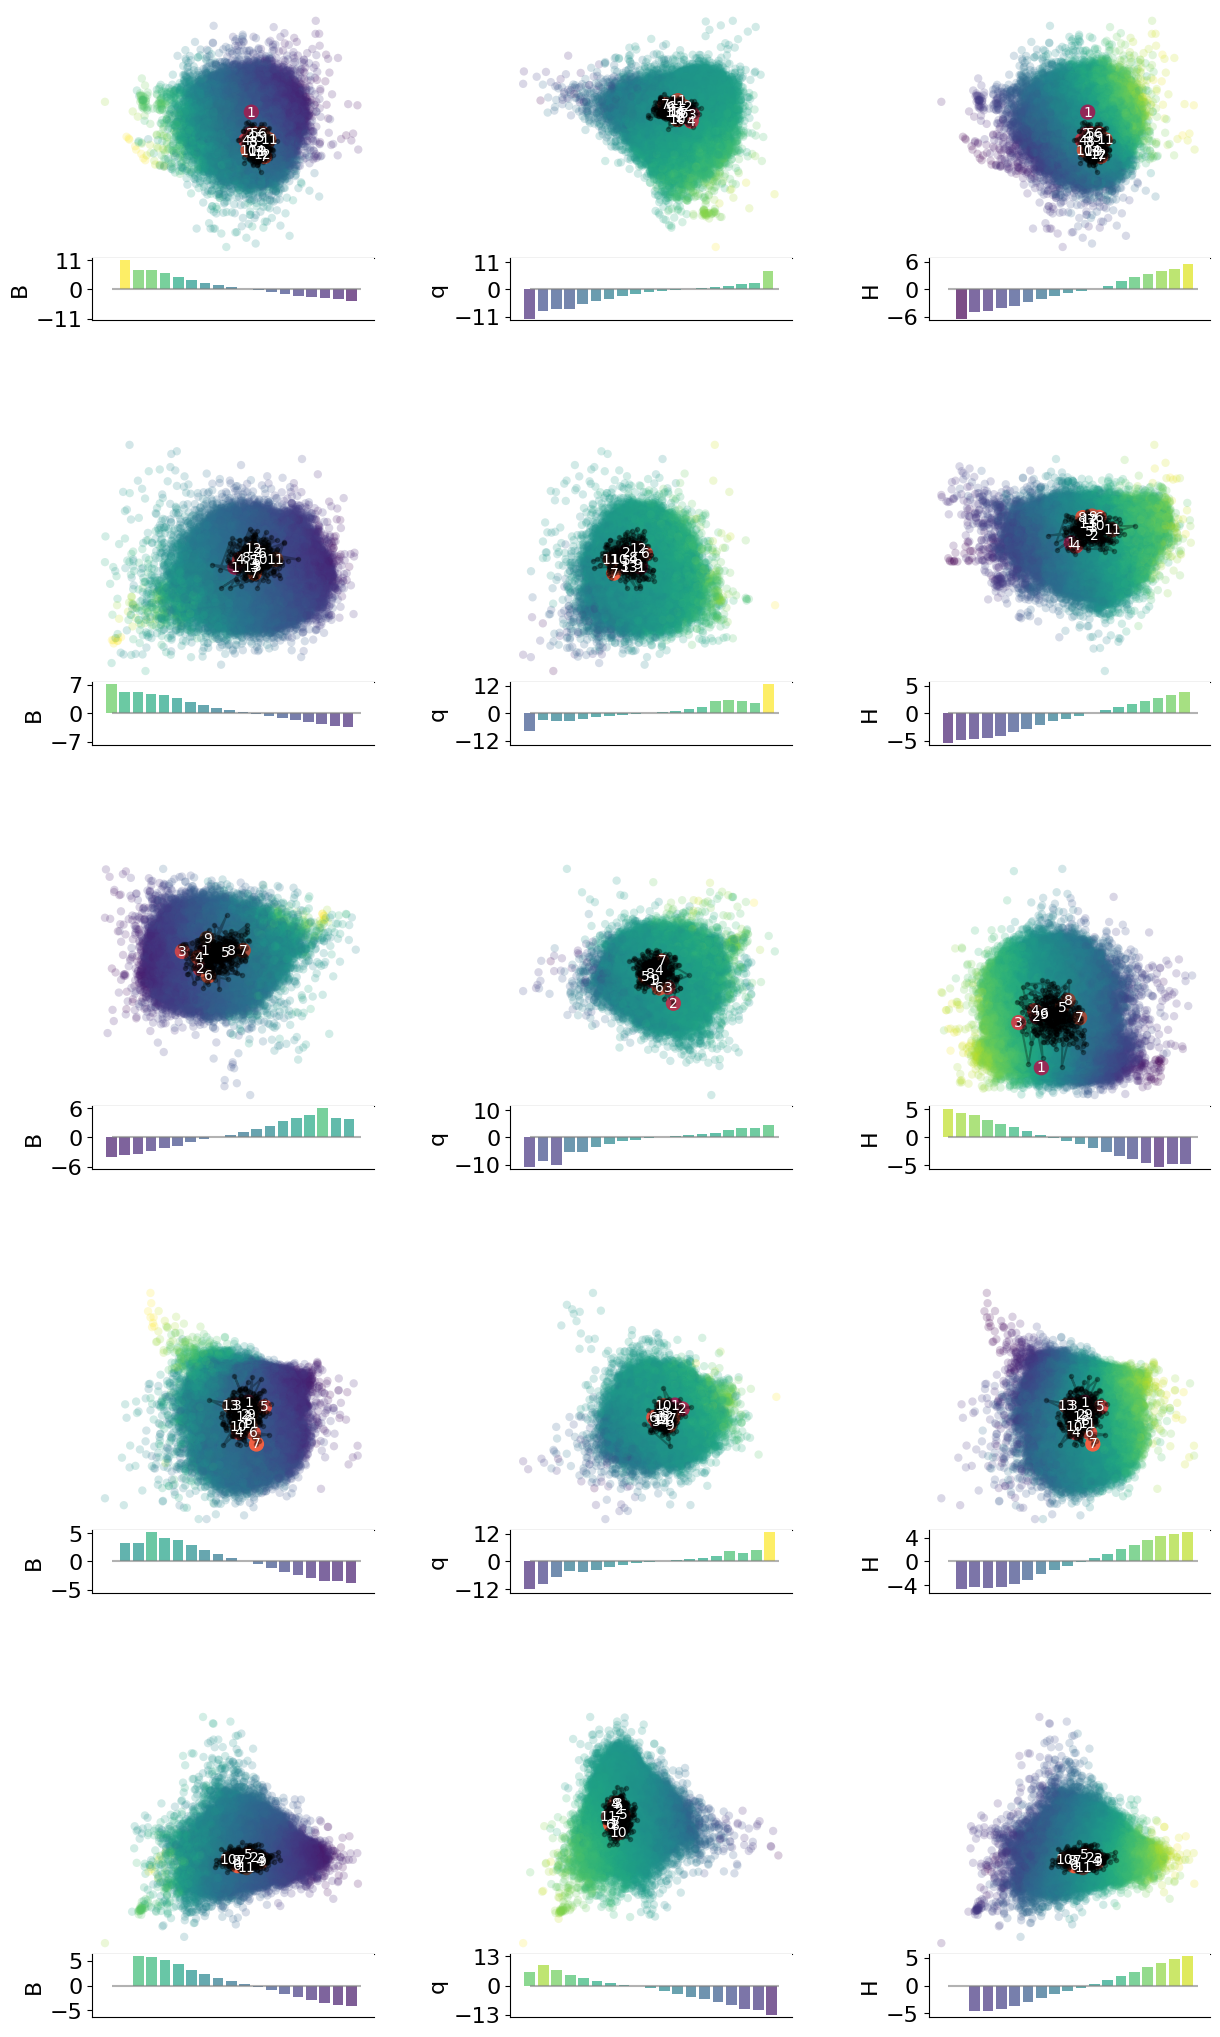

In [26]:
superfig_bayesopt_trajs = plt.figure(figsize=(12,21))
subfigs_bayesopt_trajs  = superfig_bayesopt_trajs.subfigures(5, 3, wspace=0.15, hspace=0.05)

percentages = [0,25,50,75,98]
organizing_property = "bch"
run_space = "Id"
for ix, _perc in enumerate(percentages):
    organizing_perc = 100-_perc
    for jx, _prop in enumerate(["boman", "charge", "hydrophobicity"]):

        sf = subfigs_bayesopt_trajs[ix, jx]

        sf = plot_full_sampling_path(search_space_to_run_sequences, 
                                search_space_to_run_data,
                                model, 
                                organizing_perc, 
                                organizing_property,
                                run_space=run_space, 
                                colour_by=_prop,
                                fig=sf
        )                       

In [27]:
subpanel_to_letter = {
    (0,0):"a.",
    (1,0):"b.",
    (2,0):"c.",
    (3,0):"d.",
    (4,0):"e.",
    (0,1):"f.",
    (1,1):"g.",
    (2,1):"h.",
    (3,1):"i.",
    (4,1):"j.",
}

68 MDRKNLSEEQIEQFVKLVEELGDKTFVADDLFNARNLRCILSYEFLLALGEQQKEFQGPKTLKILDNI
93 MSRPSELPKPLSKVIKGTFRHLRNLVNDYYNLHHDRRVRLAQLALRQPARRETSTIPIPDRTFSQRALAERITKERLTEQKLRPTKQSQYSLE
96 MSKPVSPLNPSKVSKWKLTRHRFMLEYNNDLHLDRCLRVAALQRRLAEATTTSSSNDFIPDPTIATILAGRLLAQRDRMRPQRHRPHRQGHQHRQR
93 MSRPKVPNLSPASAKFGTRHLRLLNVYPNNYLLRRRDVRALQRAQDARRQSITSPTPIDSPSFAHATLAERIRDRQLRQQATQHARTLKTPAQ
92 MSSARVPPKPSESKGKMRQYRRLLYELPNYLHRQRDVRAAEHQRRATDQRARHTSIPDFCFSFTETREATAVEARVTQWQRHQRYRQRYRMV
96 MVRRRSPPPNISARKGTPWNLLHLRLERLYYPEYRRRAVAERQRQRADRAIRTSTLTDFPFTVTVALQRALATLRLRLWRAWRDRQRWRRQRWQRR
96 MSRVSPPPKPVSKKRVTYRMYRRQVQLLHYNDLRRERVRRERQAPAARQVRATVTFITFTVTDTTAITLTLALLTTTLWRRRYRRQRRRWQRQPTD
96 MRVSVSPNPIPSKGKVKYYPRRQRMLLLNLDLRDRFLREVRARQERALATATARVTFFDFTITPAEATAATVTTTQRWRQWTRRYRDRQYRDQRRW
96 MRVSCRPNPIPSKARGKPYPVRQQRLLYLLNDLRRVFVERLERERAQARATTITVFTFTVFVTTTAMAAAMTTTTTTTTTWDRRRQRRQQRQRWQR
77 MRVNSVPPRPRIKMKVRRYYRVRQRQYLNLRPLRFERVARARLANAERAIARTTVFTVTDFTDTVTRARAATQQQQQ
77 MKVRCRPVNPSLKMKVRTYRPWMQRNLRLHLDRDLRFRVRAKRERAEKTATVTV

/tmp/ipykernel_133313/1695988891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


col3='oracle'
95 MDKLVTMDNGSPTEDRLVLEWGEVTNIKGDPREIRLADFLEGPKTGELSYADMRSADTLVKLNGEMVRETLDKRPDKFKDLTPSGYIDSVLDRLV
95 MSYRQRPGDTAWFNARIPFRQRSPDRAYQVTRGINPRADRVQFHPRTQDRPVKDKVTKDKLSERMKHFTERKDTLNVEGYIEVDVEDFDISVPSL
95 MGRRGWCRGSRSWGFGSRWGAVRWVWSRSVWAGTSRCWRVAPGRRWPAWVRPSGERVTRTIRRVRLRQDRTPAPRLGDLIDSCPVAVDCPVSGEG
95 MGFRGCRGFGGSWVGFSGRWVVSWVWRSVGWVAFTRGFVGAGMRYRRFTVGPARPVAPRRVWASLRMRRLDTATLVLPCSDLVDVVCDVPVCLDT
94 MRRKKRKRTRTATRRTRLSLRFALRLTFKFTRKKKTFVRGTKHLTHPRHFRKVPVKMEKIRARRKRRHKYNNPEIEEVEVVMVVVDIVVVVVVD
95 MRKRKRKRATAFTARRTAFALFLRFKALFTTRTKALFSGTVTHLLHTRRYRVPAIKVEKIRKRRRPKRQYKPNPEIEIVVVIVVIVIVPVPIPIP
95 MKARKKAAAARAAKARASKAALAFARKKLAATATRLASALAFTKKLHTTAVRVLALALIKVKVRKRKRLKPQPEPIDEVVIVVIVVVIPVVVRIP
63 KKKKAKAKKARAKAKKARKALRAKSKLKAKRALTKLAKTARKLSALRLATRKALSQRAGARKR
79 KKAKKKAKAKAKKAKRAKARLAKRAKLRKAKKLTAKSTKATKALARLRLRALALRALSTLSATCRVTEAPAQAAKKKRK
64 MRWRRRFRWKFRSRWSFKFWFKKFFWKFLRFKFWLKFFKWSTFLFSLRLFTWLCKMCKRMCWRF
64 MRRRWRRWRSKRWSRFKWFKFKRFTKFWLRSFKWKFLRWSLFRFSLSKFLWTWCKMKCLCRRWR
79 MRRWR

/tmp/ipykernel_133313/1695988891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


col3='oracle'
90 MPRPTGIPKFRHTKPISTMREFSKQLSIEAVYGRINHLEANLPELIESVNAYAKALASMLRTNLYLNSLNETLEKDSKARQNELKSQRKT
90 MPPETLVFTWTQHVSINASKTPISRLAKTVEKFGANRIPILEDKTLAVPEVLTARMLKSLTKLTSFYLDNLELTSVKEHKEQIRQENEKS
89 MPPLDAWPFSFKTISKSKQLTVAMDMQRGIRFINVEGIPQELTLVDEIEGSARMLIQKRISCLHFFTCKTLNLDELQLKQESQKEKEKE
97 MMVNLHRYWIFTQLATTSKSWFSDQRKQAKMATGYNPSVQFPRPSAAVKIAIFAIAIGLLPKRPQFPDKPAFETNPTITPTIPTTQIKIYQKIKPKI
90 MMGCPLRYFTYFYAQHTSVNGHDVMRKVKAKGNGNSTFDKKKDTANAVAAVAVTIIIFGLTKKKYPPRPDEPTPRGKGKNKTKGFTLTEK
97 MMPFVPYTLFYTQLTRDFTENNHRRERMVMRMDNGYHIPYPPKAEAASAVIVTIGVGFLLTLKYQQPNQPTNGKIKGKVKCKFHWHYLCLYLCNLNL
97 MGMVYHYCLHTTFTKAAFDNNWCNCSRQAIREIENCCYYHCQQQEAAAAIVIGVFFFNIIMQKLQLQQAYPGYPYGCYHCHLPRKALKKALIRIKII
97 MMYMYSYHFTHTLTATFATFNNNCRRRCMVAAPYYYNMHSKANAAKAIANAIGTIFLLLVKQQEMYEKPAYYMKPYGKKGKGKLFFKGKKKNWPKDH
97 MMMYYYHTFHTLTLTATTFTFNCRNRRVMVPPFMTYPYLQNRMIEVQIAGTIVIAFLTLKLPKQGKEYEMQMYGKPKGKKGKGCFKKGWKKKGKPSH
97 MGKMYHYHTFTFTLTLTTADNCKCNCKVERAATNPNHYFYKKMQIATAAMATAVCGFLLYAAQYQQKYEKTGKPNGKCGCKCGKKAKVKIKGKRSKI
86 MM

/tmp/ipykernel_133313/1695988891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


col3='oracle'
90 MSPFNDSLHTVNSHSDVPMHFLTSNPDRMFHVHNAPNLDSFTRNPVQHVFPPTVEHVTPRNGTRRYCPARCTESGRTGNALNPVSGLSPS
18 RRARRRPRRRRRARARWA
29 RRPRRRARRRPRRARARARPAPRRARPAR
32 RSARLRRPRRARASRARARPARARPARAPRAR

MSPFNDSLHTVNSHSDVPMHFLTSNPDRMFHVHNAPNLDSFTRNPVQHVFPPTVEHVTPRNGTRRYCPARCTESGRTGNALNPVSGLSPS
mols_data.shape=torch.Size([4, 127]), props_data.shape=torch.Size([4, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_133313/1695988891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


col3='oracle'
68 MRPDELKNEEIQRIIWIEALDADVYTGDIGSNIRNWSTLLFNGIRLLEVNKQGQLTLDKRHIVEHALG
96 MAMYKSGQLKFQQSRDVDKLRKRLWFPLDLLQYRLRACPEMARGEPMQCNECERRKRNGPDGERQVNVRRACQGRATAVDANGISEYLSWEMSRPL
96 MMSKPISKQVPNKCITRFARPRHNHYLNFNCSSQRCTSRWALFGLERADRWLELLGNIGYAYPKSKPRNCLRECGLRLGEWDLLDCEKSLYVKLSM
96 MTFFPFNATKQKRNFIALVSRHTHHNCNFNNFSRATRCHSNSCSGGKAGIKRKDIHDGELNRLCSKSVPRYSKGYCLYEWECEYLRIYCQKCSMQC
88 MKFSFYFQHGTQSATFLFRARLHHLNHNFYCNSSCSLTHTCSFVSFAGEKRQRVIIDFYGKKQPQRQLSRYPFRPHRFRGRFIFYFFF
96 MMFSYFPKAKHTPLCFEFRTSKLHHNNLFYFCNSLSCRSLMFFFVVISKKQITKIRICYIKRKTTQSKSLYRCHCFCYFKVYGKFTLFKILFKFTY
89 MSWKFPFNNQRLRISIRSRCRRQHTHNNNYNCCLSPLSTCFMYSFTKENIKAGIYFRRYRTKKSKPLLLYTRRYVICTVLFYCYFRFWF
94 MKSFWFSSLKQLFLKFVCTLTRTHNHNHNNFNRSTSHSCRCSCFFMATQQNIKGFRFTFRRYTMTYTPHTYLYSKFTIVFKLGLFKVLVKVAVK
96 MPITFNPERHRSKLIRCFRRLQLQHHNLNNFSYSSHSCLCSLYFIKSKTKKSFKIRFTGKYTRTHHTYKPTYPLFFLIFTVFVLFKFCLKVCKCKL

MEVNHIQKPELELRFKEIISKMIHYIEFEKSPLDLLNGKEFVEVQEFEQEVKNLKDLEGARDIKYGIYQ
mols_data.shape=torch.Size([9, 127]), props_data.shape=torch

/tmp/ipykernel_133313/1695988891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


col3='oracle'
96 MKLYSKRYHEERFHNRSKNGKLKDHLFERNLKDMKEWLFTDKNKWLERSIYRWDRNLKELDPEREKFHDHYSKKDKCDLSKDLLKELVPSRTKAPI
96 MVAKVARKVAVEKVKAKRAKGERARKAKGEVRAERRGERKAGERGKTERGIRERDRREPEREAEEWAREWHRPDGERAGDRRELEARQGARAPARR
71 VKVARVKVVKEVKVKAKRKAREGRKAKARVEGKKVEREVERREGAKREREAGTAREREKDKRAAAATAEER
41 VKVVRARKVGKVKAKVKRERKAKVKEVKRAVERGREKAEVR
41 VRVKVVRVKGVKVKVKVKRAGRKRAGRKVVERVGRKARAGR
96 MVRVVRVRGVIWVVKVVKIKVFKVKVKAMFRIGKIRVKRGGERFGLARLGRIGKRDLRDVEALGKPTERFRPVKIVDTAVERAIAAEVEALAKGAT
71 MRVCRRWVVWVIRWVKVKFRMKVKYVRICKFKVKYVTFGRRIGKNRRFTILGVSLKRNGCTGIVATARINP
71 MRRVWVRIWRIKVWVIKKVYRKIKFRTVYKIFKKVKDRRIFTKSKFKRECIEVTVNNYRGTVVEAARAANG
42 MRVCRVWRVWVVKFRMVRKCGVKRCKFVRTWVYVRRFTVKGC
71 MCRRCVWCWVFVRMCKCVFKMVMKCYCVRLFKVCPYRGRVGRGLYLFTCTILVFALPRYRGVVTSVATSKF
71 MCRCWCRWVWFCRMRYVCKFMMKCYRLCICKCYGKCTFTRYVFLKYLVLGTFTLVPFPRKFRVVATAASRS

MKLYSKRYHEERFHNRSKNGKLKDHLFERNLKDMKEWLFTDKNKWLERSIYRWDRNLKELDPEREKFHDHYSKKDKCDLSKDLLKELVPSRTKAPI
mols_data.shape=torch.Size([11, 127]), props_data.shape=torch.Size([11, 1])
m

/tmp/ipykernel_133313/1695988891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


col3='oracle'
92 MKNLGNVKKTLYSINLPRASPFNTQMVSLSEFQTPGIRLSKIKTKQFIELTRIKANVPILNANKLPNHLDSLDSPAYELGKRQGWILNLGDL
96 MKKHSEKFHTKLPLISKASKNLTNNTQIAPSLYTKILSGELYANVQKIRPASAVIRNYRESHIKNRCDSRDKNPAHNHPKNFGHVYLFLFHDCSLG
96 HQVRVPAYLKYVKKLRSARINNTHTMQAIRHTTTIEKARIRLYIEKKRQLNLLIRLRLQEPKYKYIILSYIREEKNIHNELPNVLFCFKVLPSLFK
96 MQKKKVAINTYWLHLAIIENNHTTIEIQRMLTKTNQAIAGKGIKIAKGASSSAIEASSTNTGNKTKKGSKKNKQKANKNNVNSSSSPSASAKSPAK
97 MQKKRVAIDYHGWLLAIEENHYTIIQIMSLHTKINKAEGTLTATAKAGISAKEIVSSSNTKTIKNKKSKAQNKQANKAGNAKNSKNSIYAIYIIGDG
96 MQKQKAVVIYHGKVLLIQINNMLTQIQIIHRHFTQEASKIFKGAIQTKAAGATIAIENISTKGKTSSKNAKNQSKNKQNKDIGSIISGISIKNSKA
96 MQKQAAVTTGNWKLVAEENNHNTTIQMQILMTHTIEAIKFKVASKNAAKASVNAAINVSNKSNKKDKKNPKNAQNKNQSSSDVATSAYISAKKSKN
96 MQQKVGIGDNFLKLLMAEENNHTNIQAIRLHTTMAESSGVKTVKIASKANKAVKISEDSTAKNTKNKKTNQSQSNKANKNSDKIGIFKTVSKTGNK
92 MQQKDKGIITKWKRLANEIENNTHMIEQALLTHSSNAIAGFFHTAAAEAFTKKAINNDSSSKTKTNKKNQQKANKNKTKTATASNASIAINE
97 MQQKVGAVKNTWLRLAMENNQNMNMAIQRHFHTKAEIAKTLTKVAAKASKTLAEISIDKTSKTKTTKKNKQNAEKNAKANKDKTATKTVK

/tmp/ipykernel_133313/1695988891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


col3='oracle'
96 MSKPDMKVPATHILDHIRFSNLEGCGELSPDLKGSGELNTLRGIPNLLDLNRSLNVKGTIKPREDLRVGNLIPEYRDYNTQFPKFSFGLTFSLFNV
96 FFLFILFLGPVSKAGLGENKVQCAIEHVHVPEVRGPAPVNGLARDGIKPAGIKLAYEYRLDRAMGLARRLARQLAQEQEEEAEEAIEAIQKSYAKQ
96 LFLLCLLLLRGGKRVRRGAPKSRLARSGNLRLPALAYAKGPLAAVGHAPVRGIGRPLIKPGACAARLLRLRQARAEQREEEAEIEAIEAMQGRLAP
96 MRWRWLRRKKRCRRSRRKPLLKQRVRRYRSKRVRHAGGPARLPRGVAHAPGAGKACAHPDLKAKARLRLARQLAQEQEPEQAEEQVEQVMQIGQGA
96 MQRQRHRRLRRCAKRLLGLSWRLLLVKKRCSLRGLSRRGGAGLRGKLPIAGLRLPPGRPVPRAVRKARRALAAPAEPENQPEQKIQQIPEVLIYIE
96 MQQRQRRRWRLRSLRLCLLLRLCLLRLGRGGRWVRRLGSRVRWLLPVAPRVLKGRCPAPKVAGKRARRAALAATNNANQPAPQQPANAPITITTAG
96 MQQRQRHRRRWRSRRCRCLRLWLRLWGRVRHWLVRKRGRVKRCRGKAGSLKVRKPCRPLPATARKRARAKAVAPTPENQQPQPAPPATPATTNTAV
96 MQQRQRHRRWRLRSRCLWLLLRCLWLRVRGWKGWRVRALKCGRRCVRASGKGLKKVHPRVPVRKARRRARAAVAPANQNQNPQQEPAPIAPIATAT
96 MQHRRHRWRWRCRLHLCLWLLWLWLCLRCRGWCRLKLGRGKCRLGLKSGKGVLRKCPPKPVRVRRSRRRAKVAPAPINNQQPAPQPIQTITATITK
67 MQRRRQRRHRRRKRRSRWRGRRLRLKRSCRRAKLKLSKRGKALPRRLPSGLPLARPACPATKQLWLT

MFFVYVFLSFIGYL

/tmp/ipykernel_133313/1695988891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


col3='oracle'
92 MNATNIVRTFPMITADGTKRRWMRTAMANLHDDLNANSSNKSLELGLFDFISEFIKEVQKNLNEQLGKTLEKKRSGNISSYLSGLQKNLLRK
92 MPELNVNFKGFRSYEALHKDHIYKSELKINYFILNGLNSHTKKTLVKIHFITTIKTALNLSGIINKNPRQQNKEIVSSFYMLEGRLQRELEK
92 MPNVRGINSLFNKFIQTLPAWIYPEKLTELFDLNSVTFNLSKNKIILNPVSKIITKNLLGKNGINPMLQNKKARENGNLYFSGSIKKAQQIL
90 PNPAKIYIPKAYYALNKSPCHISSLKNPATKYINLTPNPKLQRIEKLFSIMLEATASTMTNIQEYLKNLLQQKEKRDRYGWTKVAAEAIQ
90 PNKLLITFNKLGYLTLKHTFYFVSKKSNKTLTDFMQHQPPQTKAMALSFNILEIKKIPESDEQYIQHLKKEKQIKNNTYKWLIKIAAEAQ
91 PPPQITWASQIYYQYPQPTPYYALTSPVKKSITDSMKPNFKIMQKGGLYLKIIKKEWTGEIKQNIYKYPYQQKKMKQKWPWSEIEEIEAEA
91 PKPIPASFTLITGTNQHVKTCFYMSKSPLLLTGSLKPKKHKISQEKACFYIKEIKENFIIEQNQQKNPNQEMMQKKKPHHSYIIIEEQKEA
91 PKPIKSFKVSDQINSSKTPIWYISPSLPTLPIGLSKKPKPYAKEMAKYCGILQITQIYVTEQQQKNRNNQMQQKKPKKHYFSLIEEEQAEA
91 PPFAAIIWSQSYNIYARQPWSYVAPWPLLSLMGCPLQKHPRKEQAKIWCSTKKTINIYVNTQNNNNNNMQIQQQKHHHTHGIGIIKEIQAA
91 MPFKGAFTSSTKDVSNKPNWGSAVPLGPKKYIYPKQKPLFLNNQLAISFGLLQEITGYINTRRMQNGYTKQQQQNNHHSWCCIIAAAAQAK
91 FPKIQYFTFYAITYPNPKKLWYILPAKKFKNN

/tmp/ipykernel_133313/1695988891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


col3='oracle'
86 MLGQLHILVRALYLILLKNVFIKLNFLLQIIPFHTLKEVGFPGRQLQYGFCFDQKKRGNCYFQLRLKPLPSIITINDNNNNNHNND
86 MQQKQKKKKLKKLIRLKAKLWKARLPPLLIQLFHHLKAAIHWRRKQKLYWCCNQQKRLFYWIRQRRPRLRLNIIYINNNQNNNNNY
86 MQKKKKKKKKKKKKARQKKLKARKRKKRAARARRPRAAQLPTPKQKRANCRFREQRARFRYGRQRRARRLRGMDTTQNNNRNNNNG
86 MQQQKQKAQKQKKATQKQKAGKQKRELKKELERRFQKAESKNLRKQQIHDLSREERRARYGYKQRKRARYRIRIDRENNQNNNNSD
86 MQKKKKKKKKKKLAKRAKRLALRKRKLLKARLTPRLKALLTPRMKRALNGFRGARMRARYFTPAKRQRLGFIRTNIRGQRNINHTS

MLGQLHILVRALYLILLKNVFIKLNFLLQIIPFHTLKEVGFPGRQLQYGFCFDQKKRGNCYFQLRLKPLPSIITINDNNNNNHNND
mols_data.shape=torch.Size([5, 127]), props_data.shape=torch.Size([5, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_133313/1695988891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


col3='oracle'


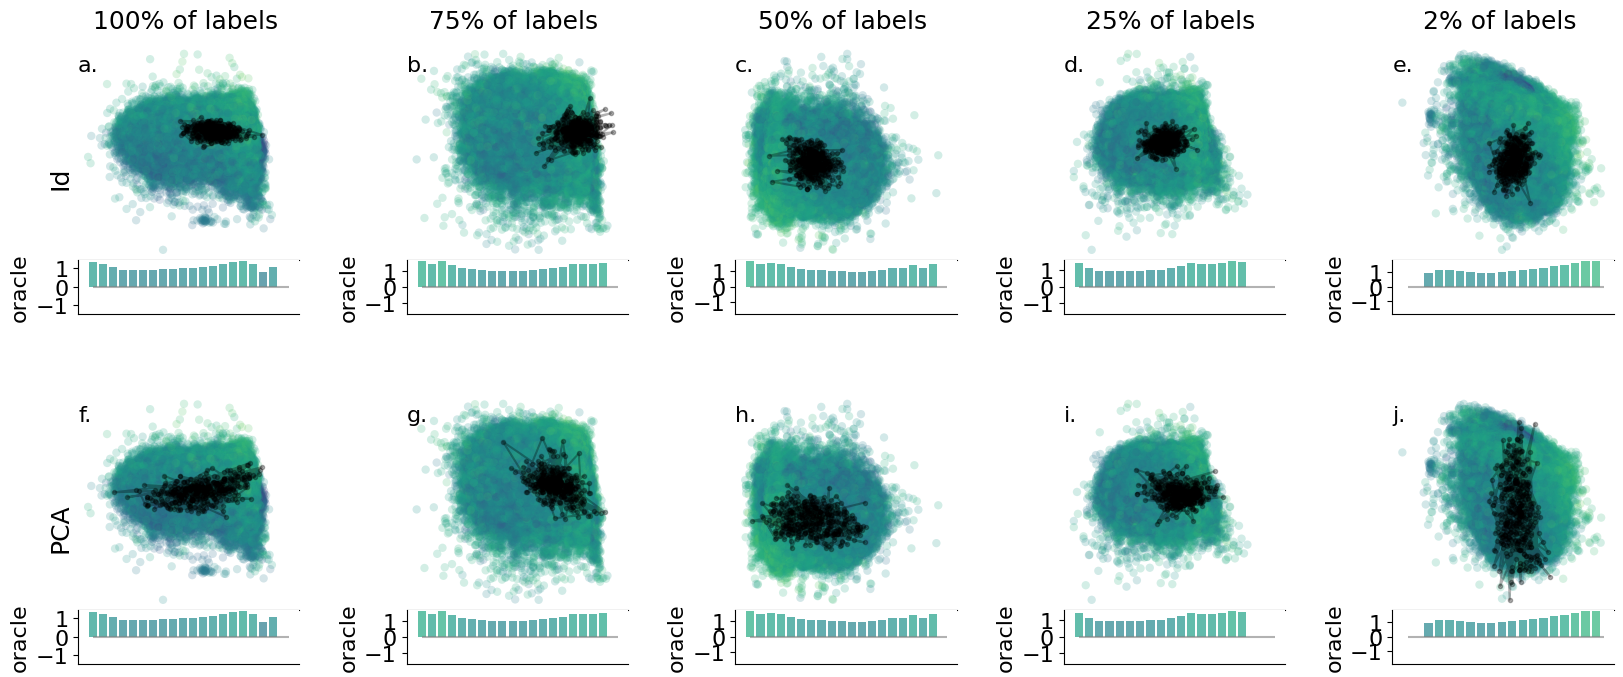

In [48]:
superfig_bayesopt_trajs = plt.figure(figsize=(16,7))
nrows, ncols = 2, 5
subfigs_bayesopt_trajs  = superfig_bayesopt_trajs.subfigures(nrows, ncols, wspace=0.15, hspace=0.0)

condn_rows = (nrows>1)
condn_cols = (ncols>1)

percentages = [0,25,50,75,98]
organizing_property = "bch"
run_space = "pca5"
run_spaces = ["Id","pca5"]

colour_by_properties  = ["boman", "charge", "hydrophobicity"]
colour_by_properties  = ["oracle"]#["boman", "charge", "hydrophobicity"]
if organizing_property=="boman-charge":
    colour_by_properties = ["boman","charge"]
    colour_by_properties  = ["oracle"]
elif organizing_property in ["predicted-log10mic","oracle"]:
    colour_by_properties = ["oracle"]
    percentages = [0,98]
elif organizing_property != "bch":
    colour_by_properties = [organizing_property]
    colour_by_properties  = ["oracle"]
    if organizing_property=="chargepH7p2":
        colour_by_properties = ["charge"]
        colour_by_properties  = ["oracle"]


for ix in range(ncols):
    _perc = percentages[ix]
    organizing_perc = 100-_perc
    for jx in range(nrows):
        run_space = run_spaces[jx]
        _prop = colour_by_properties[0]
        
        if condn_rows and condn_cols:
            sf = subfigs_bayesopt_trajs[jx, ix]
        elif not (condn_rows and condn_cols):
            sf = subfigs_bayesopt_trajs[ix]

        sf = plot_full_sampling_path(search_space_to_run_sequences, 
                                search_space_to_run_data,
                                model, 
                                organizing_perc, 
                                organizing_property,
                                run_space=run_space, 
                                colour_by=_prop,
                                plot_best_points=False,
                                fig=sf
        )
        _ax = sf.get_axes()[0]
        _ax.annotate(
                subpanel_to_letter[(ix,jx)],
                xy=(0, 1), xycoords='axes fraction',
                xytext=(+0.0, -0.5), textcoords='offset fontsize',
                fontsize=16, verticalalignment='top', fontfamily='sans-serif',
                # bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
        )
        
        if jx==0:
            sf.suptitle(f"{organizing_perc}% of labels", fontsize=18)
        if ix==0:
            if "pca" in run_space: 
                _search_space="PCA"
            else:
                _search_space="Id"
            sf.supylabel(f"{_search_space}", fontsize=18)

organizing_property='bch', colour_by_properties[0]='oracle'


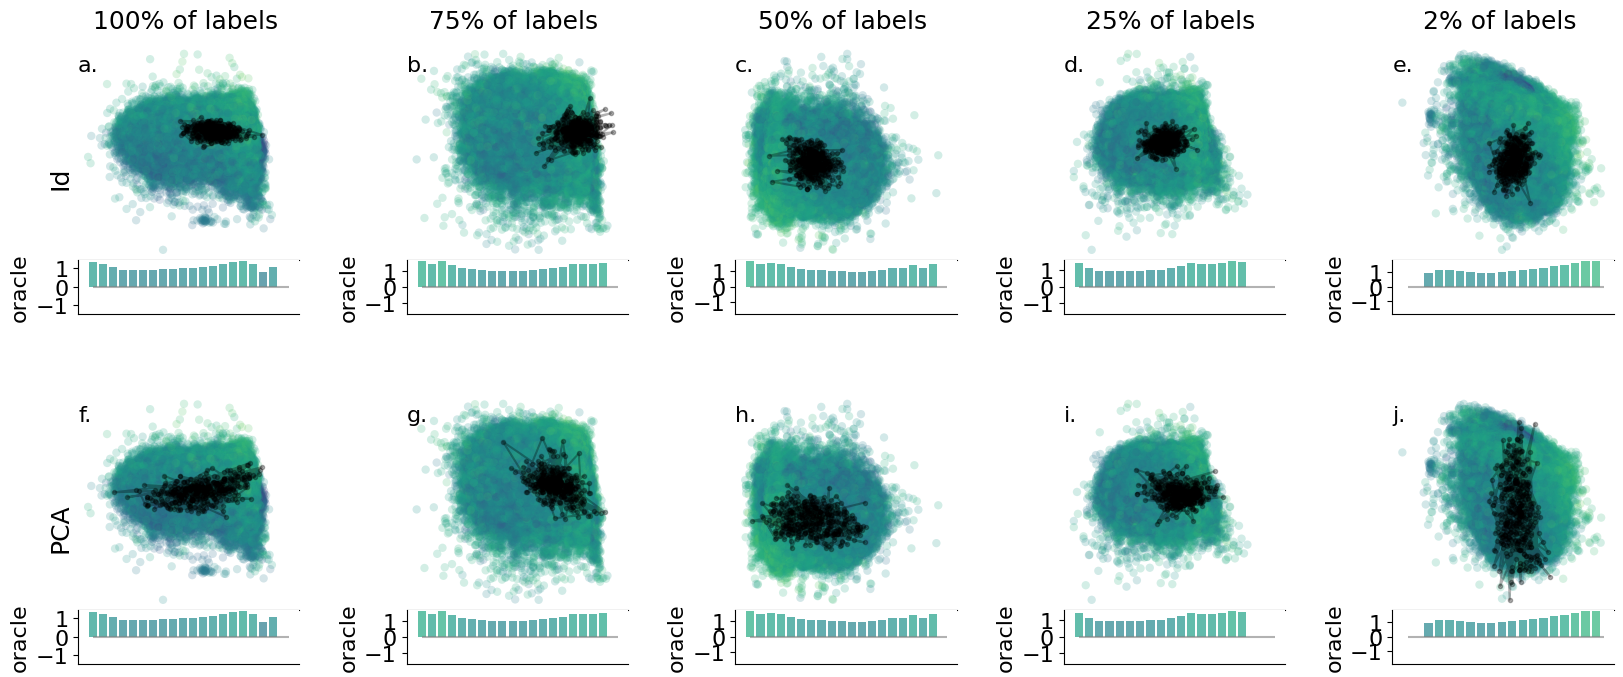

In [49]:
print(f"{organizing_property=}, {colour_by_properties[0]=}")
superfig_bayesopt_trajs

In [50]:
if not SAVE_FIGURES:
    superfig_bayesopt_trajs.savefig(
        f"figures/boloop_trajectories_IN_latent_space_{organizing_property}_ID_and_PCA_colourBy{colour_by_properties[0]}.png", 
        dpi=300
    )

In [58]:
subpanel_to_letter = {
    (0,0):"a.",
    (1,0):"b.",
    (2,0):"c.",
    (0,1):"d.",
    (1,1):"e.",
    (2,1):"f.",
    (0,2):"g.",
    (1,2):"h.",
    (2,2):"i.",
    (0,3):"j.",
    (1,3):"k.",
    (2,3):"l.",
}

85 MDDKQHEMIEFQPENDEADVAATAILRVTDCVRRSHTAKGVRFGQVDPAFDDLVRVDGAPEVAEVLATALEEVDLTPASRSPVEV
82 MKPKIVLLFTVNGQFRELIGGESDSGNIYYEGMFETRADRLWEWHYSGEQGSYSEYEMFRPKLDRKSELRSELTRIPKHGWD
82 MFQVHVTMVKPRGSRYPPVVRDSIYSSSEPIETSKLAYLFKMPYHFLKPNPKFLEQCGHYAFSVYLEKQPRSRPFNIEFCHW
82 MFHTEMPVTRAFVRPPPGKTTPIDVDFSPISKILTLKQLFTYFMQYCSPFESERFYPYHKPLKEFLKPYFEGPRPLNGCCHW
82 MQCRLTVAVPHTYRRNTSYLPVDVTIGDTSEIISSTIFSLRHYYLKIFAKFHRYWFFFRHYFHKKHSSKHHHHRHFFFFHHW
82 MQQPKVITVTWYTFCVHTWTPTVVVNTILDRISSISKSSRHRHFRIGFFRKFHRHWYRYFRFFCLRICFFHHHCHILNHHHH
82 MQKPALTETITYRYPFTPCLRVNTVVLNVLSIFSIKDSKKHHHRSYRTFFTFRHWYRYFRFFFLFCFLFFCHHWCCIICHWH
82 MQLGRINTTTWYVYNLCRVHTTVVFVSISLNIKSKSITSKHHHRTFIFRFRRHRWYWYCRLFFFCLNFTFHCHHRNTNHWHW
82 MQYPIAVTLTLHRMNHTCYFVTNMLLVVSLISKDDSKSSRHRHHRTFYSYRFYWYHYRYFRFCVHCVLGCHCYCRFVFHHWW
83 MQYPATITLPRWRNNRFTHMTPVTNALSDIRLSNASKSHSKHFHKRFKFNCHRRYHRRRFRFYRCRIVCNHCRYNFIHCHHHH
75 MQCATLSRTNPRYYVHTRRPNLCVTVLNTSAIFAIKSKFSHFRFRFRRFKNFHRHWHRYRRRHRFRSVFLCHCWC
75 MQCATFTALNPYRHTRVHCTTHVVFTVLSISKRIASKSFHKRHFRFRFRTFKHH

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


85 MQFTWREFYNLHKCLNYQKRPFLCERPKCMSYELRNKYNQMFLHTLHLCKGYVQSYEYERESQRMFPRNHLDLNGLPSNDNPPHF
85 MFYQNWLRHNQLCFECKPRFQTFNCLIYCKDMQPLFTRNFEKGYLLNGEQLTFSENCAKLRSPKLNAYLANDLSVESSDDNSPPG
85 MQKFYVHLWTNRWLNQKCFDYLRCKEYPSRKHTNLLWKNMYLHIYPKHERLKPSYRECQMLPFKQEPYNRFLEDNLPSPSNPPHC
82 MKLTDRPKIRMEKLPARNFRADQRYLSMEKCVFETAYRTWPDMQHKYLHVERLKQEYFYPRCLPKHPYPEHESLKEYLPKWH

MQFTWREFYNLHKCLNYQKRPFLCERPKCMSYELRNKYNQMFLHTLHLCKGYVQSYEYERESQRMFPRNHLDLNGLPSNDNPPHF
mols_data.shape=torch.Size([4, 127]), props_data.shape=torch.Size([4, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


85 MAHTGETLKFGARVPKRDAPELAKPLTSREGANGRALEDVRSGRSALMTGDERDSGTLIRIGAMALTNAGAVLVSAIDSDVNDNA
85 MQRNWKFYFRECQPCKYRNQRFIWNQGCTQLERKFNTYGYCIRPQCLKEFMNRDRLQGMQNLDFKRMPELRNSKDLNIPSDNCCN
63 WRWWYWRRRYRRRKYLFRLRRMWTRLRFRSWAKRRSRSLCTKARLGKAVFLSFTGTATAAAII
63 MWWYRRRRYRLLLKFLKLRLMLFTRFLKRLMRLLSFKLSKRALTKFTVLSFICLLTAIKAAII
64 WWRWYWRRRYRLLLFTRLRLRLFLRMFRAWTSRWTALLFLSFTLARRLTIGCSFLGTKATRITV
59 MHKHWYHKHHHCYCHKWHNCKHKNHKPMQCKCNKCDFREFLTHTKFDNKDFKQSIKRGI

MADTDGKNGKRGQGQERNPRGETQERDGERTGQDGETRQEGRNRGCMGCTDEQAEGRDRMQDDRRDRMPRDEDAPTPDVPDPPHP
mols_data.shape=torch.Size([6, 127]), props_data.shape=torch.Size([6, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


85 MELNYAFDKPRVFIELEDRKSPELTELKDFLNAEGTYEIVGHALKSENRLDMLGNLKPAENALYIARMGNDLLSDIESVNDNNFL
77 MKGTRGFKTWFGTRNKGFTKSGRGVLEGTMKNSGTLGFIVTQGKGKIFVNLGCVTDGRKTLSAAGFTLNIASADEQI
85 MKFRKGVYKRGFKGFTCVKFKTNEGFKVCAFKSPVKEVYSVKFGRSKIYSDFVRVCITGKNGAKILPAKLANIAVNISSSNDNNA
85 MKSKGNHYKHKHKYKNWKNGKPKPKKKVFNKVSLEKDNKKRNGLYVSKPKNLPIKGNYIAKGKNIMQVIKGKTISLSDVDSNNND
78 MTKSKFWWYFYRWFRKKFTTFTKTRSSKLSKSALKVMVFVVFTFKTIGFTKSYSSLSCTSKLAITRLKTIDIIVTQNI
95 MKSFSWYWWYYFRFRFKKTFRSLKLSKTLSKSVMAMGVFVKFTFILTFIFTGLSCKTLSRSSCANATGKLNKAIATIAARKRAKIAIIAAIAIAT
95 MSKKFHWHWYWYFRFTKFKKSKPTLATALSVKIVKFVSKTFGKSLFVTLFTIFTPKLPIKPAEKPIKDLKPKTIAATILKQAKKAKIAIAIAAAK
77 MKSKLFWYWRYFRFFRKTKCKLFSKLSMQVVAKMVFMISGRFTIFTICKIRGLSCITFNLTAPAARKPLIAIVSFYV
79 MQTQRYRYRQKQTKTKTQTKTKRTTKSKATATKAMTTKTFTFQKSQQTTWTSKYSPKQPRAKANLPRQNKAVVSRHKNK

MKEVRFIFRNYLYVFECNKGEFKPTENCKELVFDFVKPIRNLKGELNGKPIYVNLKPIFAETGKLIYADMDNLIKVNIDSDPNPG
mols_data.shape=torch.Size([9, 127]), props_data.shape=torch.Size([9, 1])
mols_data.shape=torch.Size([500, 127]), props_d

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


91 MLGKRVEFNAYLGKPVLFIKGKPVLRSDQVKALGVNKSLGVFIKGTYSLVEDELPKTGALNSKGASLTFIVPAAIVAATLGAAIIAAKLFN
82 MKKLVIRTRVFFYFFLKCKTLDVYSTKSMLIGIVKSVLKGLSFFTTRNLPGKFDLNLEIGKITKTLGIAGDTILISKISLWV
93 MRVIKLTRFVWVWFFTYLTKCGICKITYVKISVGKFAVLLGFTKSLVFKIGFVSKEGTSKVIEITEAIATASETRAVKTKADKAKKAAKKKVC
88 MMTFVITFKFMRFKVFLMLVFKLRFVWCKCVCKLKIGVAVKIGLFVKKTFLGFTFIGLFTIATLILMIFAIGKTFFTKIAAIAKKNHT
92 MFTMFTFMWKWFRFRFMKRLFLKMCRKCLKCKGLVKGIVKAAKVFKVALSFKFVLKSFITTKSKAIGTLILGLLKKKTKKKAKTATAAAATR
92 MFTMFKRTWFFLYTWKFKFTFRLWKVCWFKVKCLKLVKISKGVLAKTVKSFAFITFITIFVAIFATAIFIAFVKKKKTKKAKAAKAAAAKKL
88 MFMRKMWTWFFFTWKRKFLKLRMFLRVWCKKCKILKVAIAVAGKKGVKKTLFFSLTFIIKLVKIATKLALSLVKFTFKIAIIASKLHT
92 MTLTFTFTRFRWWRWWWTWRCRTRKKKKSLKKRLAKLGKAAVRKIRVVKLGKVLGKKVSLSKSKATIAKSKKKQKQKQKKSKKKSSTSKCLW
91 MLFTTTLTFTFWWWWRWCRCRTRKKKTKIKAKKKKKLKLALKLKKLKIKKFVVCSKSKVKASKAAITAITSKKKWRHKKKSNSKNNKNNKW
91 LTFTTVLTFTFWWWWWWCRCRRTTKKKKAKIKKLAKAKLAKLKLKLFKVRVCKNFSKKSKSAASAAIAATIKKQWKCKKKNSNNKNNNKNW

MLGKRVEFNAYLGKPVLFIKGKPVLRSDQVKALGVNKSLGVFIKGTYSLVEDELPKTGA

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


82 MNKEVPYLGLSQGITEEVQKDFLTFLNDYAELDTNSLTGQSYVQSELTGTDLINVTLSEKQAPDRMNQILGLTELGNQPPWK
67 MTGRSDRFAPVRESIFQVGDKFTDESFTVEIGRDVPGNIQKVSGTMVIGVSVDTGAAVKAFNRDSRT
69 MAFTGTERIFRNSGELASFVADEVKNGSMFITREDGLPVPTAKNAGIVLVSGAVKTNIGMAFQTGSFRG
59 MVASKLFKFSFLARSGEDLIKESVSGQVDMPRFTDGQSLVVNGTTVLAGVTESATPMPL
94 MVKSKRSRFIVAFKSQKESVQASKVFDFQRMVNMSPLVVQPAPLSPVVTVKGVVSLPNLGNVRIEAPGKDVLVSARIAKNAAKKRALKAAAVAK
91 MVGKNTKRGQKGVKEVKSESGSRVESQSWVQSRVPVRSVVSLTPVVLAPVSMAESLPGCVTTPTEAGLSCNVSAVAAVAMNAAAAAVAVQG
92 MKVAKRGWKIKKGAKVEAKELARSSRVWSRVWPAPTPTVTNLSSTALVVVAVSATSVVGVTPAPASATRLVLSAGTLACARAAAAAAAAAKE
92 MAKKGKWKFKGIAGRKVAEVWASKWVAQWSSWTRVWVTPVPARVVASAVAVSVASSATLSVLTLVMVGANAKVKTLVKKRAKAKVAAAAAKL
90 MAVKKGFKKGKKGSAKKEGLVLRERLAEWRQVWPPTRSRTSKSRSKSSSATVTGVVAVPALEVVLAERLVLVVADERPTVAVAAATLPLY
96 MAGIGKFRWKAKAKFAGAGLEWLAELEWWRSHSRHRTSTRPARALVASLPAVAVSSLTVAVTAEVATKVVVAVMVTAVAEVVVAAAMEKSEKESKQ
96 GKSKARKWGKARAEKAVALSEKWSRWRRRWSRVQQQRVPTRLALTAVAVPAVATVPAASRVRSARSKESKSAVAVKVKSASAKSKKKSKSRSKSEK
96 GKEKRKGRWKLARKLAGIEERSWRE

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


68 MHDEEINKPLIEAIYELAEGERSRAVGGTRREHNYLNGELFLLRLGKSLIEDVFNSNTLYYPLEMITV
100 MRLFQNIIYKNDGSYLLEKGNFYELLSARNGELIGQRLNYELVESVTHELILRLYNEVSGYVLSLTDEIKQRFLNGVIKTHLEEIVASLRRMKQQTLKSQ
67 MYIKDNEPHGEAEEYIRELQRRRFASNRGLRHGFLQELVRREILVHELFSMVYTLSNLEWQIVNSLI
67 MYRKENDHIEEAIDYGPEAIRHLGNLQLGRFGRGLNLNVLFRELTRRELTSRLVRNNESWFEHTNSE
66 MRYEIAIYHHENQEYHPGEERYGLLSVLRRLGRFRLLVSRWIEELQFLRIEFHLVSTLGFLIQLNQ
100 MIRYENNGHGDADKRRKSQPKGRLLEEILYRLLLELGGLARHRGLQAERGLVIGFFTVERWSQQQTNTLSATVAHWLNTQTQTNTAAAEVEAQNQTAFGI
100 MKHGGINGRKDEDRPHPSAKGRRPLNEVLRRRLEALLGLSGWRLEAVLHSIAGWFTQTLWLSTQQQTNREAAEIFHLVTTQTQNATAAAEANQATNERRS
100 MKYHINAGRPDQKRGDRDLLGLRRSVVNSRHCRSQLGSVALHRLQAAEWEAEIRWQTAEWGVTQQTAGGVAAIWRIAQQQTAATAQTAAVVEAATQAIGE
100 MRHRKNNGYPDAIRHGPDRGSRGRASAQRRWLLQGLSGVVGRRLQAVGFLAGFHRTEIFHLSTQAEVLRTEPAFRWQTQQQQQQQQTTASAATTQTARRS
100 MKYGDNASHHGAVIRYPDSRLDLRVEVARRRYRLQVGGSVLWGSQQQSRWIGSWAVAFAFVFTATAELHEAISGWPLATQQQQQTQTAVPAATQQTQEGT
79 MHKRGNNDYGPGSKRRREGLRLGRVRVVSGCRGGVSLVGSRLFGQRQQFFQFIFTFAIFIHIATAEAPHETAPWWIQQQ
94 

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


77 MMMQRAMMVMKSLIDKFMASHMMMKVLAMRLFEGMSVRAWQKTNRYATIPGLVRMFELMKDGRLVPALRESMIKRWN
77 MMMQKMMAMVRIAMLFSSDMHVKMLESMARRMKGMAMLFRMMMMMRKMMLMKSRGMPVLMRICTLGVLPAGTLRVWA
77 MMMQRAMMVKSMKILMFDARNHLMSEGVLPAYTFTAERYAVRKQRLGMRNLMGFISPKMVFTHLEKTRPVIEGLCWK
77 MLAIRRNGKTYTSKLFDERVFQCPNKLVRAHGEFAVKSFRMQRGILRVFTPTKHIPSLKIFKQREGLPVLKEVRHYS

MMMQRAMMVMKSLIDKFMASHMMMKVLAMRLFEGMSVRAWQKTNRYATIPGLVRMFELMKDGRLVPALRESMIKRWN
mols_data.shape=torch.Size([4, 127]), props_data.shape=torch.Size([4, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


77 MMQQKFENIEIENDIDKVDKSHNINCQNDFEKIRTLEEYMNKMMKMFEEIHQPIFSDKLGIREKLKNRMDSMNCIWN
98 MQTNMIDAQNENEQEIIKEDLKDIEEENDFNEHSENNYFDFQDRIRQFMMMMKCMRKMREIYALCTAIDYEVILGFPLMKERLCYYRITAVRYCFWWN
97 MQNQIKEANQENENEIIIEMDDKEEETDEIDDHTNDIKHKKNREEFIQFMEQYVEFFQRNPLFRQLNPERLKNLPFERGNKVFSYYCQNQIVFWRWN
97 MQNNAIIEQQAVANEEDDIDMKREEENEDDHEDFTESIWWNEQIYRNQYVARVFYRLKQFFEYLKAVQFFIRNGRFPRLARRLYGWYNASVFYWCWE
37 MYWKWSKWWCICWRCSKKLKVKSICGWKKSINLKKNN
37 MYWKSWSKWWKICWCVLKRVLSIKGCWSKKINACKNN
37 MYWKWSKWWCICWRCKRSFVKSLKCIWKKGINKCSNN
37 MYWKSWSKWWKRCWCVKCILVKSCSKWGKIKAIRKNN
77 MQTAAIRANAAIEEDRAKVELRVRTVELSVLHTGASVRAWQAAERVRGEIAFKAYQRGIFVEYAEPTRVPAAGRYGC

MMQQKFENIEIENDIDKVDKSHNINCQNDFEKIRTLEEYMNKMMKMFEEIHQPIFSDKLGIREKLKNRMDSMNCIWN
mols_data.shape=torch.Size([9, 127]), props_data.shape=torch.Size([9, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


77 MRPKDKENIQILDEMFQHQHPEYNEIGEKSREDFVQRKPKHIILMFQKPEDGNYTLERLKNFSDVLKMGISQPTYKL
97 MYIGFLINNITSIQVLEAKKKLSCNNIKMIFIGLSIVGYINPTFNLRELKKLTFGNYQVLSYIMGETFLDKNRPQFRVLKGSNYIYHTENLIKWYWQ
95 MYWYMKNKLNIILLITILFQIKKISERNVLGIITFLNIEKLNNKLTIIKDNPNLIALGNKICQELGTPIKEALTCNLVSKAPEKGIIVTDIKCNQ
78 MWFMWHPLGPYIGSRPSRLPGYSSRVCSYVGYPLSGVYRFIFSLHARYQAGYTVYMFMQHLPFVPLGIFTHQLAYWVF
78 MWWWWPYWYPYYHRPLRPGRLHGPGYSLWSGLWSLGLWVIPHLPVPRGIPFLMRPRMHMPAFLTGLRPARTGTAWHTL
77 MWWWYPLLPYYYYRPRYPRWRYPYGGRRWLGPWLGLGWLWRPRPLRPYLSLPAWVLRRPLRIGLTYATLFGTALWRS
54 MWWWRAALRWRWYPRCWPRWPRCRRWPRRRRLRRWCLRRRWAWARLRLAAWPAD
53 RWWWYAARPRWWRRRCRWPRWRPRRWLCRRLRRRWCRRAWRARWARARALWPL
53 RWWWRAAARWCRWPRPRWPRWCRLRWRCLRRARWRRCRRRAWRAWAARAAWLA
53 MWWWRAARRRWCRYPRPWRRWPRCRRWLCLRAWRRRWRARRWARRCRAARWAL
54 YWWWWAAARWRCRYPRPRWRRPCRRRWPLRARRRWCRRLACWARRARLARCPAA

MRPKDKENIQILDEMFQHQHPEYNEIGEKSREDFVQRKPKHIILMFQKPEDGNYTLERLKNFSDVLKMGISQPTYKL
mols_data.shape=torch.Size([11, 127]), props_data.shape=torch.Size([11, 1])
mols_data.shape=torch.Size([500,

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


78 MDSRAFSRPKCVGCGRTWNAMPDERKAFREGSGRKTPDGKVACRSSGRVFTPDLDGARALPEKGARLPSHTNAKRYQS
98 MADSKTRSGMTRTFRERKKTCAARGSPERAGILKDRRTGSRTFDRSKARKSGLKVPDTGLGVHTRALRDLSKAEAGPDVTGKFLHPEENSKAGKGRHQ
98 MQMTTKSARTEKSRRPAYAEASRASGSSLTRTERTGKARTDSLKVRTGSRARLTPKSALKVFTGSLPTRPIAVSGLTKLDALGFRRVAEATKKGGRHQ
95 MQTMQAKSASSTRREFRKASRTADRISTKDESVKTCASSARTRTARGASLRLSVRAMKTLPGTRILSFTLPAVKAGVRNALFSFRGTIAALPHSQ
81 MQTMQSKAAKVTRSFRSRKVKAIRTSRTEVRTVSPARATKKISVGACSTRLARKLTAGFVSVLKDLGGKSLSKILARSGDS
95 MQTMQSKSAKAERSYVRRTFATSCAASDSAASIKTRTCASVRTLKVRARSFSGLRVKTCNGIRALLNCGTRAALTRINSAGFTYLSALQAVRCSQ
78 MQTTMQAKKASSKFSRRSRVSIPEKSVFTASGKTVRAKTRAMKSIRTHSLTCLAGVLSMKVPASLIRFQKTGVTRWQA
98 MTQMQTAKSAASFSKRPSFVADSKVSVSRNAARVARAAFTSAKMLTRSLTCKAIGSSLTRTRVKGMIPLKGATLKERALTPVLYRDGNATASLRFHFQ
96 MNMQQASSATDESKRFTFAKSARTVLASATKAAPTVRSLTKGALSMKTFGVRSRLTGLNKIRARQLAGHTSEVLKNISAGTRRFFLQAAGDLRGNQ
98 MQMTTNAMAAAAKRSRFRLSKCEVSSMATKAVRTAFASHTVRALVRAKIFGTRLKVGLTLPKSRNLIGRVLAAGAPTGLTLKNWRKAIAASVGLPYFQ
96 MQMQAAFASTDSTKFKSKNKAASERTTASVSKTAKALTSFTA

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


38 MGRSKSRCTRVGEVRVFDFAGSRVGRRCSKGSPLRERL
98 MNQRVPSAMGSLYGISFKLEHEFNASSAENSPTSKQPFSSPGRKLGVRSTRLSPGNDTSQRVLKGLNFIPDAKTGQRQAVRLFRHFPSNGRKYTLFWQ
98 MNQMLGSAPVSYFNYRISFDGSKSRNAESSNPASLSRNYQGFSSRPKTGSPLDRVKTLTSGNFSGTRLPKPTGDLNLMEKIKRNWYGTTVDRRYLWYQ
96 MQNMSGLVSPAYIYFSRHNFSSRNPKNASKESSSFSSPGHPSSRFKVTHTPIRSPNRQNLKGTCSLPVYALIRTGGSNLTREYRKNRPLILKYWSE
96 MQNMVGSRNSFAYHPFYISPLSFSSSRASNKSSRSSFSYNSPHSRSKNPGTRPGSKTLTRVKNHIPTYVFDGTFPAISVQRLHGRKLPNGDRFWLS
97 MQNMMHSNIPKYFYYSFPVRSSPSSSSSVSSSPSPNPHFSYSSRYNNKHTSTYTKSKKIGNYTRSYTIYRSGKFNYTNIPSRTYGYKRNNKGRWYWV
97 MQNMKRSNNASWYYHYSSRSSSSSAAVASNNGNRNSRSSYSSYHSYSKSKIRSHTYTSKVKYTSKRGYGRIRKKRVGKIGVYNIWRSKVNNSRYYWN
98 MQMKRSSNNAHPWWSYRSGRFNSSSNNANVASSKVHSSYGYSYSHSRSKSSKRSHTRITKVPYTSVYRISRKVIGTKVSKVPYTYSRGASRSGRGYWQ
98 MQMARPNNSSSGWWRWKKRSHSNKSVTAVNASSSSKHSRKWSKYGSKSSSPSRVHSVVTGSKRVKRIHRVGISVPTATVRISRYYVRARTPARRTPWT
74 MQMAKRNNASSYWHHWSSHSYVSSKANATTNSSSSHSKYSWSKHRYSSSKHSRRKKTTVKKTRSRVHSRVKKSR
74 MQAMKHANNVSWYRWSYSRYSRSSNANVNANVSSYSSWSKWKHSKHKKSSHSKYSSTSSSSKKVRKR

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


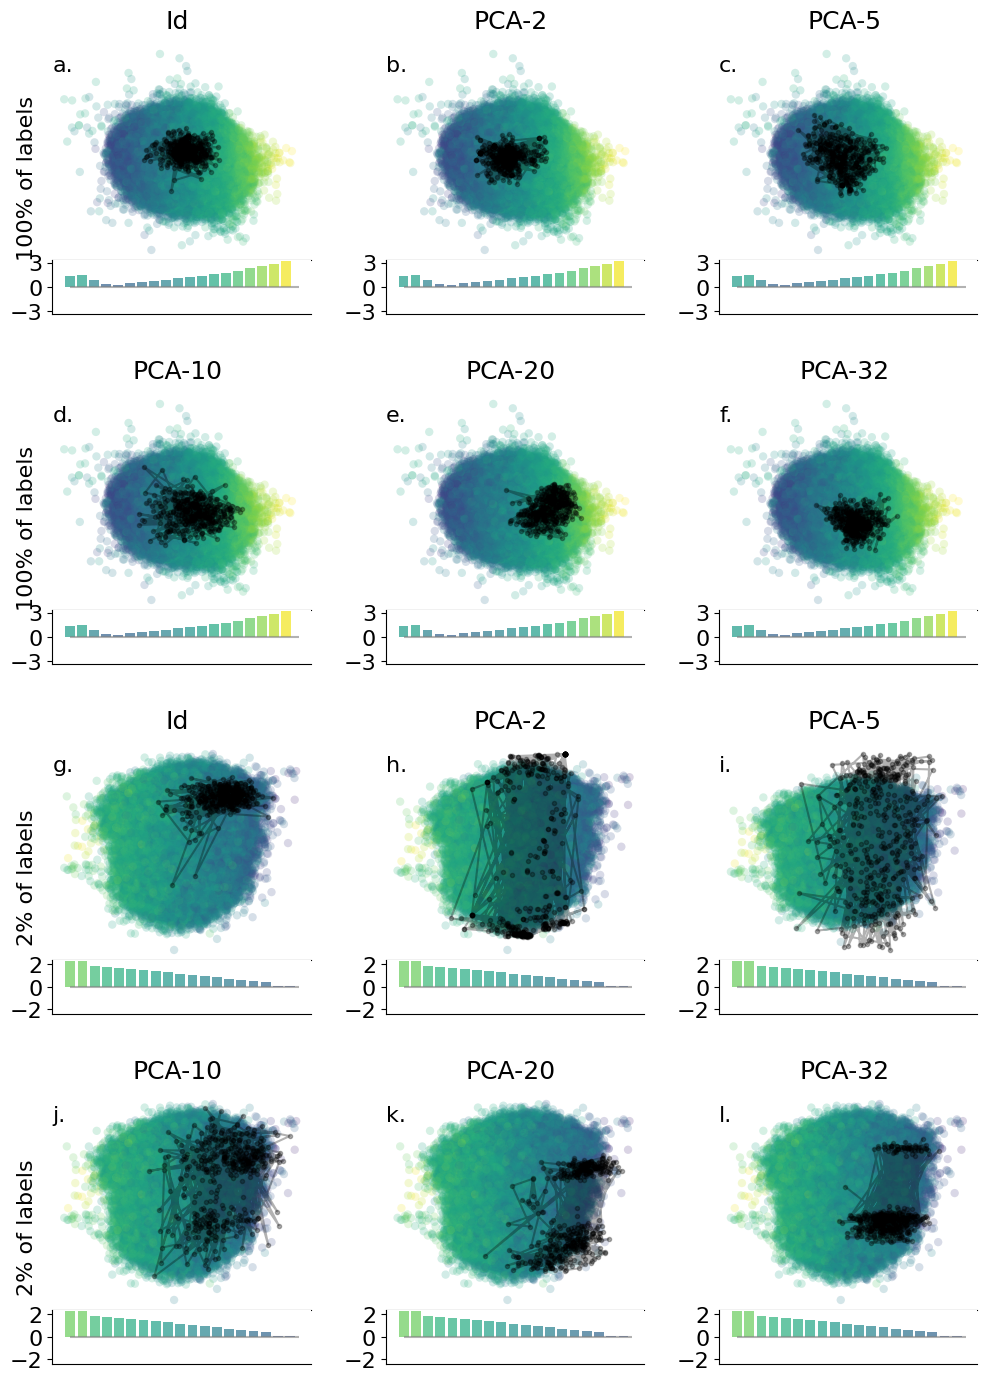

In [76]:
superfig_bayesopt_trajs = plt.figure(figsize=(10,14))
nrows, ncols = 4, 3
subfigs_bayesopt_trajs  = superfig_bayesopt_trajs.subfigures(nrows, ncols, wspace=0.0, hspace=0.0)

condn_rows = (nrows>1)
condn_cols = (ncols>1)

percentages = [0,25,50,75,98]
organizing_property = "predicted-log10mic"
run_space = "pca5"
run_spaces = ["Id","pca5"] # id, pca2, pca5, pca10, pca20, pca32

colour_by_properties  = ["boman", "charge", "hydrophobicity"]
if organizing_property=="boman-charge":
    colour_by_properties = ["boman","charge"]
elif organizing_property in ["predicted-log10mic","oracle"]:
    colour_by_properties = ["oracle"]
    percentages = [0,98]
elif organizing_property != "bch":
    colour_by_properties = [organizing_property]
    if organizing_property=="chargepH7p2":
        colour_by_properties = ["charge"]

run_spaces = ["Id", "pca2", "pca5", "pca10", "pca20", "pca32"]
for ix in range(nrows):
    _perc = percentages[ ix//2 ] # changes only after ix>1
    _on_second_row = 0
    if ix in [1,3]:
        _on_second_row = 3
    
        
    organizing_perc = 100-_perc
    for jx in range(ncols):
        run_space = run_spaces[jx+_on_second_row]
        _prop = colour_by_properties[0]
        
        if condn_rows and condn_cols:
            sf = subfigs_bayesopt_trajs[ix, jx]
        elif not (condn_rows and condn_cols):
            sf = subfigs_bayesopt_trajs[ix]

        sf = plot_full_sampling_path(search_space_to_run_sequences, 
                                search_space_to_run_data,
                                model, 
                                organizing_perc, 
                                organizing_property,
                                run_space=run_space, 
                                colour_by=_prop,
                                plot_best_points=False,
                                fig=sf
        )
        _ax = sf.get_axes()[0]
        _ax.annotate(
                subpanel_to_letter[(jx,ix)],
                xy=(0, 1), xycoords='axes fraction',
                xytext=(+0.0, -0.5), textcoords='offset fontsize',
                fontsize=16, verticalalignment='top', fontfamily='sans-serif',
                # bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
        )

        if "pca" in run_space:
            run_space = "PCA-" + str(run_space[3:])
        sf.suptitle(f"{run_space}", fontsize=18)
        if jx==0:
            if ix//2 ==0:
                sf.supylabel("100% of labels", fontsize=16)
            else:
                sf.supylabel("2% of labels", fontsize=16)

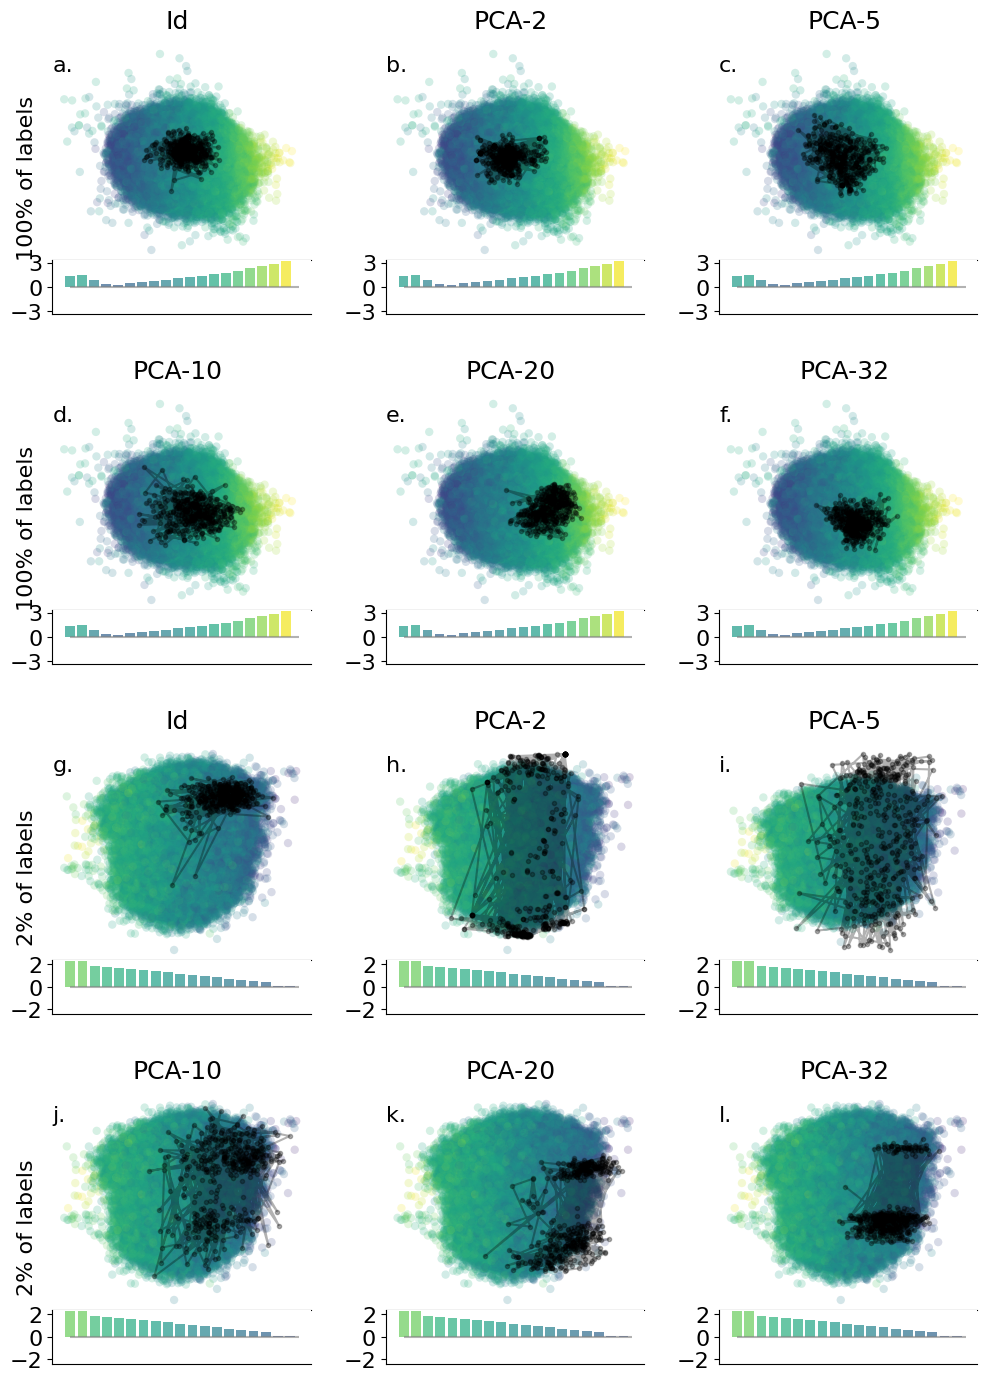

In [77]:
superfig_bayesopt_trajs

In [78]:
if not SAVE_FIGURES:
    superfig_bayesopt_trajs.savefig("figures/boloop_trajectories_IN_latent_space_oracle_vary_search_spaces.png",dpi=300)

## plot BCH spaces

In [80]:
subpanel_to_letter = {
    (0,0):"a.",
    (1,0):"b.",
    (2,0):"c.",
    (3,0):"d.",
    (4,0):"e.",
    (0,1):"f.",
    (1,1):"g.",
    (2,1):"h.",
    (3,1):"i.",
    (4,1):"j.",
}

68 MDRKNLSEEQIEQFVKLVEELGDKTFVADDLFNARNLRCILSYEFLLALGEQQKEFQGPKTLKILDNI
93 MSRPSELPKPLSKVIKGTFRHLRNLVNDYYNLHHDRRVRLAQLALRQPARRETSTIPIPDRTFSQRALAERITKERLTEQKLRPTKQSQYSLE
96 MSKPVSPLNPSKVSKWKLTRHRFMLEYNNDLHLDRCLRVAALQRRLAEATTTSSSNDFIPDPTIATILAGRLLAQRDRMRPQRHRPHRQGHQHRQR
93 MSRPKVPNLSPASAKFGTRHLRLLNVYPNNYLLRRRDVRALQRAQDARRQSITSPTPIDSPSFAHATLAERIRDRQLRQQATQHARTLKTPAQ
92 MSSARVPPKPSESKGKMRQYRRLLYELPNYLHRQRDVRAAEHQRRATDQRARHTSIPDFCFSFTETREATAVEARVTQWQRHQRYRQRYRMV
96 MVRRRSPPPNISARKGTPWNLLHLRLERLYYPEYRRRAVAERQRQRADRAIRTSTLTDFPFTVTVALQRALATLRLRLWRAWRDRQRWRRQRWQRR
96 MSRVSPPPKPVSKKRVTYRMYRRQVQLLHYNDLRRERVRRERQAPAARQVRATVTFITFTVTDTTAITLTLALLTTTLWRRRYRRQRRRWQRQPTD
96 MRVSVSPNPIPSKGKVKYYPRRQRMLLLNLDLRDRFLREVRARQERALATATARVTFFDFTITPAEATAATVTTTQRWRQWTRRYRDRQYRDQRRW
96 MRVSCRPNPIPSKARGKPYPVRQQRLLYLLNDLRRVFVERLERERAQARATTITVFTFTVFVTTTAMAAAMTTTTTTTTTWDRRRQRRQQRQRWQR
77 MRVNSVPPRPRIKMKVRRYYRVRQRQYLNLRPLRFERVARARLANAERAIARTTVFTVTDFTDTVTRARAATQQQQQ
77 MKVRCRPVNPSLKMKVRTYRPWMQRNLRLHLDRDLRFRVRAKRERAEKTATVTV

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


95 MDKLVTMDNGSPTEDRLVLEWGEVTNIKGDPREIRLADFLEGPKTGELSYADMRSADTLVKLNGEMVRETLDKRPDKFKDLTPSGYIDSVLDRLV
95 MSYRQRPGDTAWFNARIPFRQRSPDRAYQVTRGINPRADRVQFHPRTQDRPVKDKVTKDKLSERMKHFTERKDTLNVEGYIEVDVEDFDISVPSL
95 MGRRGWCRGSRSWGFGSRWGAVRWVWSRSVWAGTSRCWRVAPGRRWPAWVRPSGERVTRTIRRVRLRQDRTPAPRLGDLIDSCPVAVDCPVSGEG
95 MGFRGCRGFGGSWVGFSGRWVVSWVWRSVGWVAFTRGFVGAGMRYRRFTVGPARPVAPRRVWASLRMRRLDTATLVLPCSDLVDVVCDVPVCLDT
94 MRRKKRKRTRTATRRTRLSLRFALRLTFKFTRKKKTFVRGTKHLTHPRHFRKVPVKMEKIRARRKRRHKYNNPEIEEVEVVMVVVDIVVVVVVD
95 MRKRKRKRATAFTARRTAFALFLRFKALFTTRTKALFSGTVTHLLHTRRYRVPAIKVEKIRKRRRPKRQYKPNPEIEIVVVIVVIVIVPVPIPIP
95 MKARKKAAAARAAKARASKAALAFARKKLAATATRLASALAFTKKLHTTAVRVLALALIKVKVRKRKRLKPQPEPIDEVVIVVIVVVIPVVVRIP
63 KKKKAKAKKARAKAKKARKALRAKSKLKAKRALTKLAKTARKLSALRLATRKALSQRAGARKR
79 KKAKKKAKAKAKKAKRAKARLAKRAKLRKAKKLTAKSTKATKALARLRLRALALRALSTLSATCRVTEAPAQAAKKKRK
64 MRWRRRFRWKFRSRWSFKFWFKKFFWKFLRFKFWLKFFKWSTFLFSLRLFTWLCKMCKRMCWRF
64 MRRRWRRWRSKRWSRFKWFKFKRFTKFWLRSFKWKFLRWSLFRFSLSKFLWTWCKMKCLCRRWR
79 MRRWRRRWRSKRWFRRSTW

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


90 MPRPTGIPKFRHTKPISTMREFSKQLSIEAVYGRINHLEANLPELIESVNAYAKALASMLRTNLYLNSLNETLEKDSKARQNELKSQRKT
90 MPPETLVFTWTQHVSINASKTPISRLAKTVEKFGANRIPILEDKTLAVPEVLTARMLKSLTKLTSFYLDNLELTSVKEHKEQIRQENEKS
89 MPPLDAWPFSFKTISKSKQLTVAMDMQRGIRFINVEGIPQELTLVDEIEGSARMLIQKRISCLHFFTCKTLNLDELQLKQESQKEKEKE
97 MMVNLHRYWIFTQLATTSKSWFSDQRKQAKMATGYNPSVQFPRPSAAVKIAIFAIAIGLLPKRPQFPDKPAFETNPTITPTIPTTQIKIYQKIKPKI
90 MMGCPLRYFTYFYAQHTSVNGHDVMRKVKAKGNGNSTFDKKKDTANAVAAVAVTIIIFGLTKKKYPPRPDEPTPRGKGKNKTKGFTLTEK
97 MMPFVPYTLFYTQLTRDFTENNHRRERMVMRMDNGYHIPYPPKAEAASAVIVTIGVGFLLTLKYQQPNQPTNGKIKGKVKCKFHWHYLCLYLCNLNL
97 MGMVYHYCLHTTFTKAAFDNNWCNCSRQAIREIENCCYYHCQQQEAAAAIVIGVFFFNIIMQKLQLQQAYPGYPYGCYHCHLPRKALKKALIRIKII
97 MMYMYSYHFTHTLTATFATFNNNCRRRCMVAAPYYYNMHSKANAAKAIANAIGTIFLLLVKQQEMYEKPAYYMKPYGKKGKGKLFFKGKKKNWPKDH
97 MMMYYYHTFHTLTLTATTFTFNCRNRRVMVPPFMTYPYLQNRMIEVQIAGTIVIAFLTLKLPKQGKEYEMQMYGKPKGKKGKGCFKKGWKKKGKPSH
97 MGKMYHYHTFTFTLTLTTADNCKCNCKVERAATNPNHYFYKKMQIATAAMATAVCGFLLYAAQYQQKYEKTGKPNGKCGCKCGKKAKVKIKGKRSKI
86 MMKYPTHFHTLTTTAT

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


90 MSPFNDSLHTVNSHSDVPMHFLTSNPDRMFHVHNAPNLDSFTRNPVQHVFPPTVEHVTPRNGTRRYCPARCTESGRTGNALNPVSGLSPS
18 RRARRRPRRRRRARARWA
29 RRPRRRARRRPRRARARARPAPRRARPAR
32 RSARLRRPRRARASRARARPARARPARAPRAR

MSPFNDSLHTVNSHSDVPMHFLTSNPDRMFHVHNAPNLDSFTRNPVQHVFPPTVEHVTPRNGTRRYCPARCTESGRTGNALNPVSGLSPS
mols_data.shape=torch.Size([4, 127]), props_data.shape=torch.Size([4, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


68 MRPDELKNEEIQRIIWIEALDADVYTGDIGSNIRNWSTLLFNGIRLLEVNKQGQLTLDKRHIVEHALG
96 MAMYKSGQLKFQQSRDVDKLRKRLWFPLDLLQYRLRACPEMARGEPMQCNECERRKRNGPDGERQVNVRRACQGRATAVDANGISEYLSWEMSRPL
96 MMSKPISKQVPNKCITRFARPRHNHYLNFNCSSQRCTSRWALFGLERADRWLELLGNIGYAYPKSKPRNCLRECGLRLGEWDLLDCEKSLYVKLSM
96 MTFFPFNATKQKRNFIALVSRHTHHNCNFNNFSRATRCHSNSCSGGKAGIKRKDIHDGELNRLCSKSVPRYSKGYCLYEWECEYLRIYCQKCSMQC
88 MKFSFYFQHGTQSATFLFRARLHHLNHNFYCNSSCSLTHTCSFVSFAGEKRQRVIIDFYGKKQPQRQLSRYPFRPHRFRGRFIFYFFF
96 MMFSYFPKAKHTPLCFEFRTSKLHHNNLFYFCNSLSCRSLMFFFVVISKKQITKIRICYIKRKTTQSKSLYRCHCFCYFKVYGKFTLFKILFKFTY
89 MSWKFPFNNQRLRISIRSRCRRQHTHNNNYNCCLSPLSTCFMYSFTKENIKAGIYFRRYRTKKSKPLLLYTRRYVICTVLFYCYFRFWF
94 MKSFWFSSLKQLFLKFVCTLTRTHNHNHNNFNRSTSHSCRCSCFFMATQQNIKGFRFTFRRYTMTYTPHTYLYSKFTIVFKLGLFKVLVKVAVK
96 MPITFNPERHRSKLIRCFRRLQLQHHNLNNFSYSSHSCLCSLYFIKSKTKKSFKIRFTGKYTRTHHTYKPTYPLFFLIFTVFVLFKFCLKVCKCKL

MEVNHIQKPELELRFKEIISKMIHYIEFEKSPLDLLNGKEFVEVQEFEQEVKNLKDLEGARDIKYGIYQ
mols_data.shape=torch.Size([9, 127]), props_data.shape=torch.Size([9, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


96 MKLYSKRYHEERFHNRSKNGKLKDHLFERNLKDMKEWLFTDKNKWLERSIYRWDRNLKELDPEREKFHDHYSKKDKCDLSKDLLKELVPSRTKAPI
96 MVAKVARKVAVEKVKAKRAKGERARKAKGEVRAERRGERKAGERGKTERGIRERDRREPEREAEEWAREWHRPDGERAGDRRELEARQGARAPARR
71 VKVARVKVVKEVKVKAKRKAREGRKAKARVEGKKVEREVERREGAKREREAGTAREREKDKRAAAATAEER
41 VKVVRARKVGKVKAKVKRERKAKVKEVKRAVERGREKAEVR
41 VRVKVVRVKGVKVKVKVKRAGRKRAGRKVVERVGRKARAGR
96 MVRVVRVRGVIWVVKVVKIKVFKVKVKAMFRIGKIRVKRGGERFGLARLGRIGKRDLRDVEALGKPTERFRPVKIVDTAVERAIAAEVEALAKGAT
71 MRVCRRWVVWVIRWVKVKFRMKVKYVRICKFKVKYVTFGRRIGKNRRFTILGVSLKRNGCTGIVATARINP
71 MRRVWVRIWRIKVWVIKKVYRKIKFRTVYKIFKKVKDRRIFTKSKFKRECIEVTVNNYRGTVVEAARAANG
42 MRVCRVWRVWVVKFRMVRKCGVKRCKFVRTWVYVRRFTVKGC
71 MCRRCVWCWVFVRMCKCVFKMVMKCYCVRLFKVCPYRGRVGRGLYLFTCTILVFALPRYRGVVTSVATSKF
71 MCRCWCRWVWFCRMRYVCKFMMKCYRLCICKCYGKCTFTRYVFLKYLVLGTFTLVPFPRKFRVVATAASRS

MKLYSKRYHEERFHNRSKNGKLKDHLFERNLKDMKEWLFTDKNKWLERSIYRWDRNLKELDPEREKFHDHYSKKDKCDLSKDLLKELVPSRTKAPI
mols_data.shape=torch.Size([11, 127]), props_data.shape=torch.Size([11, 1])
mols_data.shape

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MKNLGNVKKTLYSINLPRASPFNTQMVSLSEFQTPGIRLSKIKTKQFIELTRIKANVPILNANKLPNHLDSLDSPAYELGKRQGWILNLGDL
96 MKKHSEKFHTKLPLISKASKNLTNNTQIAPSLYTKILSGELYANVQKIRPASAVIRNYRESHIKNRCDSRDKNPAHNHPKNFGHVYLFLFHDCSLG
96 HQVRVPAYLKYVKKLRSARINNTHTMQAIRHTTTIEKARIRLYIEKKRQLNLLIRLRLQEPKYKYIILSYIREEKNIHNELPNVLFCFKVLPSLFK
96 MQKKKVAINTYWLHLAIIENNHTTIEIQRMLTKTNQAIAGKGIKIAKGASSSAIEASSTNTGNKTKKGSKKNKQKANKNNVNSSSSPSASAKSPAK
97 MQKKRVAIDYHGWLLAIEENHYTIIQIMSLHTKINKAEGTLTATAKAGISAKEIVSSSNTKTIKNKKSKAQNKQANKAGNAKNSKNSIYAIYIIGDG
96 MQKQKAVVIYHGKVLLIQINNMLTQIQIIHRHFTQEASKIFKGAIQTKAAGATIAIENISTKGKTSSKNAKNQSKNKQNKDIGSIISGISIKNSKA
96 MQKQAAVTTGNWKLVAEENNHNTTIQMQILMTHTIEAIKFKVASKNAAKASVNAAINVSNKSNKKDKKNPKNAQNKNQSSSDVATSAYISAKKSKN
96 MQQKVGIGDNFLKLLMAEENNHTNIQAIRLHTTMAESSGVKTVKIASKANKAVKISEDSTAKNTKNKKTNQSQSNKANKNSDKIGIFKTVSKTGNK
92 MQQKDKGIITKWKRLANEIENNTHMIEQALLTHSSNAIAGFFHTAAAEAFTKKAINNDSSSKTKTNKKNQQKANKNKTKTATASNASIAINE
97 MQQKVGAVKNTWLRLAMENNQNMNMAIQRHFHTKAEIAKTLTKVAAKASKTLAEISIDKTSKTKTTKKNKQNAEKNAKANKDKTATKTVKTTVKDKF
97 MQQ

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


96 MSKPDMKVPATHILDHIRFSNLEGCGELSPDLKGSGELNTLRGIPNLLDLNRSLNVKGTIKPREDLRVGNLIPEYRDYNTQFPKFSFGLTFSLFNV
96 FFLFILFLGPVSKAGLGENKVQCAIEHVHVPEVRGPAPVNGLARDGIKPAGIKLAYEYRLDRAMGLARRLARQLAQEQEEEAEEAIEAIQKSYAKQ
96 LFLLCLLLLRGGKRVRRGAPKSRLARSGNLRLPALAYAKGPLAAVGHAPVRGIGRPLIKPGACAARLLRLRQARAEQREEEAEIEAIEAMQGRLAP
96 MRWRWLRRKKRCRRSRRKPLLKQRVRRYRSKRVRHAGGPARLPRGVAHAPGAGKACAHPDLKAKARLRLARQLAQEQEPEQAEEQVEQVMQIGQGA
96 MQRQRHRRLRRCAKRLLGLSWRLLLVKKRCSLRGLSRRGGAGLRGKLPIAGLRLPPGRPVPRAVRKARRALAAPAEPENQPEQKIQQIPEVLIYIE
96 MQQRQRRRWRLRSLRLCLLLRLCLLRLGRGGRWVRRLGSRVRWLLPVAPRVLKGRCPAPKVAGKRARRAALAATNNANQPAPQQPANAPITITTAG
96 MQQRQRHRRRWRSRRCRCLRLWLRLWGRVRHWLVRKRGRVKRCRGKAGSLKVRKPCRPLPATARKRARAKAVAPTPENQQPQPAPPATPATTNTAV
96 MQQRQRHRRWRLRSRCLWLLLRCLWLRVRGWKGWRVRALKCGRRCVRASGKGLKKVHPRVPVRKARRRARAAVAPANQNQNPQQEPAPIAPIATAT
96 MQHRRHRWRWRCRLHLCLWLLWLWLCLRCRGWCRLKLGRGKCRLGLKSGKGVLRKCPPKPVRVRRSRRRAKVAPAPINNQQPAPQPIQTITATITK
67 MQRRRQRRHRRRKRRSRWRGRRLRLKRSCRRAKLKLSKRGKALPRRLPSGLPLARPACPATKQLWLT

MFFVYVFLSFIGYLAVTGMPVNFARPVT

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MNATNIVRTFPMITADGTKRRWMRTAMANLHDDLNANSSNKSLELGLFDFISEFIKEVQKNLNEQLGKTLEKKRSGNISSYLSGLQKNLLRK
92 MPELNVNFKGFRSYEALHKDHIYKSELKINYFILNGLNSHTKKTLVKIHFITTIKTALNLSGIINKNPRQQNKEIVSSFYMLEGRLQRELEK
92 MPNVRGINSLFNKFIQTLPAWIYPEKLTELFDLNSVTFNLSKNKIILNPVSKIITKNLLGKNGINPMLQNKKARENGNLYFSGSIKKAQQIL
90 PNPAKIYIPKAYYALNKSPCHISSLKNPATKYINLTPNPKLQRIEKLFSIMLEATASTMTNIQEYLKNLLQQKEKRDRYGWTKVAAEAIQ
90 PNKLLITFNKLGYLTLKHTFYFVSKKSNKTLTDFMQHQPPQTKAMALSFNILEIKKIPESDEQYIQHLKKEKQIKNNTYKWLIKIAAEAQ
91 PPPQITWASQIYYQYPQPTPYYALTSPVKKSITDSMKPNFKIMQKGGLYLKIIKKEWTGEIKQNIYKYPYQQKKMKQKWPWSEIEEIEAEA
91 PKPIPASFTLITGTNQHVKTCFYMSKSPLLLTGSLKPKKHKISQEKACFYIKEIKENFIIEQNQQKNPNQEMMQKKKPHHSYIIIEEQKEA
91 PKPIKSFKVSDQINSSKTPIWYISPSLPTLPIGLSKKPKPYAKEMAKYCGILQITQIYVTEQQQKNRNNQMQQKKPKKHYFSLIEEEQAEA
91 PPFAAIIWSQSYNIYARQPWSYVAPWPLLSLMGCPLQKHPRKEQAKIWCSTKKTINIYVNTQNNNNNNMQIQQQKHHHTHGIGIIKEIQAA
91 MPFKGAFTSSTKDVSNKPNWGSAVPLGPKKYIYPKQKPLFLNNQLAISFGLLQEITGYINTRRMQNGYTKQQQQNNHHSWCCIIAAAAQAK
91 FPKIQYFTFYAITYPNPKKLWYILPAKKFKNNIKLKLKPVLQNKKI

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


86 MLGQLHILVRALYLILLKNVFIKLNFLLQIIPFHTLKEVGFPGRQLQYGFCFDQKKRGNCYFQLRLKPLPSIITINDNNNNNHNND
86 MQQKQKKKKLKKLIRLKAKLWKARLPPLLIQLFHHLKAAIHWRRKQKLYWCCNQQKRLFYWIRQRRPRLRLNIIYINNNQNNNNNY
86 MQKKKKKKKKKKKKARQKKLKARKRKKRAARARRPRAAQLPTPKQKRANCRFREQRARFRYGRQRRARRLRGMDTTQNNNRNNNNG
86 MQQQKQKAQKQKKATQKQKAGKQKRELKKELERRFQKAESKNLRKQQIHDLSREERRARYGYKQRKRARYRIRIDRENNQNNNNSD
86 MQKKKKKKKKKKLAKRAKRLALRKRKLLKARLTPRLKALLTPRMKRALNGFRGARMRARYFTPAKRQRLGFIRTNIRGQRNINHTS

MLGQLHILVRALYLILLKNVFIKLNFLLQIIPFHTLKEVGFPGRQLQYGFCFDQKKRGNCYFQLRLKPLPSIITINDNNNNNHNND
mols_data.shape=torch.Size([5, 127]), props_data.shape=torch.Size([5, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


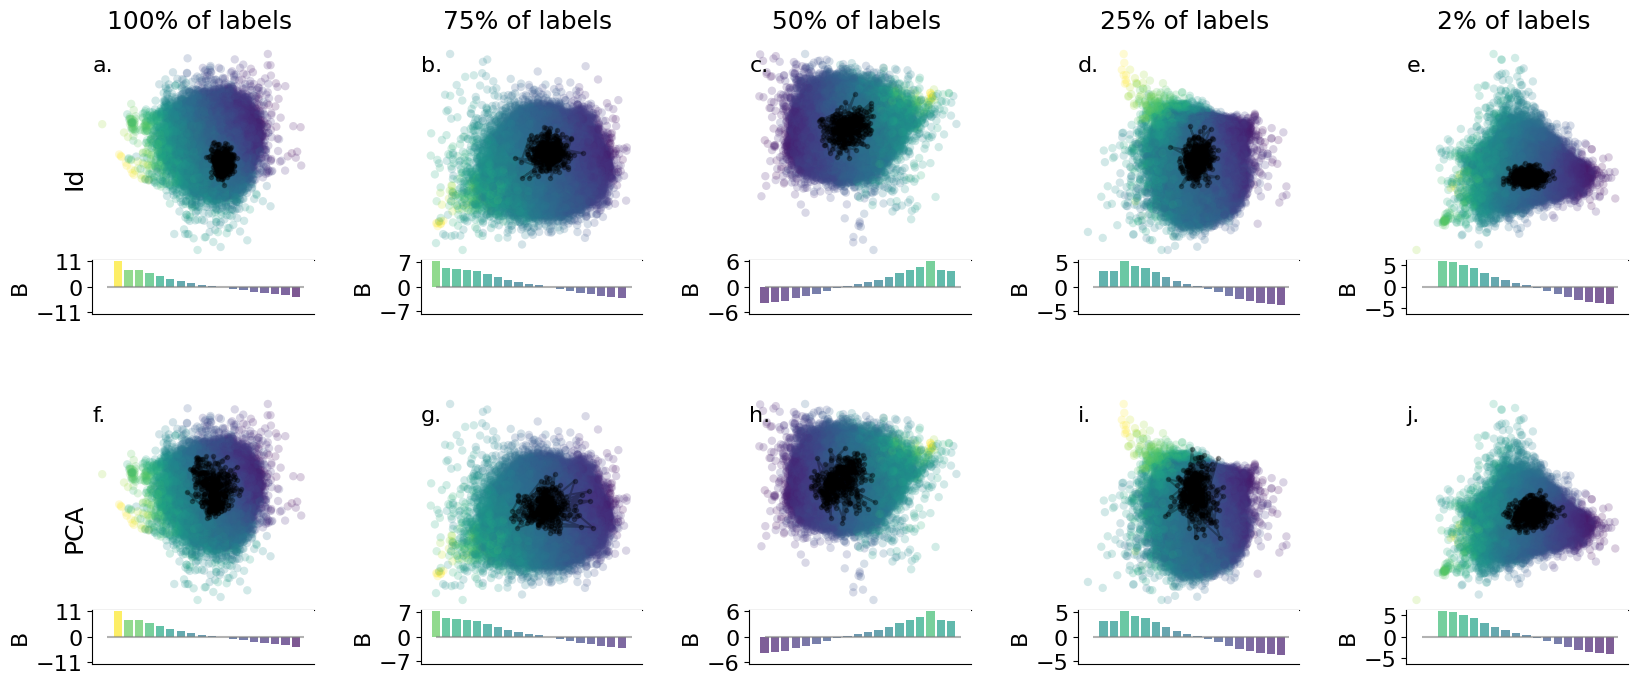

In [87]:
superfig_bayesopt_trajs = plt.figure(figsize=(16,7))
nrows, ncols = 2, 5
subfigs_bayesopt_trajs  = superfig_bayesopt_trajs.subfigures(nrows, ncols, wspace=0.15, hspace=0.0)

condn_rows = (nrows>1)
condn_cols = (ncols>1)

percentages = [0,25,50,75,98]
organizing_property = "bch"
run_space = "pca5"
run_spaces = ["Id","pca5"]

colour_by_properties  = ["boman", "charge", "hydrophobicity"]
if organizing_property=="boman-charge":
    colour_by_properties = ["boman","charge"]
elif organizing_property in ["predicted-log10mic","oracle"]:
    colour_by_properties = ["oracle"]
    percentages = [0,98]
elif organizing_property != "bch":
    colour_by_properties = [organizing_property]
    if organizing_property=="chargepH7p2":
        colour_by_properties = ["charge"]


for ix in range(ncols):
    _perc = percentages[ix]
    organizing_perc = 100-_perc
    for jx in range(nrows):
        run_space = run_spaces[jx]
        _prop = colour_by_properties[0]
        
        if condn_rows and condn_cols:
            sf = subfigs_bayesopt_trajs[jx, ix]
        elif not (condn_rows and condn_cols):
            sf = subfigs_bayesopt_trajs[ix]

        sf = plot_full_sampling_path(search_space_to_run_sequences, 
                                search_space_to_run_data,
                                model, 
                                organizing_perc, 
                                organizing_property,
                                run_space=run_space, 
                                colour_by=_prop,
                                plot_best_points=False,
                                fig=sf
        )
        _ax = sf.get_axes()[0]
        _ax.annotate(
                subpanel_to_letter[(ix,jx)],
                xy=(0, 1), xycoords='axes fraction',
                xytext=(+0.0, -0.5), textcoords='offset fontsize',
                fontsize=16, verticalalignment='top', fontfamily='sans-serif',
                # bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
        )
        
        if jx==0:
            sf.suptitle(f"{organizing_perc}% of labels", fontsize=18)
        if ix==0:
            if "pca" in run_space: 
                _search_space="PCA"
            else:
                _search_space="Id"
            sf.supylabel(f"{_search_space}", fontsize=18)

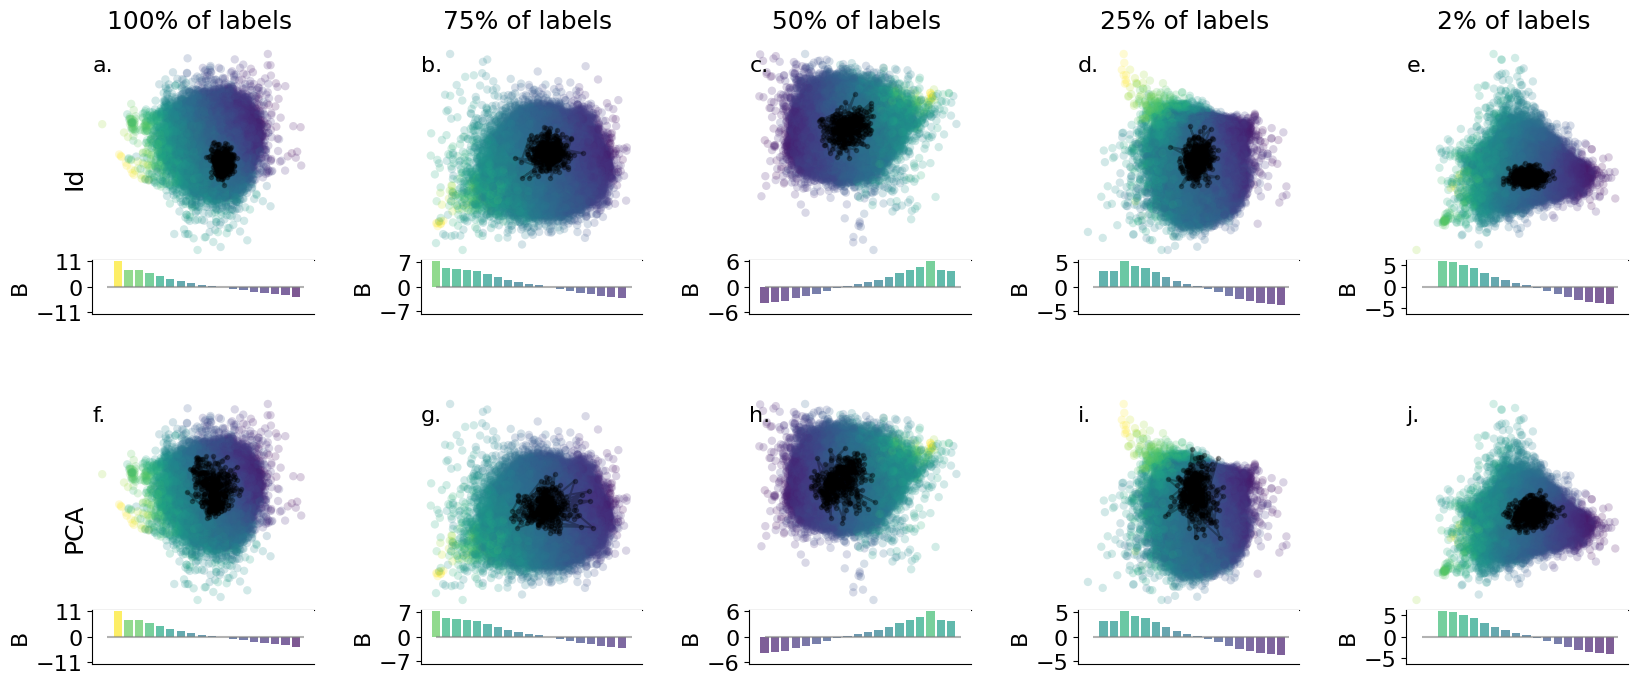

In [88]:
superfig_bayesopt_trajs

In [89]:
if not SAVE_FIGURES:
    superfig_bayesopt_trajs.savefig("figures/boloop_trajectories_IN_latent_space_bch_bomanColour_ID_and_PCA.png",dpi=300)

68 MDRKNLSEEQIEQFVKLVEELGDKTFVADDLFNARNLRCILSYEFLLALGEQQKEFQGPKTLKILDNI
93 MSRPSELPKPLSKVIKGTFRHLRNLVNDYYNLHHDRRVRLAQLALRQPARRETSTIPIPDRTFSQRALAERITKERLTEQKLRPTKQSQYSLE
96 MSKPVSPLNPSKVSKWKLTRHRFMLEYNNDLHLDRCLRVAALQRRLAEATTTSSSNDFIPDPTIATILAGRLLAQRDRMRPQRHRPHRQGHQHRQR
93 MSRPKVPNLSPASAKFGTRHLRLLNVYPNNYLLRRRDVRALQRAQDARRQSITSPTPIDSPSFAHATLAERIRDRQLRQQATQHARTLKTPAQ
92 MSSARVPPKPSESKGKMRQYRRLLYELPNYLHRQRDVRAAEHQRRATDQRARHTSIPDFCFSFTETREATAVEARVTQWQRHQRYRQRYRMV
96 MVRRRSPPPNISARKGTPWNLLHLRLERLYYPEYRRRAVAERQRQRADRAIRTSTLTDFPFTVTVALQRALATLRLRLWRAWRDRQRWRRQRWQRR
96 MSRVSPPPKPVSKKRVTYRMYRRQVQLLHYNDLRRERVRRERQAPAARQVRATVTFITFTVTDTTAITLTLALLTTTLWRRRYRRQRRRWQRQPTD
96 MRVSVSPNPIPSKGKVKYYPRRQRMLLLNLDLRDRFLREVRARQERALATATARVTFFDFTITPAEATAATVTTTQRWRQWTRRYRDRQYRDQRRW
96 MRVSCRPNPIPSKARGKPYPVRQQRLLYLLNDLRRVFVERLERERAQARATTITVFTFTVFVTTTAMAAAMTTTTTTTTTWDRRRQRRQQRQRWQR
77 MRVNSVPPRPRIKMKVRRYYRVRQRQYLNLRPLRFERVARARLANAERAIARTTVFTVTDFTDTVTRARAATQQQQQ
77 MKVRCRPVNPSLKMKVRTYRPWMQRNLRLHLDRDLRFRVRAKRERAEKTATVTV

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


95 MDKLVTMDNGSPTEDRLVLEWGEVTNIKGDPREIRLADFLEGPKTGELSYADMRSADTLVKLNGEMVRETLDKRPDKFKDLTPSGYIDSVLDRLV
95 MSYRQRPGDTAWFNARIPFRQRSPDRAYQVTRGINPRADRVQFHPRTQDRPVKDKVTKDKLSERMKHFTERKDTLNVEGYIEVDVEDFDISVPSL
95 MGRRGWCRGSRSWGFGSRWGAVRWVWSRSVWAGTSRCWRVAPGRRWPAWVRPSGERVTRTIRRVRLRQDRTPAPRLGDLIDSCPVAVDCPVSGEG
95 MGFRGCRGFGGSWVGFSGRWVVSWVWRSVGWVAFTRGFVGAGMRYRRFTVGPARPVAPRRVWASLRMRRLDTATLVLPCSDLVDVVCDVPVCLDT
94 MRRKKRKRTRTATRRTRLSLRFALRLTFKFTRKKKTFVRGTKHLTHPRHFRKVPVKMEKIRARRKRRHKYNNPEIEEVEVVMVVVDIVVVVVVD
95 MRKRKRKRATAFTARRTAFALFLRFKALFTTRTKALFSGTVTHLLHTRRYRVPAIKVEKIRKRRRPKRQYKPNPEIEIVVVIVVIVIVPVPIPIP
95 MKARKKAAAARAAKARASKAALAFARKKLAATATRLASALAFTKKLHTTAVRVLALALIKVKVRKRKRLKPQPEPIDEVVIVVIVVVIPVVVRIP
63 KKKKAKAKKARAKAKKARKALRAKSKLKAKRALTKLAKTARKLSALRLATRKALSQRAGARKR
79 KKAKKKAKAKAKKAKRAKARLAKRAKLRKAKKLTAKSTKATKALARLRLRALALRALSTLSATCRVTEAPAQAAKKKRK
64 MRWRRRFRWKFRSRWSFKFWFKKFFWKFLRFKFWLKFFKWSTFLFSLRLFTWLCKMCKRMCWRF
64 MRRRWRRWRSKRWSRFKWFKFKRFTKFWLRSFKWKFLRWSLFRFSLSKFLWTWCKMKCLCRRWR
79 MRRWRRRWRSKRWFRRSTW

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


90 MPRPTGIPKFRHTKPISTMREFSKQLSIEAVYGRINHLEANLPELIESVNAYAKALASMLRTNLYLNSLNETLEKDSKARQNELKSQRKT
90 MPPETLVFTWTQHVSINASKTPISRLAKTVEKFGANRIPILEDKTLAVPEVLTARMLKSLTKLTSFYLDNLELTSVKEHKEQIRQENEKS
89 MPPLDAWPFSFKTISKSKQLTVAMDMQRGIRFINVEGIPQELTLVDEIEGSARMLIQKRISCLHFFTCKTLNLDELQLKQESQKEKEKE
97 MMVNLHRYWIFTQLATTSKSWFSDQRKQAKMATGYNPSVQFPRPSAAVKIAIFAIAIGLLPKRPQFPDKPAFETNPTITPTIPTTQIKIYQKIKPKI
90 MMGCPLRYFTYFYAQHTSVNGHDVMRKVKAKGNGNSTFDKKKDTANAVAAVAVTIIIFGLTKKKYPPRPDEPTPRGKGKNKTKGFTLTEK
97 MMPFVPYTLFYTQLTRDFTENNHRRERMVMRMDNGYHIPYPPKAEAASAVIVTIGVGFLLTLKYQQPNQPTNGKIKGKVKCKFHWHYLCLYLCNLNL
97 MGMVYHYCLHTTFTKAAFDNNWCNCSRQAIREIENCCYYHCQQQEAAAAIVIGVFFFNIIMQKLQLQQAYPGYPYGCYHCHLPRKALKKALIRIKII
97 MMYMYSYHFTHTLTATFATFNNNCRRRCMVAAPYYYNMHSKANAAKAIANAIGTIFLLLVKQQEMYEKPAYYMKPYGKKGKGKLFFKGKKKNWPKDH
97 MMMYYYHTFHTLTLTATTFTFNCRNRRVMVPPFMTYPYLQNRMIEVQIAGTIVIAFLTLKLPKQGKEYEMQMYGKPKGKKGKGCFKKGWKKKGKPSH
97 MGKMYHYHTFTFTLTLTTADNCKCNCKVERAATNPNHYFYKKMQIATAAMATAVCGFLLYAAQYQQKYEKTGKPNGKCGCKCGKKAKVKIKGKRSKI
86 MMKYPTHFHTLTTTAT

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


90 MSPFNDSLHTVNSHSDVPMHFLTSNPDRMFHVHNAPNLDSFTRNPVQHVFPPTVEHVTPRNGTRRYCPARCTESGRTGNALNPVSGLSPS
18 RRARRRPRRRRRARARWA
29 RRPRRRARRRPRRARARARPAPRRARPAR
32 RSARLRRPRRARASRARARPARARPARAPRAR

MSPFNDSLHTVNSHSDVPMHFLTSNPDRMFHVHNAPNLDSFTRNPVQHVFPPTVEHVTPRNGTRRYCPARCTESGRTGNALNPVSGLSPS
mols_data.shape=torch.Size([4, 127]), props_data.shape=torch.Size([4, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


68 MRPDELKNEEIQRIIWIEALDADVYTGDIGSNIRNWSTLLFNGIRLLEVNKQGQLTLDKRHIVEHALG
96 MAMYKSGQLKFQQSRDVDKLRKRLWFPLDLLQYRLRACPEMARGEPMQCNECERRKRNGPDGERQVNVRRACQGRATAVDANGISEYLSWEMSRPL
96 MMSKPISKQVPNKCITRFARPRHNHYLNFNCSSQRCTSRWALFGLERADRWLELLGNIGYAYPKSKPRNCLRECGLRLGEWDLLDCEKSLYVKLSM
96 MTFFPFNATKQKRNFIALVSRHTHHNCNFNNFSRATRCHSNSCSGGKAGIKRKDIHDGELNRLCSKSVPRYSKGYCLYEWECEYLRIYCQKCSMQC
88 MKFSFYFQHGTQSATFLFRARLHHLNHNFYCNSSCSLTHTCSFVSFAGEKRQRVIIDFYGKKQPQRQLSRYPFRPHRFRGRFIFYFFF
96 MMFSYFPKAKHTPLCFEFRTSKLHHNNLFYFCNSLSCRSLMFFFVVISKKQITKIRICYIKRKTTQSKSLYRCHCFCYFKVYGKFTLFKILFKFTY
89 MSWKFPFNNQRLRISIRSRCRRQHTHNNNYNCCLSPLSTCFMYSFTKENIKAGIYFRRYRTKKSKPLLLYTRRYVICTVLFYCYFRFWF
94 MKSFWFSSLKQLFLKFVCTLTRTHNHNHNNFNRSTSHSCRCSCFFMATQQNIKGFRFTFRRYTMTYTPHTYLYSKFTIVFKLGLFKVLVKVAVK
96 MPITFNPERHRSKLIRCFRRLQLQHHNLNNFSYSSHSCLCSLYFIKSKTKKSFKIRFTGKYTRTHHTYKPTYPLFFLIFTVFVLFKFCLKVCKCKL

MEVNHIQKPELELRFKEIISKMIHYIEFEKSPLDLLNGKEFVEVQEFEQEVKNLKDLEGARDIKYGIYQ
mols_data.shape=torch.Size([9, 127]), props_data.shape=torch.Size([9, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


96 MKLYSKRYHEERFHNRSKNGKLKDHLFERNLKDMKEWLFTDKNKWLERSIYRWDRNLKELDPEREKFHDHYSKKDKCDLSKDLLKELVPSRTKAPI
96 MVAKVARKVAVEKVKAKRAKGERARKAKGEVRAERRGERKAGERGKTERGIRERDRREPEREAEEWAREWHRPDGERAGDRRELEARQGARAPARR
71 VKVARVKVVKEVKVKAKRKAREGRKAKARVEGKKVEREVERREGAKREREAGTAREREKDKRAAAATAEER
41 VKVVRARKVGKVKAKVKRERKAKVKEVKRAVERGREKAEVR
41 VRVKVVRVKGVKVKVKVKRAGRKRAGRKVVERVGRKARAGR
96 MVRVVRVRGVIWVVKVVKIKVFKVKVKAMFRIGKIRVKRGGERFGLARLGRIGKRDLRDVEALGKPTERFRPVKIVDTAVERAIAAEVEALAKGAT
71 MRVCRRWVVWVIRWVKVKFRMKVKYVRICKFKVKYVTFGRRIGKNRRFTILGVSLKRNGCTGIVATARINP
71 MRRVWVRIWRIKVWVIKKVYRKIKFRTVYKIFKKVKDRRIFTKSKFKRECIEVTVNNYRGTVVEAARAANG
42 MRVCRVWRVWVVKFRMVRKCGVKRCKFVRTWVYVRRFTVKGC
71 MCRRCVWCWVFVRMCKCVFKMVMKCYCVRLFKVCPYRGRVGRGLYLFTCTILVFALPRYRGVVTSVATSKF
71 MCRCWCRWVWFCRMRYVCKFMMKCYRLCICKCYGKCTFTRYVFLKYLVLGTFTLVPFPRKFRVVATAASRS

MKLYSKRYHEERFHNRSKNGKLKDHLFERNLKDMKEWLFTDKNKWLERSIYRWDRNLKELDPEREKFHDHYSKKDKCDLSKDLLKELVPSRTKAPI
mols_data.shape=torch.Size([11, 127]), props_data.shape=torch.Size([11, 1])
mols_data.shape

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MKNLGNVKKTLYSINLPRASPFNTQMVSLSEFQTPGIRLSKIKTKQFIELTRIKANVPILNANKLPNHLDSLDSPAYELGKRQGWILNLGDL
96 MKKHSEKFHTKLPLISKASKNLTNNTQIAPSLYTKILSGELYANVQKIRPASAVIRNYRESHIKNRCDSRDKNPAHNHPKNFGHVYLFLFHDCSLG
96 HQVRVPAYLKYVKKLRSARINNTHTMQAIRHTTTIEKARIRLYIEKKRQLNLLIRLRLQEPKYKYIILSYIREEKNIHNELPNVLFCFKVLPSLFK
96 MQKKKVAINTYWLHLAIIENNHTTIEIQRMLTKTNQAIAGKGIKIAKGASSSAIEASSTNTGNKTKKGSKKNKQKANKNNVNSSSSPSASAKSPAK
97 MQKKRVAIDYHGWLLAIEENHYTIIQIMSLHTKINKAEGTLTATAKAGISAKEIVSSSNTKTIKNKKSKAQNKQANKAGNAKNSKNSIYAIYIIGDG
96 MQKQKAVVIYHGKVLLIQINNMLTQIQIIHRHFTQEASKIFKGAIQTKAAGATIAIENISTKGKTSSKNAKNQSKNKQNKDIGSIISGISIKNSKA
96 MQKQAAVTTGNWKLVAEENNHNTTIQMQILMTHTIEAIKFKVASKNAAKASVNAAINVSNKSNKKDKKNPKNAQNKNQSSSDVATSAYISAKKSKN
96 MQQKVGIGDNFLKLLMAEENNHTNIQAIRLHTTMAESSGVKTVKIASKANKAVKISEDSTAKNTKNKKTNQSQSNKANKNSDKIGIFKTVSKTGNK
92 MQQKDKGIITKWKRLANEIENNTHMIEQALLTHSSNAIAGFFHTAAAEAFTKKAINNDSSSKTKTNKKNQQKANKNKTKTATASNASIAINE
97 MQQKVGAVKNTWLRLAMENNQNMNMAIQRHFHTKAEIAKTLTKVAAKASKTLAEISIDKTSKTKTTKKNKQNAEKNAKANKDKTATKTVKTTVKDKF
97 MQQ

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


96 MSKPDMKVPATHILDHIRFSNLEGCGELSPDLKGSGELNTLRGIPNLLDLNRSLNVKGTIKPREDLRVGNLIPEYRDYNTQFPKFSFGLTFSLFNV
96 FFLFILFLGPVSKAGLGENKVQCAIEHVHVPEVRGPAPVNGLARDGIKPAGIKLAYEYRLDRAMGLARRLARQLAQEQEEEAEEAIEAIQKSYAKQ
96 LFLLCLLLLRGGKRVRRGAPKSRLARSGNLRLPALAYAKGPLAAVGHAPVRGIGRPLIKPGACAARLLRLRQARAEQREEEAEIEAIEAMQGRLAP
96 MRWRWLRRKKRCRRSRRKPLLKQRVRRYRSKRVRHAGGPARLPRGVAHAPGAGKACAHPDLKAKARLRLARQLAQEQEPEQAEEQVEQVMQIGQGA
96 MQRQRHRRLRRCAKRLLGLSWRLLLVKKRCSLRGLSRRGGAGLRGKLPIAGLRLPPGRPVPRAVRKARRALAAPAEPENQPEQKIQQIPEVLIYIE
96 MQQRQRRRWRLRSLRLCLLLRLCLLRLGRGGRWVRRLGSRVRWLLPVAPRVLKGRCPAPKVAGKRARRAALAATNNANQPAPQQPANAPITITTAG
96 MQQRQRHRRRWRSRRCRCLRLWLRLWGRVRHWLVRKRGRVKRCRGKAGSLKVRKPCRPLPATARKRARAKAVAPTPENQQPQPAPPATPATTNTAV
96 MQQRQRHRRWRLRSRCLWLLLRCLWLRVRGWKGWRVRALKCGRRCVRASGKGLKKVHPRVPVRKARRRARAAVAPANQNQNPQQEPAPIAPIATAT
96 MQHRRHRWRWRCRLHLCLWLLWLWLCLRCRGWCRLKLGRGKCRLGLKSGKGVLRKCPPKPVRVRRSRRRAKVAPAPINNQQPAPQPIQTITATITK
67 MQRRRQRRHRRRKRRSRWRGRRLRLKRSCRRAKLKLSKRGKALPRRLPSGLPLARPACPATKQLWLT

MFFVYVFLSFIGYLAVTGMPVNFARPVT

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MNATNIVRTFPMITADGTKRRWMRTAMANLHDDLNANSSNKSLELGLFDFISEFIKEVQKNLNEQLGKTLEKKRSGNISSYLSGLQKNLLRK
92 MPELNVNFKGFRSYEALHKDHIYKSELKINYFILNGLNSHTKKTLVKIHFITTIKTALNLSGIINKNPRQQNKEIVSSFYMLEGRLQRELEK
92 MPNVRGINSLFNKFIQTLPAWIYPEKLTELFDLNSVTFNLSKNKIILNPVSKIITKNLLGKNGINPMLQNKKARENGNLYFSGSIKKAQQIL
90 PNPAKIYIPKAYYALNKSPCHISSLKNPATKYINLTPNPKLQRIEKLFSIMLEATASTMTNIQEYLKNLLQQKEKRDRYGWTKVAAEAIQ
90 PNKLLITFNKLGYLTLKHTFYFVSKKSNKTLTDFMQHQPPQTKAMALSFNILEIKKIPESDEQYIQHLKKEKQIKNNTYKWLIKIAAEAQ
91 PPPQITWASQIYYQYPQPTPYYALTSPVKKSITDSMKPNFKIMQKGGLYLKIIKKEWTGEIKQNIYKYPYQQKKMKQKWPWSEIEEIEAEA
91 PKPIPASFTLITGTNQHVKTCFYMSKSPLLLTGSLKPKKHKISQEKACFYIKEIKENFIIEQNQQKNPNQEMMQKKKPHHSYIIIEEQKEA
91 PKPIKSFKVSDQINSSKTPIWYISPSLPTLPIGLSKKPKPYAKEMAKYCGILQITQIYVTEQQQKNRNNQMQQKKPKKHYFSLIEEEQAEA
91 PPFAAIIWSQSYNIYARQPWSYVAPWPLLSLMGCPLQKHPRKEQAKIWCSTKKTINIYVNTQNNNNNNMQIQQQKHHHTHGIGIIKEIQAA
91 MPFKGAFTSSTKDVSNKPNWGSAVPLGPKKYIYPKQKPLFLNNQLAISFGLLQEITGYINTRRMQNGYTKQQQQNNHHSWCCIIAAAAQAK
91 FPKIQYFTFYAITYPNPKKLWYILPAKKFKNNIKLKLKPVLQNKKI

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


86 MLGQLHILVRALYLILLKNVFIKLNFLLQIIPFHTLKEVGFPGRQLQYGFCFDQKKRGNCYFQLRLKPLPSIITINDNNNNNHNND
86 MQQKQKKKKLKKLIRLKAKLWKARLPPLLIQLFHHLKAAIHWRRKQKLYWCCNQQKRLFYWIRQRRPRLRLNIIYINNNQNNNNNY
86 MQKKKKKKKKKKKKARQKKLKARKRKKRAARARRPRAAQLPTPKQKRANCRFREQRARFRYGRQRRARRLRGMDTTQNNNRNNNNG
86 MQQQKQKAQKQKKATQKQKAGKQKRELKKELERRFQKAESKNLRKQQIHDLSREERRARYGYKQRKRARYRIRIDRENNQNNNNSD
86 MQKKKKKKKKKKLAKRAKRLALRKRKLLKARLTPRLKALLTPRMKRALNGFRGARMRARYFTPAKRQRLGFIRTNIRGQRNINHTS

MLGQLHILVRALYLILLKNVFIKLNFLLQIIPFHTLKEVGFPGRQLQYGFCFDQKKRGNCYFQLRLKPLPSIITINDNNNNNHNND
mols_data.shape=torch.Size([5, 127]), props_data.shape=torch.Size([5, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


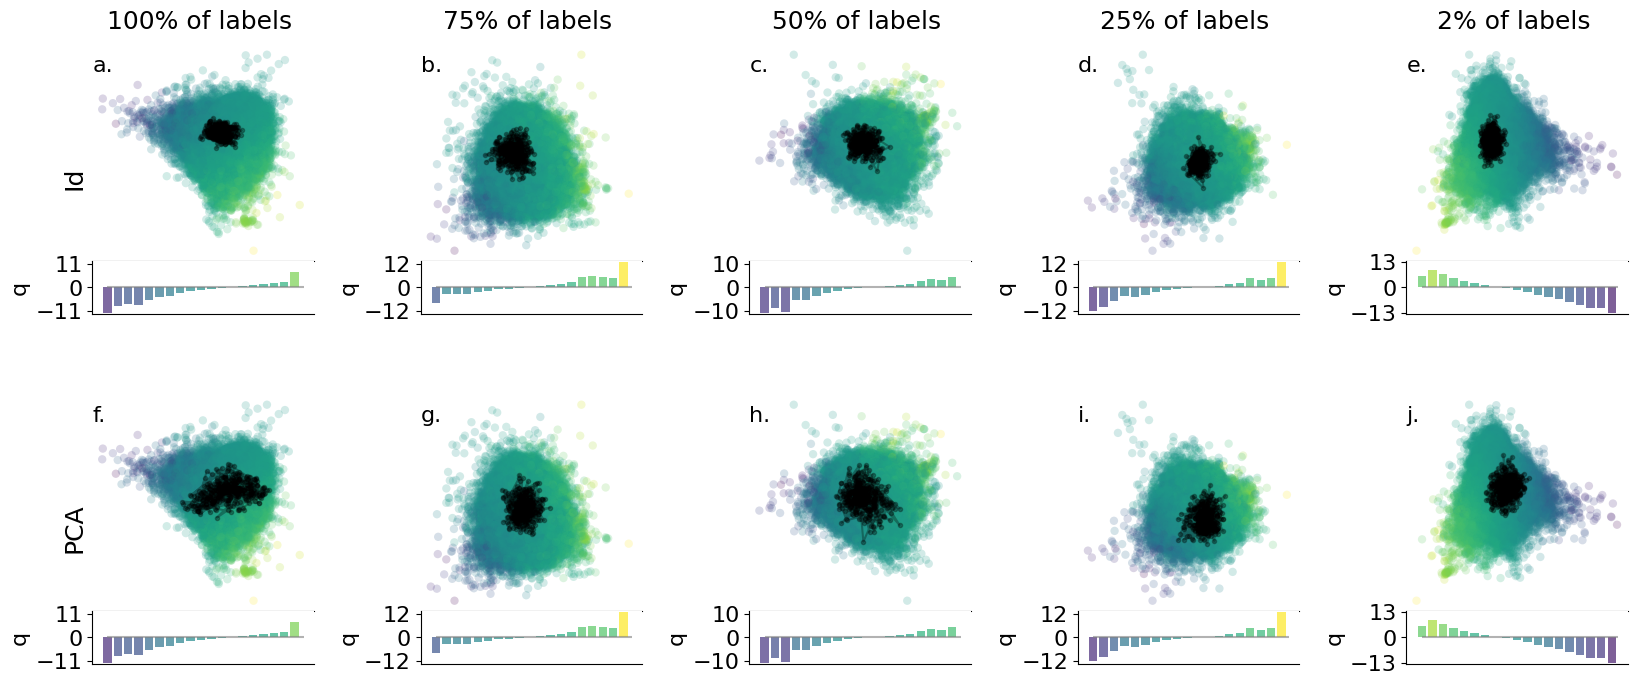

In [90]:
superfig_bayesopt_trajs = plt.figure(figsize=(16,7))
nrows, ncols = 2, 5
subfigs_bayesopt_trajs  = superfig_bayesopt_trajs.subfigures(nrows, ncols, wspace=0.15, hspace=0.0)

condn_rows = (nrows>1)
condn_cols = (ncols>1)

percentages = [0,25,50,75,98]
organizing_property = "bch"
run_space = "pca5"
run_spaces = ["Id","pca5"]

colour_by_properties  = ["boman", "charge", "hydrophobicity"]
if organizing_property=="boman-charge":
    colour_by_properties = ["boman","charge"]
elif organizing_property in ["predicted-log10mic","oracle"]:
    colour_by_properties = ["oracle"]
    percentages = [0,98]
elif organizing_property != "bch":
    colour_by_properties = [organizing_property]
    if organizing_property=="chargepH7p2":
        colour_by_properties = ["charge"]


for ix in range(ncols):
    _perc = percentages[ix]
    organizing_perc = 100-_perc
    for jx in range(nrows):
        run_space = run_spaces[jx]
        _prop = "charge"
        
        if condn_rows and condn_cols:
            sf = subfigs_bayesopt_trajs[jx, ix]
        elif not (condn_rows and condn_cols):
            sf = subfigs_bayesopt_trajs[ix]

        sf = plot_full_sampling_path(search_space_to_run_sequences, 
                                search_space_to_run_data,
                                model, 
                                organizing_perc, 
                                organizing_property,
                                run_space=run_space, 
                                colour_by=_prop,
                                plot_best_points=False,
                                fig=sf
        )
        _ax = sf.get_axes()[0]
        _ax.annotate(
                subpanel_to_letter[(ix,jx)],
                xy=(0, 1), xycoords='axes fraction',
                xytext=(+0.0, -0.5), textcoords='offset fontsize',
                fontsize=16, verticalalignment='top', fontfamily='sans-serif',
                # bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
        )
        
        if jx==0:
            sf.suptitle(f"{organizing_perc}% of labels", fontsize=18)
        if ix==0:
            if "pca" in run_space: 
                _search_space="PCA"
            else:
                _search_space="Id"
            sf.supylabel(f"{_search_space}", fontsize=18)

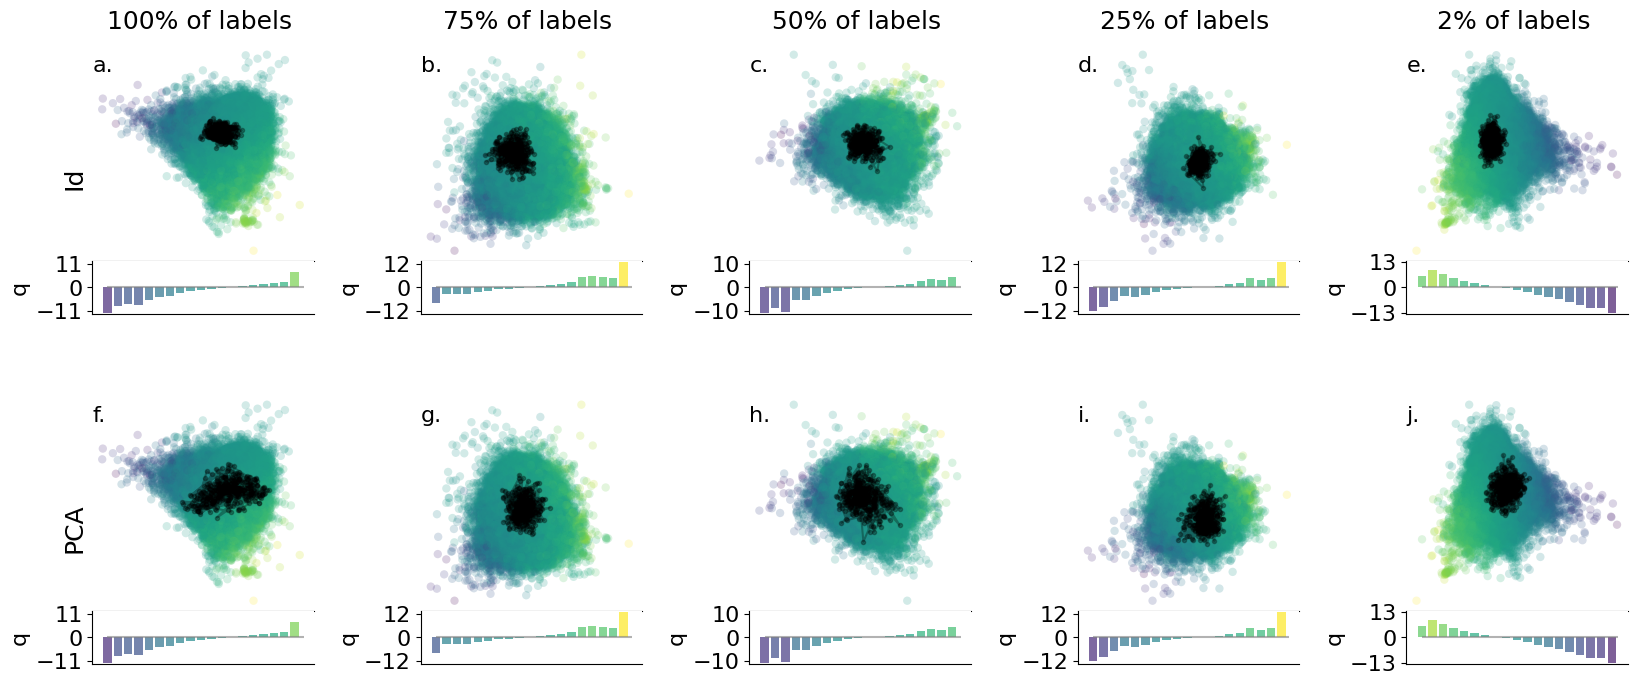

In [91]:
superfig_bayesopt_trajs

In [92]:
if not SAVE_FIGURES:
    superfig_bayesopt_trajs.savefig("figures/boloop_trajectories_IN_latent_space_bch_chargeColour_ID_and_PCA.png",dpi=300)

68 MDRKNLSEEQIEQFVKLVEELGDKTFVADDLFNARNLRCILSYEFLLALGEQQKEFQGPKTLKILDNI
93 MSRPSELPKPLSKVIKGTFRHLRNLVNDYYNLHHDRRVRLAQLALRQPARRETSTIPIPDRTFSQRALAERITKERLTEQKLRPTKQSQYSLE
96 MSKPVSPLNPSKVSKWKLTRHRFMLEYNNDLHLDRCLRVAALQRRLAEATTTSSSNDFIPDPTIATILAGRLLAQRDRMRPQRHRPHRQGHQHRQR
93 MSRPKVPNLSPASAKFGTRHLRLLNVYPNNYLLRRRDVRALQRAQDARRQSITSPTPIDSPSFAHATLAERIRDRQLRQQATQHARTLKTPAQ
92 MSSARVPPKPSESKGKMRQYRRLLYELPNYLHRQRDVRAAEHQRRATDQRARHTSIPDFCFSFTETREATAVEARVTQWQRHQRYRQRYRMV
96 MVRRRSPPPNISARKGTPWNLLHLRLERLYYPEYRRRAVAERQRQRADRAIRTSTLTDFPFTVTVALQRALATLRLRLWRAWRDRQRWRRQRWQRR
96 MSRVSPPPKPVSKKRVTYRMYRRQVQLLHYNDLRRERVRRERQAPAARQVRATVTFITFTVTDTTAITLTLALLTTTLWRRRYRRQRRRWQRQPTD
96 MRVSVSPNPIPSKGKVKYYPRRQRMLLLNLDLRDRFLREVRARQERALATATARVTFFDFTITPAEATAATVTTTQRWRQWTRRYRDRQYRDQRRW
96 MRVSCRPNPIPSKARGKPYPVRQQRLLYLLNDLRRVFVERLERERAQARATTITVFTFTVFVTTTAMAAAMTTTTTTTTTWDRRRQRRQQRQRWQR
77 MRVNSVPPRPRIKMKVRRYYRVRQRQYLNLRPLRFERVARARLANAERAIARTTVFTVTDFTDTVTRARAATQQQQQ
77 MKVRCRPVNPSLKMKVRTYRPWMQRNLRLHLDRDLRFRVRAKRERAEKTATVTV

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


95 MDKLVTMDNGSPTEDRLVLEWGEVTNIKGDPREIRLADFLEGPKTGELSYADMRSADTLVKLNGEMVRETLDKRPDKFKDLTPSGYIDSVLDRLV
95 MSYRQRPGDTAWFNARIPFRQRSPDRAYQVTRGINPRADRVQFHPRTQDRPVKDKVTKDKLSERMKHFTERKDTLNVEGYIEVDVEDFDISVPSL
95 MGRRGWCRGSRSWGFGSRWGAVRWVWSRSVWAGTSRCWRVAPGRRWPAWVRPSGERVTRTIRRVRLRQDRTPAPRLGDLIDSCPVAVDCPVSGEG
95 MGFRGCRGFGGSWVGFSGRWVVSWVWRSVGWVAFTRGFVGAGMRYRRFTVGPARPVAPRRVWASLRMRRLDTATLVLPCSDLVDVVCDVPVCLDT
94 MRRKKRKRTRTATRRTRLSLRFALRLTFKFTRKKKTFVRGTKHLTHPRHFRKVPVKMEKIRARRKRRHKYNNPEIEEVEVVMVVVDIVVVVVVD
95 MRKRKRKRATAFTARRTAFALFLRFKALFTTRTKALFSGTVTHLLHTRRYRVPAIKVEKIRKRRRPKRQYKPNPEIEIVVVIVVIVIVPVPIPIP
95 MKARKKAAAARAAKARASKAALAFARKKLAATATRLASALAFTKKLHTTAVRVLALALIKVKVRKRKRLKPQPEPIDEVVIVVIVVVIPVVVRIP
63 KKKKAKAKKARAKAKKARKALRAKSKLKAKRALTKLAKTARKLSALRLATRKALSQRAGARKR
79 KKAKKKAKAKAKKAKRAKARLAKRAKLRKAKKLTAKSTKATKALARLRLRALALRALSTLSATCRVTEAPAQAAKKKRK
64 MRWRRRFRWKFRSRWSFKFWFKKFFWKFLRFKFWLKFFKWSTFLFSLRLFTWLCKMCKRMCWRF
64 MRRRWRRWRSKRWSRFKWFKFKRFTKFWLRSFKWKFLRWSLFRFSLSKFLWTWCKMKCLCRRWR
79 MRRWRRRWRSKRWFRRSTW

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


90 MPRPTGIPKFRHTKPISTMREFSKQLSIEAVYGRINHLEANLPELIESVNAYAKALASMLRTNLYLNSLNETLEKDSKARQNELKSQRKT
90 MPPETLVFTWTQHVSINASKTPISRLAKTVEKFGANRIPILEDKTLAVPEVLTARMLKSLTKLTSFYLDNLELTSVKEHKEQIRQENEKS
89 MPPLDAWPFSFKTISKSKQLTVAMDMQRGIRFINVEGIPQELTLVDEIEGSARMLIQKRISCLHFFTCKTLNLDELQLKQESQKEKEKE
97 MMVNLHRYWIFTQLATTSKSWFSDQRKQAKMATGYNPSVQFPRPSAAVKIAIFAIAIGLLPKRPQFPDKPAFETNPTITPTIPTTQIKIYQKIKPKI
90 MMGCPLRYFTYFYAQHTSVNGHDVMRKVKAKGNGNSTFDKKKDTANAVAAVAVTIIIFGLTKKKYPPRPDEPTPRGKGKNKTKGFTLTEK
97 MMPFVPYTLFYTQLTRDFTENNHRRERMVMRMDNGYHIPYPPKAEAASAVIVTIGVGFLLTLKYQQPNQPTNGKIKGKVKCKFHWHYLCLYLCNLNL
97 MGMVYHYCLHTTFTKAAFDNNWCNCSRQAIREIENCCYYHCQQQEAAAAIVIGVFFFNIIMQKLQLQQAYPGYPYGCYHCHLPRKALKKALIRIKII
97 MMYMYSYHFTHTLTATFATFNNNCRRRCMVAAPYYYNMHSKANAAKAIANAIGTIFLLLVKQQEMYEKPAYYMKPYGKKGKGKLFFKGKKKNWPKDH
97 MMMYYYHTFHTLTLTATTFTFNCRNRRVMVPPFMTYPYLQNRMIEVQIAGTIVIAFLTLKLPKQGKEYEMQMYGKPKGKKGKGCFKKGWKKKGKPSH
97 MGKMYHYHTFTFTLTLTTADNCKCNCKVERAATNPNHYFYKKMQIATAAMATAVCGFLLYAAQYQQKYEKTGKPNGKCGCKCGKKAKVKIKGKRSKI
86 MMKYPTHFHTLTTTAT

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


90 MSPFNDSLHTVNSHSDVPMHFLTSNPDRMFHVHNAPNLDSFTRNPVQHVFPPTVEHVTPRNGTRRYCPARCTESGRTGNALNPVSGLSPS
18 RRARRRPRRRRRARARWA
29 RRPRRRARRRPRRARARARPAPRRARPAR
32 RSARLRRPRRARASRARARPARARPARAPRAR

MSPFNDSLHTVNSHSDVPMHFLTSNPDRMFHVHNAPNLDSFTRNPVQHVFPPTVEHVTPRNGTRRYCPARCTESGRTGNALNPVSGLSPS
mols_data.shape=torch.Size([4, 127]), props_data.shape=torch.Size([4, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


68 MRPDELKNEEIQRIIWIEALDADVYTGDIGSNIRNWSTLLFNGIRLLEVNKQGQLTLDKRHIVEHALG
96 MAMYKSGQLKFQQSRDVDKLRKRLWFPLDLLQYRLRACPEMARGEPMQCNECERRKRNGPDGERQVNVRRACQGRATAVDANGISEYLSWEMSRPL
96 MMSKPISKQVPNKCITRFARPRHNHYLNFNCSSQRCTSRWALFGLERADRWLELLGNIGYAYPKSKPRNCLRECGLRLGEWDLLDCEKSLYVKLSM
96 MTFFPFNATKQKRNFIALVSRHTHHNCNFNNFSRATRCHSNSCSGGKAGIKRKDIHDGELNRLCSKSVPRYSKGYCLYEWECEYLRIYCQKCSMQC
88 MKFSFYFQHGTQSATFLFRARLHHLNHNFYCNSSCSLTHTCSFVSFAGEKRQRVIIDFYGKKQPQRQLSRYPFRPHRFRGRFIFYFFF
96 MMFSYFPKAKHTPLCFEFRTSKLHHNNLFYFCNSLSCRSLMFFFVVISKKQITKIRICYIKRKTTQSKSLYRCHCFCYFKVYGKFTLFKILFKFTY
89 MSWKFPFNNQRLRISIRSRCRRQHTHNNNYNCCLSPLSTCFMYSFTKENIKAGIYFRRYRTKKSKPLLLYTRRYVICTVLFYCYFRFWF
94 MKSFWFSSLKQLFLKFVCTLTRTHNHNHNNFNRSTSHSCRCSCFFMATQQNIKGFRFTFRRYTMTYTPHTYLYSKFTIVFKLGLFKVLVKVAVK
96 MPITFNPERHRSKLIRCFRRLQLQHHNLNNFSYSSHSCLCSLYFIKSKTKKSFKIRFTGKYTRTHHTYKPTYPLFFLIFTVFVLFKFCLKVCKCKL

MEVNHIQKPELELRFKEIISKMIHYIEFEKSPLDLLNGKEFVEVQEFEQEVKNLKDLEGARDIKYGIYQ
mols_data.shape=torch.Size([9, 127]), props_data.shape=torch.Size([9, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


96 MKLYSKRYHEERFHNRSKNGKLKDHLFERNLKDMKEWLFTDKNKWLERSIYRWDRNLKELDPEREKFHDHYSKKDKCDLSKDLLKELVPSRTKAPI
96 MVAKVARKVAVEKVKAKRAKGERARKAKGEVRAERRGERKAGERGKTERGIRERDRREPEREAEEWAREWHRPDGERAGDRRELEARQGARAPARR
71 VKVARVKVVKEVKVKAKRKAREGRKAKARVEGKKVEREVERREGAKREREAGTAREREKDKRAAAATAEER
41 VKVVRARKVGKVKAKVKRERKAKVKEVKRAVERGREKAEVR
41 VRVKVVRVKGVKVKVKVKRAGRKRAGRKVVERVGRKARAGR
96 MVRVVRVRGVIWVVKVVKIKVFKVKVKAMFRIGKIRVKRGGERFGLARLGRIGKRDLRDVEALGKPTERFRPVKIVDTAVERAIAAEVEALAKGAT
71 MRVCRRWVVWVIRWVKVKFRMKVKYVRICKFKVKYVTFGRRIGKNRRFTILGVSLKRNGCTGIVATARINP
71 MRRVWVRIWRIKVWVIKKVYRKIKFRTVYKIFKKVKDRRIFTKSKFKRECIEVTVNNYRGTVVEAARAANG
42 MRVCRVWRVWVVKFRMVRKCGVKRCKFVRTWVYVRRFTVKGC
71 MCRRCVWCWVFVRMCKCVFKMVMKCYCVRLFKVCPYRGRVGRGLYLFTCTILVFALPRYRGVVTSVATSKF
71 MCRCWCRWVWFCRMRYVCKFMMKCYRLCICKCYGKCTFTRYVFLKYLVLGTFTLVPFPRKFRVVATAASRS

MKLYSKRYHEERFHNRSKNGKLKDHLFERNLKDMKEWLFTDKNKWLERSIYRWDRNLKELDPEREKFHDHYSKKDKCDLSKDLLKELVPSRTKAPI
mols_data.shape=torch.Size([11, 127]), props_data.shape=torch.Size([11, 1])
mols_data.shape

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MKNLGNVKKTLYSINLPRASPFNTQMVSLSEFQTPGIRLSKIKTKQFIELTRIKANVPILNANKLPNHLDSLDSPAYELGKRQGWILNLGDL
96 MKKHSEKFHTKLPLISKASKNLTNNTQIAPSLYTKILSGELYANVQKIRPASAVIRNYRESHIKNRCDSRDKNPAHNHPKNFGHVYLFLFHDCSLG
96 HQVRVPAYLKYVKKLRSARINNTHTMQAIRHTTTIEKARIRLYIEKKRQLNLLIRLRLQEPKYKYIILSYIREEKNIHNELPNVLFCFKVLPSLFK
96 MQKKKVAINTYWLHLAIIENNHTTIEIQRMLTKTNQAIAGKGIKIAKGASSSAIEASSTNTGNKTKKGSKKNKQKANKNNVNSSSSPSASAKSPAK
97 MQKKRVAIDYHGWLLAIEENHYTIIQIMSLHTKINKAEGTLTATAKAGISAKEIVSSSNTKTIKNKKSKAQNKQANKAGNAKNSKNSIYAIYIIGDG
96 MQKQKAVVIYHGKVLLIQINNMLTQIQIIHRHFTQEASKIFKGAIQTKAAGATIAIENISTKGKTSSKNAKNQSKNKQNKDIGSIISGISIKNSKA
96 MQKQAAVTTGNWKLVAEENNHNTTIQMQILMTHTIEAIKFKVASKNAAKASVNAAINVSNKSNKKDKKNPKNAQNKNQSSSDVATSAYISAKKSKN
96 MQQKVGIGDNFLKLLMAEENNHTNIQAIRLHTTMAESSGVKTVKIASKANKAVKISEDSTAKNTKNKKTNQSQSNKANKNSDKIGIFKTVSKTGNK
92 MQQKDKGIITKWKRLANEIENNTHMIEQALLTHSSNAIAGFFHTAAAEAFTKKAINNDSSSKTKTNKKNQQKANKNKTKTATASNASIAINE
97 MQQKVGAVKNTWLRLAMENNQNMNMAIQRHFHTKAEIAKTLTKVAAKASKTLAEISIDKTSKTKTTKKNKQNAEKNAKANKDKTATKTVKTTVKDKF
97 MQQ

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


96 MSKPDMKVPATHILDHIRFSNLEGCGELSPDLKGSGELNTLRGIPNLLDLNRSLNVKGTIKPREDLRVGNLIPEYRDYNTQFPKFSFGLTFSLFNV
96 FFLFILFLGPVSKAGLGENKVQCAIEHVHVPEVRGPAPVNGLARDGIKPAGIKLAYEYRLDRAMGLARRLARQLAQEQEEEAEEAIEAIQKSYAKQ
96 LFLLCLLLLRGGKRVRRGAPKSRLARSGNLRLPALAYAKGPLAAVGHAPVRGIGRPLIKPGACAARLLRLRQARAEQREEEAEIEAIEAMQGRLAP
96 MRWRWLRRKKRCRRSRRKPLLKQRVRRYRSKRVRHAGGPARLPRGVAHAPGAGKACAHPDLKAKARLRLARQLAQEQEPEQAEEQVEQVMQIGQGA
96 MQRQRHRRLRRCAKRLLGLSWRLLLVKKRCSLRGLSRRGGAGLRGKLPIAGLRLPPGRPVPRAVRKARRALAAPAEPENQPEQKIQQIPEVLIYIE
96 MQQRQRRRWRLRSLRLCLLLRLCLLRLGRGGRWVRRLGSRVRWLLPVAPRVLKGRCPAPKVAGKRARRAALAATNNANQPAPQQPANAPITITTAG
96 MQQRQRHRRRWRSRRCRCLRLWLRLWGRVRHWLVRKRGRVKRCRGKAGSLKVRKPCRPLPATARKRARAKAVAPTPENQQPQPAPPATPATTNTAV
96 MQQRQRHRRWRLRSRCLWLLLRCLWLRVRGWKGWRVRALKCGRRCVRASGKGLKKVHPRVPVRKARRRARAAVAPANQNQNPQQEPAPIAPIATAT
96 MQHRRHRWRWRCRLHLCLWLLWLWLCLRCRGWCRLKLGRGKCRLGLKSGKGVLRKCPPKPVRVRRSRRRAKVAPAPINNQQPAPQPIQTITATITK
67 MQRRRQRRHRRRKRRSRWRGRRLRLKRSCRRAKLKLSKRGKALPRRLPSGLPLARPACPATKQLWLT

MFFVYVFLSFIGYLAVTGMPVNFARPVT

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


92 MNATNIVRTFPMITADGTKRRWMRTAMANLHDDLNANSSNKSLELGLFDFISEFIKEVQKNLNEQLGKTLEKKRSGNISSYLSGLQKNLLRK
92 MPELNVNFKGFRSYEALHKDHIYKSELKINYFILNGLNSHTKKTLVKIHFITTIKTALNLSGIINKNPRQQNKEIVSSFYMLEGRLQRELEK
92 MPNVRGINSLFNKFIQTLPAWIYPEKLTELFDLNSVTFNLSKNKIILNPVSKIITKNLLGKNGINPMLQNKKARENGNLYFSGSIKKAQQIL
90 PNPAKIYIPKAYYALNKSPCHISSLKNPATKYINLTPNPKLQRIEKLFSIMLEATASTMTNIQEYLKNLLQQKEKRDRYGWTKVAAEAIQ
90 PNKLLITFNKLGYLTLKHTFYFVSKKSNKTLTDFMQHQPPQTKAMALSFNILEIKKIPESDEQYIQHLKKEKQIKNNTYKWLIKIAAEAQ
91 PPPQITWASQIYYQYPQPTPYYALTSPVKKSITDSMKPNFKIMQKGGLYLKIIKKEWTGEIKQNIYKYPYQQKKMKQKWPWSEIEEIEAEA
91 PKPIPASFTLITGTNQHVKTCFYMSKSPLLLTGSLKPKKHKISQEKACFYIKEIKENFIIEQNQQKNPNQEMMQKKKPHHSYIIIEEQKEA
91 PKPIKSFKVSDQINSSKTPIWYISPSLPTLPIGLSKKPKPYAKEMAKYCGILQITQIYVTEQQQKNRNNQMQQKKPKKHYFSLIEEEQAEA
91 PPFAAIIWSQSYNIYARQPWSYVAPWPLLSLMGCPLQKHPRKEQAKIWCSTKKTINIYVNTQNNNNNNMQIQQQKHHHTHGIGIIKEIQAA
91 MPFKGAFTSSTKDVSNKPNWGSAVPLGPKKYIYPKQKPLFLNNQLAISFGLLQEITGYINTRRMQNGYTKQQQQNNHHSWCCIIAAAAQAK
91 FPKIQYFTFYAITYPNPKKLWYILPAKKFKNNIKLKLKPVLQNKKI

/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


86 MLGQLHILVRALYLILLKNVFIKLNFLLQIIPFHTLKEVGFPGRQLQYGFCFDQKKRGNCYFQLRLKPLPSIITINDNNNNNHNND
86 MQQKQKKKKLKKLIRLKAKLWKARLPPLLIQLFHHLKAAIHWRRKQKLYWCCNQQKRLFYWIRQRRPRLRLNIIYINNNQNNNNNY
86 MQKKKKKKKKKKKKARQKKLKARKRKKRAARARRPRAAQLPTPKQKRANCRFREQRARFRYGRQRRARRLRGMDTTQNNNRNNNNG
86 MQQQKQKAQKQKKATQKQKAGKQKRELKKELERRFQKAESKNLRKQQIHDLSREERRARYGYKQRKRARYRIRIDRENNQNNNNSD
86 MQKKKKKKKKKKLAKRAKRLALRKRKLLKARLTPRLKALLTPRMKRALNGFRGARMRARYFTPAKRQRLGFIRTNIRGQRNINHTS

MLGQLHILVRALYLILLKNVFIKLNFLLQIIPFHTLKEVGFPGRQLQYGFCFDQKKRGNCYFQLRLKPLPSIITINDNNNNNHNND
mols_data.shape=torch.Size([5, 127]), props_data.shape=torch.Size([5, 1])
mols_data.shape=torch.Size([500, 127]), props_data.shape=torch.Size([500, 1])


/tmp/ipykernel_145722/2663086349.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_col3_per_bin = df.groupby("col2_bin")[col3].mean()


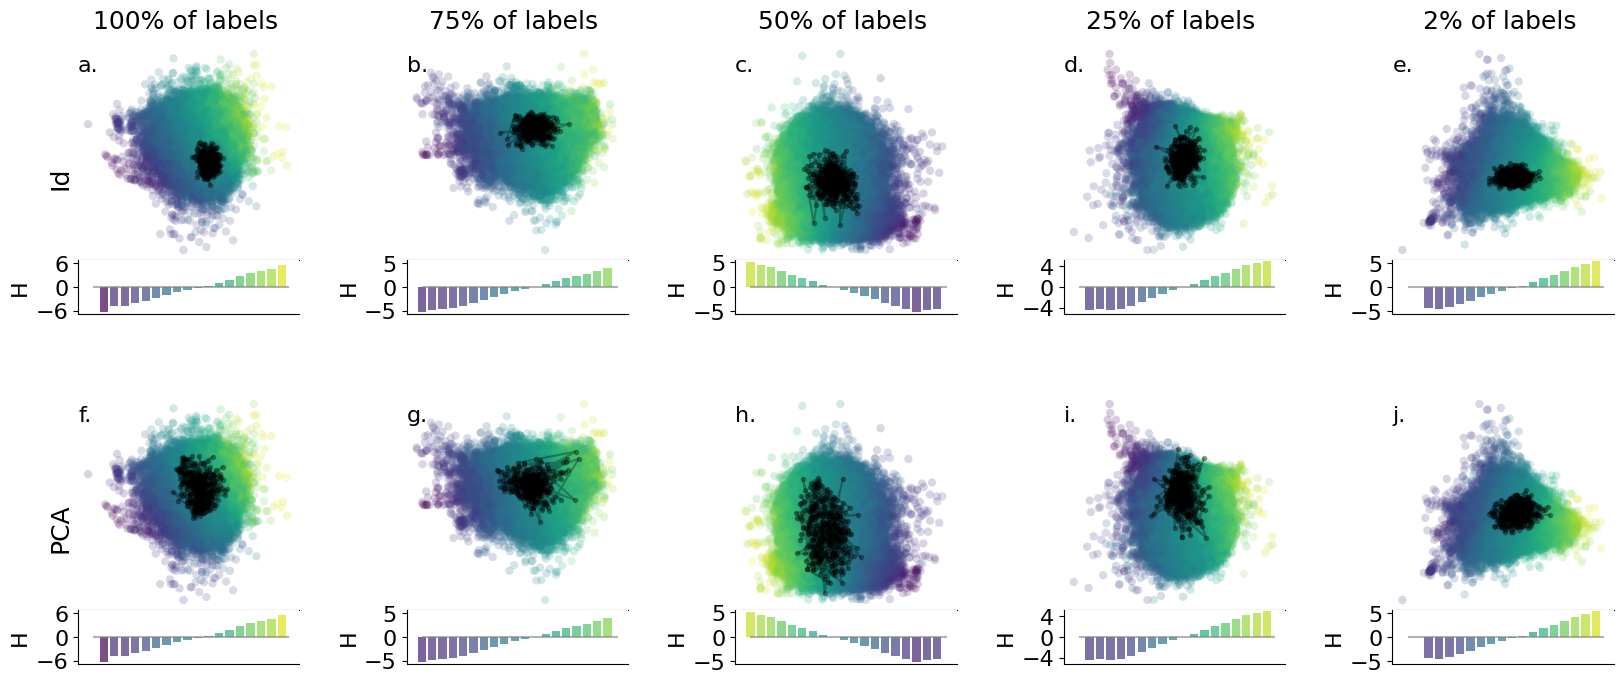

In [93]:
superfig_bayesopt_trajs = plt.figure(figsize=(16,7))
nrows, ncols = 2, 5
subfigs_bayesopt_trajs  = superfig_bayesopt_trajs.subfigures(nrows, ncols, wspace=0.15, hspace=0.0)

condn_rows = (nrows>1)
condn_cols = (ncols>1)

percentages = [0,25,50,75,98]
organizing_property = "bch"
run_space = "pca5"
run_spaces = ["Id","pca5"]

colour_by_properties  = ["boman", "charge", "hydrophobicity"]
if organizing_property=="boman-charge":
    colour_by_properties = ["boman","charge"]
elif organizing_property in ["predicted-log10mic","oracle"]:
    colour_by_properties = ["oracle"]
    percentages = [0,98]
elif organizing_property != "bch":
    colour_by_properties = [organizing_property]
    if organizing_property=="chargepH7p2":
        colour_by_properties = ["charge"]


for ix in range(ncols):
    _perc = percentages[ix]
    organizing_perc = 100-_perc
    for jx in range(nrows):
        run_space = run_spaces[jx]
        _prop = "hydrophobicity"
        
        if condn_rows and condn_cols:
            sf = subfigs_bayesopt_trajs[jx, ix]
        elif not (condn_rows and condn_cols):
            sf = subfigs_bayesopt_trajs[ix]

        sf = plot_full_sampling_path(search_space_to_run_sequences, 
                                search_space_to_run_data,
                                model, 
                                organizing_perc, 
                                organizing_property,
                                run_space=run_space, 
                                colour_by=_prop,
                                plot_best_points=False,
                                fig=sf
        )
        _ax = sf.get_axes()[0]
        _ax.annotate(
                subpanel_to_letter[(ix,jx)],
                xy=(0, 1), xycoords='axes fraction',
                xytext=(+0.0, -0.5), textcoords='offset fontsize',
                fontsize=16, verticalalignment='top', fontfamily='sans-serif',
                # bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
        )
        
        if jx==0:
            sf.suptitle(f"{organizing_perc}% of labels", fontsize=18)
        if ix==0:
            if "pca" in run_space: 
                _search_space="PCA"
            else:
                _search_space="Id"
            sf.supylabel(f"{_search_space}", fontsize=18)

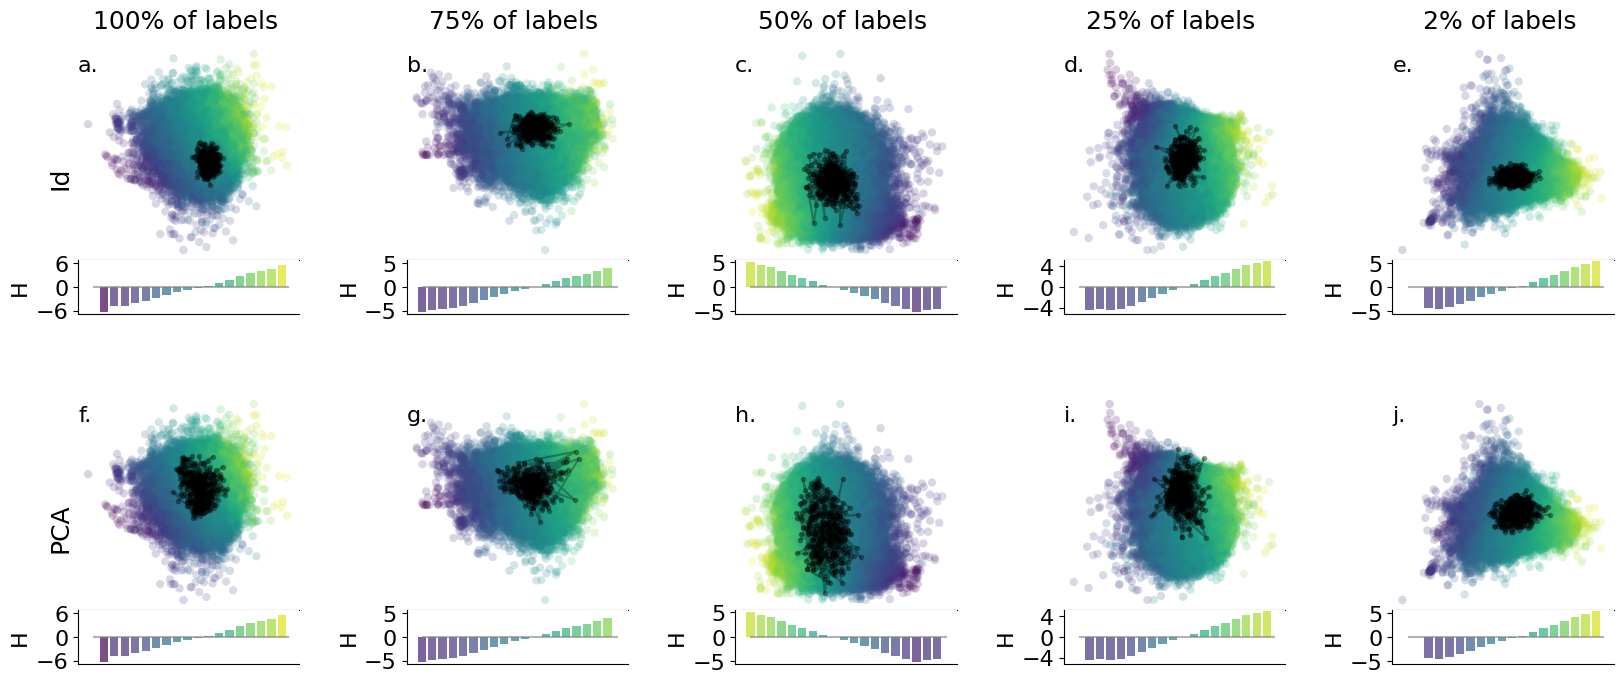

In [94]:
superfig_bayesopt_trajs

In [95]:
if not SAVE_FIGURES:
    superfig_bayesopt_trajs.savefig("figures/boloop_trajectories_IN_latent_space_bch_hydrophobicityColour_ID_and_PCA.png",dpi=300)

# perform animation

In [25]:
make_items_visible = True # false if doing animation
superfig = superfig = plt.figure(figsize=(12,6))
subfigs = superfig.subfigures(1, 2, wspace=0.0, hspace=0.08)

<Figure size 1200x600 with 0 Axes>

In [26]:
fig_latent_space = subfigs[0]

fig_latent_space = make_scatter_plot_w_barplot(df, _pc2, _pc1, "oracle", fig_latent_space, alpha=0.3,raster=True)


NameError: name '_pc2' is not defined

In [27]:
superfig

<Figure size 1200x600 with 0 Axes>

In [59]:

_ax_scatter = fig_latent_space.get_axes()[0]

_ax_scatter.plot(
    pca_mu_run_sequences[:,_pc1_idx],
    pca_mu_run_sequences[:,_pc2_idx],
    color="k",
    alpha=0.3,
    marker="."

)

latent_space_text_artists = []
latent_space_marker_artists = []
for i in range(len(pca_mu)):

    mk, = _ax_scatter.plot(
        pca_mu[i,0], 
        pca_mu[i,1], 
        marker="o",
        ms=10, 
        linestyle="None", 
        color=sns.color_palette("rocket_d",n_colors=17)[i], 
        visible=make_items_visible
    )
    latent_space_marker_artists.append(mk)

    txt = _ax_scatter.text(
        x = pca_mu[i,0], 
        y = pca_mu[i,1], 
        s = str(i+1), 
        horizontalalignment="center", 
        verticalalignment="center",
        color="white",
        fontsize=10,
        visible=make_items_visible
    )
    latent_space_text_artists.append(txt)


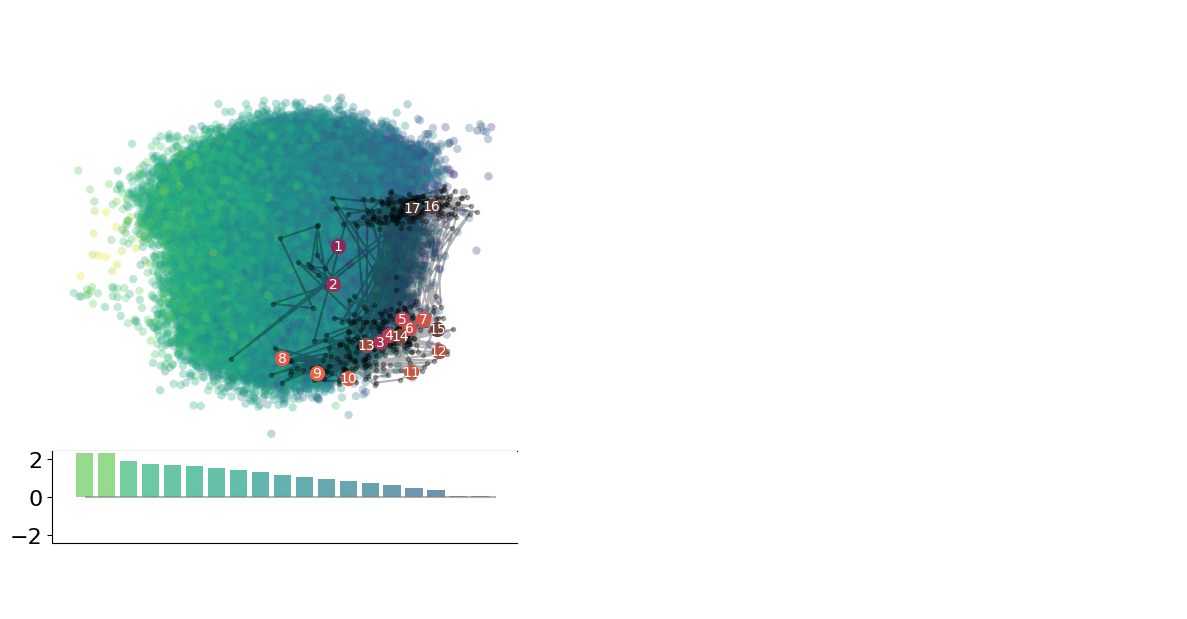

In [60]:
superfig

In [61]:
fig_line_plot = subfigs[1]
grid = fig_line_plot.add_gridspec(2,1)

In [62]:
if not make_items_visible:
    axT= fig_line_plot.add_subplot(grid[0])
    axT.set_axis_off()
    
    ax = fig_line_plot.add_subplot(grid[1])
    
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min()*1.1, y.max()*1.1)
    ax.set_ylabel("$M_{\\text{best}}$", fontsize=14)
    ax.set_xlabel("Iteration", fontsize=14)
    (line,) = ax.plot(x,y , lw=2, color="#D55E00")
    
    # Pre-create (hidden) text and optional markers for each label
    text_artists = []
    marker_artists = []
    for ix, (_x, _y, _t) in enumerate(labels):
        txt = ax.text(_x, _y, _t, va="bottom", ha="left", fontsize=9, visible=make_items_visible)
        text_artists.append(txt)
        
        mk, = ax.plot(_x, _y, 
                      marker="o",
                      ms=4, 
                      linestyle="None", 
                      visible=make_items_visible, 
                      color=sns.color_palette("rocket_d",n_colors=17)[ix], 
                      alpha=0.8)
        marker_artists.append(mk)

In [64]:
if not make_items_visible:
    if SAVE_FIGURES:
        superfig.savefig("figures/boloop_trajectory_in_latent_space_oracle2perc.jpg", dpi=300)

In [82]:
# fig, ax = plt.subplots(figsize=(6,4))
# fig_line_plot = subfigs[1]
axT= fig_line_plot.add_subplot(grid[0])
axT.set_axis_off()

ax = fig_line_plot.add_subplot(grid[1])

ax.set_xlim(x.min(), x.max()); ax.set_ylim(y.min()*1.1, y.max()*1.1)
ax.set_ylabel("$M_{\\text{best}}$", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
(line,) = ax.plot([], [], lw=2, color="#D55E00")

# Pre-create (hidden) text and optional markers for each label
text_artists = []
marker_artists = []
for ix, (_x, _y, _t) in enumerate(labels):
    txt = ax.text(_x, _y, _t, va="bottom", ha="left", fontsize=9, visible=False)
    text_artists.append(txt)
    
    mk, = ax.plot(_x, _y, 
                  marker="o",
                  ms=4, 
                  linestyle="None", 
                  visible=False, 
                  color=sns.color_palette("rocket_d",n_colors=17)[ix], 
                  alpha=0.8)
    marker_artists.append(mk)

# Keep track of reveal state
revealed = [False]*len(labels)

def init():
    line.set_data([], [])
    for t, m, lst, lsm in zip(text_artists, marker_artists, latent_space_text_artists, latent_space_marker_artists):
        t.set_visible(False)
        m.set_visible(False)
        
        lst.set_visible(False)
        lsm.set_visible(False)
    return (line, *text_artists, *marker_artists, *latent_space_text_artists, *latent_space_marker_artists)

def update(i):
    # Draw line up to i and place the moving cursor at the newest point
    xi = x[:i]
    yi = y[:i]
    line.set_data(x[:i], y[:i])
    if len(xi) == 0:
        return (line, *text_artists, *marker_artists, *latent_space_text_artists, *latent_space_marker_artists)

    line.set_data(xi, yi)

    # Reveal any labels with _x <= current x
    current_x = xi[-1]
    for k, ((_x, _y, _t), shown) in enumerate(zip(labels, revealed)):
        if not shown and _x <= current_x:
            text_artists[  k].set_visible(True)
            marker_artists[k].set_visible(True)

            latent_space_text_artists[  k].set_visible(True)
            latent_space_marker_artists[k].set_visible(True)
            revealed[k] = True

    # Returning all changed artists (blit=False below, so this is flexible)
    return (line, *text_artists, *marker_artists, *latent_space_text_artists, *latent_space_marker_artists)

print("Making FuncAnimation object")
# ani = FuncAnimation(superfig, update, frames=len(x), init_func=init, blit=False, interval=20, repeat=False)
ani = FuncAnimation(superfig, update, frames=range(0,len(x),100), init_func=init, blit=False, interval=100, repeat=False)

print("Saving animation...")
# Save one of these:
# ani.save("line.mp4", writer=FFMpegWriter(fps=50, bitrate=1800))
ani.save("line.gif", writer=PillowWriter(fps=30))
# plt.show()
print("Done saving")

Making FuncAnimation object
Saving animation...


In [84]:
labels = list(
    zip(
        list(last_iterations.values), 
        [round(_v, 3) for _v in last_iterations.index], 
        list(range(1,len(last_iterations)+1,1))
    )
)

In [124]:
labels

[{'x': 13, 'y': -0.26, 'text': 1, 'img': 'snapshots/protein_1.png'},
 {'x': 15, 'y': -0.137, 'text': 2, 'img': 'snapshots/protein_2.png'},
 {'x': 16, 'y': 0.017, 'text': 3, 'img': 'snapshots/protein_3.png'},
 {'x': 21, 'y': 0.208, 'text': 4, 'img': 'snapshots/protein_4.png'},
 {'x': 23, 'y': 0.31, 'text': 5, 'img': 'snapshots/protein_5.png'},
 {'x': 25, 'y': 0.325, 'text': 6, 'img': 'snapshots/protein_6.png'},
 {'x': 31, 'y': 0.516, 'text': 7, 'img': 'snapshots/protein_7.png'},
 {'x': 55, 'y': 0.555, 'text': 8, 'img': 'snapshots/protein_8.png'},
 {'x': 81, 'y': 0.559, 'text': 9, 'img': 'snapshots/protein_9.png'},
 {'x': 139, 'y': 0.674, 'text': 10, 'img': 'snapshots/protein_10.png'},
 {'x': 157, 'y': 0.689, 'text': 11, 'img': 'snapshots/protein_11.png'},
 {'x': 178, 'y': 0.724, 'text': 12, 'img': 'snapshots/protein_12.png'},
 {'x': 225, 'y': 0.802, 'text': 13, 'img': 'snapshots/protein_13.png'},
 {'x': 227, 'y': 0.963, 'text': 14, 'img': 'snapshots/protein_14.png'},
 {'x': 335, 'y': 1.

In [87]:
labels = []
for _t in zip(
        list(last_iterations.values), 
        [round(_v, 3) for _v in last_iterations.index], 
        list(range(1,len(last_iterations)+1,1))
    ):
    labels.append(
        {
            "x":_t[0],
            "y":_t[1],
            "text":_t[2],
            "img":f"snapshots/protein_{_t[2]}.png"
        }
    )

In [152]:
labels

[{'x': 13, 'y': -0.26, 'text': 1, 'img': 'snapshots/protein_1.png'},
 {'x': 15, 'y': -0.137, 'text': 2, 'img': 'snapshots/protein_2.png'},
 {'x': 16, 'y': 0.017, 'text': 3, 'img': 'snapshots/protein_3.png'},
 {'x': 21, 'y': 0.208, 'text': 4, 'img': 'snapshots/protein_4.png'},
 {'x': 23, 'y': 0.31, 'text': 5, 'img': 'snapshots/protein_5.png'},
 {'x': 25, 'y': 0.325, 'text': 6, 'img': 'snapshots/protein_6.png'},
 {'x': 31, 'y': 0.516, 'text': 7, 'img': 'snapshots/protein_7.png'},
 {'x': 55, 'y': 0.555, 'text': 8, 'img': 'snapshots/protein_8.png'},
 {'x': 81, 'y': 0.559, 'text': 9, 'img': 'snapshots/protein_9.png'},
 {'x': 139, 'y': 0.674, 'text': 10, 'img': 'snapshots/protein_10.png'},
 {'x': 157, 'y': 0.689, 'text': 11, 'img': 'snapshots/protein_11.png'},
 {'x': 178, 'y': 0.724, 'text': 12, 'img': 'snapshots/protein_12.png'},
 {'x': 225, 'y': 0.802, 'text': 13, 'img': 'snapshots/protein_13.png'},
 {'x': 227, 'y': 0.963, 'text': 14, 'img': 'snapshots/protein_14.png'},
 {'x': 335, 'y': 1.

In [154]:
# fig, ax = plt.subplots(figsize=(6,4))
# fig_line_plot = subfigs[1]
interval_between_frames = 50

axT= fig_line_plot.add_subplot(grid[0])
axT.set_axis_off()

# Preload protein images
imgs = [mpimg.imread(d["img"]) for d in labels]

###################
# images on top
axT.axis("off")
img_prev = axT.imshow(imgs[0], alpha=1.0, animated=True)
img_next = axT.imshow(imgs[0], alpha=0.0, animated=True)  # will be replaced at each transition

# Map label x to first frame index where x[t] >= label_x
label_frames = [int(np.searchsorted(x, d["x"])) for d in labels]
revealed = [False]*len(labels)

# global remaining, current_img_idx
current_img_idx = 0
transition_frames = interval_between_frames         # how many frames to crossfade
remaining = 0                  # remaining frames in current crossfade (0 = no transition)

###############
# draw line plot bottom
ax = fig_line_plot.add_subplot(grid[1])

ax.set_xlim(x.min(), x.max()); ax.set_ylim(y.min()*1.1, y.max()*1.1)
ax.set_ylabel("$M_{\\text{best}}$", fontsize=14)
(line,) = ax.plot([], [], lw=2, color="#D55E00")

# Pre-create (hidden) text and optional markers for each label
text_artists = []
marker_artists = []
for ix, d in enumerate(labels):
    _x, _y, _t = d["x"], d["y"], d["text"]
    txt = ax.text(_x, _y, _t, va="bottom", ha="left", fontsize=9, visible=False)
    text_artists.append(txt)
    
    mk, = ax.plot(_x, _y, 
                  marker="o",
                  ms=4, 
                  linestyle="None", 
                  visible=False, 
                  color=sns.color_palette("rocket_d",n_colors=17)[ix], 
                  alpha=0.8)
    marker_artists.append(mk)

# Keep track of reveal state
revealed = [False]*len(labels)

def init():
    line.set_data([], [])
    img_prev.set_data(imgs[0]); img_prev.set_alpha(1.0)
    img_next.set_data(imgs[0]); img_next.set_alpha(0.0)
    for t, m, lst, lsm in zip(text_artists, marker_artists, latent_space_text_artists, latent_space_marker_artists):
        t.set_visible(False)
        m.set_visible(False)
        
        lst.set_visible(False)
        lsm.set_visible(False)
        
    return (line, img_prev, img_next, 
            *text_artists, *marker_artists, 
            *latent_space_text_artists, *latent_space_marker_artists
           )

def update(i):
    global remaining, current_img_idx

    # Draw line up to i and place the moving cursor at the newest point
    xi = x[:i]
    yi = y[:i]
    line.set_data(x[:i], y[:i])
    if i == 0:
        return (line, img_prev, img_next, 
                *text_artists, *marker_artists, 
                *latent_space_text_artists, *latent_space_marker_artists
               )

    line.set_data(xi, yi)

    # Reveal any labels with _x <= current x
    current_x = xi[-1]
    for k,(f, shown) in enumerate(zip(label_frames, revealed)):
        if not shown and i >= f:
            text_artists[  k].set_visible(True)
            marker_artists[k].set_visible(True)

            latent_space_text_artists[  k].set_visible(True)
            latent_space_marker_artists[k].set_visible(True)
            revealed[k] = True
            
            # global remaining, current_img_idx
            if k != current_img_idx:  # avoid redundant fades
                img_prev.set_data(imgs[current_img_idx]); img_prev.set_alpha(1.0)
                img_next.set_data(imgs[k]);              img_next.set_alpha(0.0)
                current_img_idx = k
                remaining = transition_frames

    # Crossfade logic
    # global remaining
    if remaining > 0:
        a = 1.0 - (remaining / transition_frames)  # 0→1
        img_next.set_alpha(a)
        img_prev.set_alpha(1.0 - a)
        remaining -= 1
        if remaining == 0:
            # Snap to the new image fully visible, hide the old
            img_prev.set_data(imgs[current_img_idx]); img_prev.set_alpha(1.0)
            img_next.set_alpha(0.0)

    # Returning all changed artists (blit=False below, so this is flexible)
    return (line, img_prev, img_next, 
                *text_artists, *marker_artists, 
                *latent_space_text_artists, *latent_space_marker_artists
               )

print("Making FuncAnimation object")
# ani = FuncAnimation(superfig, update, frames=len(x), init_func=init, blit=False, interval=20, repeat=False)
ani = FuncAnimation(
    superfig, 
    update, 
    frames=range(0,len(x),5), 
    init_func=init, blit=False, 
    interval=interval_between_frames, 
    repeat=False
)

print("Saving animation...")
# Save one of these:
# ani.save("line.mp4", writer=FFMpegWriter(fps=50, bitrate=1800))
t0 = time.time()
ani.save("line.gif", writer=PillowWriter(fps=30))
tf = time.time()
# plt.show()
print("Done saving")
print(f"it took {tf-t0}s")

Making FuncAnimation object
Saving animation...
Done saving
it took 218.55345368385315s


In [115]:
remaining = 0
del remaining

In [ ]:
len(x)

In [153]:
len(range(0,len(x),5))

100

In [ ]:
frames, time(s)
25, 55
50, 110,
100, (220?)

500,1100